# Behavior Cloningを使用して実機の自動運転の学習をしたい。
学習データは、自分が運転したデータを使用する。
データの形式は、画像とその時の操作であるsteeringとthrottleの値が保存されている。


In [1]:
import numpy as np
import gymnasium
from gymnasium.wrappers import TimeLimit
from imitation.data import rollout
from imitation.policies.serialize import load_policy
from imitation.util.util import make_vec_env
from imitation.data.wrappers import RolloutInfoWrapper
from stable_baselines3.common.vec_env import VecVideoRecorder, DummyVecEnv

from gymnasium.spaces import Box
from gymnasium.envs.registration import register
import racing_gym
import os
import json
from PIL import Image


## 環境を事務のレジストリに追加する

In [2]:
gymnasium.register(
    id = 'RacingEnv-v0',
    entry_point = 'racing_gym.envs.racing_env:RacingEnv',
    max_episode_steps = 1000,
)
gymnasium.register(
    id = 'RacingEnv-v1',
    entry_point = 'racing_gym.envs.racing_env1:RacingEnv1',
    max_episode_steps = 1000,
)
gymnasium.register(
    id = 'RacingEnv-v2',
    entry_point = 'racing_gym.envs.racing_env2:RacingEnv2',
    max_episode_steps = 1000,
)

/home/gaia-22/miniconda3/envs/env38/lib/python3.8/site-packages/gymnasium/envs/registration.py:694: UserWarning: WARN: Overriding environment RacingEnv-v0 already in registry.
  logger.warn(f"Overriding environment {new_spec.id} already in registry.")
/home/gaia-22/miniconda3/envs/env38/lib/python3.8/site-packages/gymnasium/envs/registration.py:694: UserWarning: WARN: Overriding environment RacingEnv-v1 already in registry.
  logger.warn(f"Overriding environment {new_spec.id} already in registry.")
/home/gaia-22/miniconda3/envs/env38/lib/python3.8/site-packages/gymnasium/envs/registration.py:694: UserWarning: WARN: Overriding environment RacingEnv-v2 already in registry.
  logger.warn(f"Overriding environment {new_spec.id} already in registry.")


ベクトル化された環境を作成する

In [3]:
import os
import json
import numpy as np
from PIL import Image

def load_expert_data(data_path):
    # expert_dataの初期化
    expert_data = {'images': [], 'actions': []}
    # print(expert_data)
    # count = 0

    # 画像ファイルに対応するJSONファイルを取得
    json_file_list = [json_file for json_file in os.listdir(data_path) if json_file.startswith('record_') and json_file.endswith('.json')]
    # print(len(json_file_list))

    for json_file in json_file_list:
        # count += 1
        # print(count)
        # print(json_file)

        # レコードのファイルパスを構築
        json_path = os.path.join(data_path, json_file)
        # print(json_path)

        # レコードの読み込み
        try:
            with open(json_path, 'r') as json_file:
                record_data = json.load(json_file)
        except FileNotFoundError:
            print(f"エラー：{json_path} でJSONファイルが見つかりませんでした。")
            continue
        except json.JSONDecodeError:
            print(f"エラー：{json_path} のJSONファイルのデコードに失敗しました。")
            continue

        # 画像データの読み込み
        image_file = record_data.get('cam/image_array', '')  # 画像ファイル名をJSONから取得
        # print(image_file)
        image_path = os.path.join(data_path, image_file)
        # print(image_path)
        try:
            image_data = np.array(Image.open(image_path))
        except FileNotFoundError:
            print(f"エラー：{image_path} で画像ファイルが見つかりませんでした。")
            continue

        # expert_dataに追加
        expert_data['images'].append(image_data)
        expert_data['actions'].append([record_data.get('user/angle', 0), record_data.get('user/throttle', 0)])

    return expert_data


In [234]:
a = expert_data['actions'][3]
print(expert_data['actions'][3])
print(a[0])

actions = expert_data['actions']
steer = [action[0] for action in expert_data['actions']]
throttel = [action[1] for action in expert_data['actions']]
print("Min actions:", np.min(steer))
print("Max actions:", np.max(steer))
print(steer)
print("Min throttel:", np.min(throttel))
print("Max throttel:", np.max(throttel))
print(throttel)

[1.0, 0.7]
1.0
Min actions: -1.0
Max actions: 1.0
[1.0, 1.0, 1.0, 1.0, 0.0, 0.5360881374553667, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0,

In [4]:
# expert_data_path = '../../Data/autorace/O/tub_9_24-01-09'
expert_data_path = '../../autorace/data/tub_9_24-01-09'
expert_data = load_expert_data(expert_data_path)
print(expert_data['images'][0].shape)
reshaped_expert_data = expert_data
# すべての画像を変換
for i in range(len(reshaped_expert_data['images'])):
    # 画像の軸の順序を変更
    reshaped_image = np.transpose(reshaped_expert_data['images'][i], (2, 0, 1))
    
    # expert_dataに変更を反映
    reshaped_expert_data['images'][i] = reshaped_image

# 形状を確認
print(reshaped_expert_data['images'][0].shape)

for i in range(len(reshaped_expert_data['images'])):
    if reshaped_expert_data['images'][i].shape != (3, 224, 224):
        print(i)



(224, 224, 3)
(3, 224, 224)


In [5]:
# expert_data_path = '../../Data/autorace/O/tub_9_24-01-09'
expert_data_path = '../../autorace/data/tub_9_24-01-09'
expert_data = load_expert_data(expert_data_path)
# reshaped_expert_data = 
print(expert_data['actions'])
env = gymnasium.make('RacingEnv-v0', expert_data=expert_data)
env1 = gymnasium.make('RacingEnv-v1', expert_data=reshaped_expert_data)

[[1.0, 0.7], [1.0, 0.8], [1.0, 0.8], [1.0, 0.7], [0.0, 0.8], [0.5360881374553667, 0.8], [1.0, 0.7], [1.0, 0.8], [1.0, 0.7], [1.0, 0.8], [1.0, 0.65], [1.0, 0.7], [0.0, 0.8], [0.0, 0.8], [0.0, 0.8], [1.0, 0.65], [1.0, 0.8], [1.0, 0.65], [0.0, 0.65], [0.0, 0.7], [0.0, 0.65], [1.0, 0.8], [0.0, -0.0], [0.0, 0.7], [1.0, 0.65], [1.0, 0.8], [1.0, 0.65], [0.0, 0.7], [1.0, 0.65], [1.0, 0.8], [1.0, 0.8], [1.0, 0.7], [0.0, 0.7], [1.0, 0.8], [0.0, 0.65], [0.0, 0.8], [0.0, 0.8], [1.0, 0.8], [1.0, 0.7], [1.0, 0.8], [1.0, 0.8], [1.0, 0.8], [0.0, 0.7], [1.0, 0.8], [0.0, 0.65], [1.0, 0.65], [1.0, 0.65], [0.0, 0.8], [0.0, 0.8], [0.0, 0.8], [0.0, 0.7], [1.0, 0.65], [0.0, 0.8], [0.0, 0.65], [0.0, 0.8], [0.0, 0.8], [1.0, 0.65], [1.0, 0.8], [0.0, 0.65], [0.0, 0.8], [0.0, 0.65], [1.0, 0.8], [1.0, 0.8], [1.0, 0.8], [1.0, 0.65], [1.0, 0.65], [1.0, 0.65], [1.0, 0.8], [0.0, 0.65], [1.0, 0.65], [0.0, 0.65], [1.0, 0.7], [1.0, 0.7], [1.0, 0.8], [0.0, 0.8], [1.0, 0.65], [1.0, 0.65], [0.0, 0.8], [1.0, 0.8], [1.0, 0.8]

/home/gaia-22/miniconda3/envs/env38/lib/python3.8/site-packages/gymnasium/envs/registration.py:513: DeprecationWarning: WARN: The environment RacingEnv-v0 is out of date. You should consider upgrading to version `v2`.
  logger.deprecation(
/home/gaia-22/miniconda3/envs/env38/lib/python3.8/site-packages/gymnasium/envs/registration.py:513: DeprecationWarning: WARN: The environment RacingEnv-v1 is out of date. You should consider upgrading to version `v2`.
  logger.deprecation(


In [6]:
env_id2 = 'RacingEnv-v2'
try:
    env2 = gymnasium.make(env_id2)
    print(f"Environment '{env_id2}' is successfully registered.")
except gymnasium.error.Error as e:
    print(f"Error: {e}")

Environment 'RacingEnv-v2' is successfully registered.


In [170]:
# env = gym.make('RacingEnv-v0')

# print(list(gym.envs.registry.keys()))
# print(env.expert_data)

In [171]:
import gymnasium
env_id = 'RacingEnv-v0'  # あなたの環境の名前に変更してください
try:
    env = gymnasium.make(env_id, expert_data=expert_data)
    print(f"Environment '{env_id}' is successfully registered.")
except gymnasium.error.Error as e:
    print(f"Error: {e}")
env_id1 = 'RacingEnv-v1'  # あなたの環境の名前に変更してください
try:
    env1 = gymnasium.make(env_id1, expert_data=expert_data)
    print(f"Environment '{env_id1}' is successfully registered.")
except gymnasium.error.Error as e:
    print(f"Error: {e}")

Environment 'RacingEnv-v0' is successfully registered.
Environment 'RacingEnv-v1' is successfully registered.


In [7]:
venv2 = make_vec_env(
    "RacingEnv-v2",
    rng = np.random.default_rng(),
    n_envs = 4,
    post_wrappers = [lambda env2, _: RolloutInfoWrapper(env2)],
)

In [8]:
def _make_env():
    """Helper function to create a single environment. Put any logic here, but make sure to return a RolloutInfoWrapper."""
    _env = gymnasium.make("RacingEnv-v0", expert_data=expert_data)
    _env = RolloutInfoWrapper(_env)
    print(_env.total_step)
    return _env

venv = DummyVecEnv([_make_env for _ in range(4)])

def _make_env():
    """Helper function to create a single environment. Put any logic here, but make sure to return a RolloutInfoWrapper."""
    _env1 = gymnasium.make("RacingEnv-v1", expert_data=reshaped_expert_data)
    _env1 = RolloutInfoWrapper(_env1)
    print(_env1.total_step)
    return _env1

venv1 = DummyVecEnv([_make_env for _ in range(4)])

3479
3479
3479
3479
3479
3479
3479
3479


/home/gaia-22/miniconda3/envs/env38/lib/python3.8/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.total_step to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.total_step` for environment variables or `env.get_wrapper_attr('total_step')` that will search the reminding wrappers.
  logger.warn(


In [10]:

# # 環境の初期化
# env = gymnasium.make("RacingEnv-v0", expert_data=expert_data)

# num_episodes = 1000

# # 学習ループなどで利用
# # for _ in range(num_episodes):
# #     action = policy.predict(observation)  # ポリシーによるアクション予測
# #     observation, reward, done, info = env.step(action)
# #     if done:
# #         observation = env.reset()

# env.reset()
# next_state, reward, done, trunc, info = env.step(action=[0, 0])
# print(f"{next_state.shape},\n {reward},\n {done},\n {info}")

In [11]:
from stable_baselines3 import PPO
from stable_baselines3.ppo import MlpPolicy

model = PPO(MlpPolicy, venv, verbose=1)


# 観測空間の形状を確認
obs_shape = model.observation_space.shape
print(f"Observation space shape: {obs_shape}")

Using cuda device
Wrapping the env in a VecTransposeImage.
Observation space shape: (3, 224, 224)


In [12]:
from stable_baselines3 import PPO
from stable_baselines3.ppo import MlpPolicy
from stable_baselines3.common.evaluation import evaluate_policy

expert = PPO(
    policy=MlpPolicy,
    env=env1,
    seed=0,
    batch_size=64,
    ent_coef=0.0,
    learning_rate=0.0003,
    n_epochs=10,
    n_steps=64,
)
reward, _ = evaluate_policy(expert, env1, 10)
print(f"Reward before training: {reward}")


# Note: if you followed step 2a, i.e. registered the environment, you can use the environment name directly

# expert = PPO(
#     policy=MlpPolicy,
#     env="custom/ObservationMatching-v0",
#     seed=0,
#     batch_size=64,
#     ent_coef=0.0,
#     learning_rate=0.0003,
#     n_epochs=10,
#     n_steps=64,
# )
expert.learn(5000)  # Note: set to 100000 to train a proficient expert
reward, _ = evaluate_policy(expert, expert.get_env(), 10)
print(f"Expert reward: {reward}")

Reward before training: 507.2837162911892
Expert reward: 764.5486920000001


In [118]:
print(env.reset())
print(env.observation_space)

(array([[[111, 104,  78],
        [120, 113,  87],
        [119, 112,  86],
        ...,
        [114,  96,  84],
        [113,  95,  83],
        [112,  94,  82]],

       [[112, 105,  79],
        [117, 110,  84],
        [116, 109,  83],
        ...,
        [113,  95,  83],
        [112,  94,  82],
        [111,  93,  81]],

       [[114, 107,  79],
        [115, 108,  80],
        [111, 104,  78],
        ...,
        [112,  94,  82],
        [111,  93,  81],
        [110,  92,  80]],

       ...,

       [[ 64,  72,  75],
        [ 65,  73,  76],
        [ 66,  74,  77],
        ...,
        [102, 104, 116],
        [ 97,  99, 111],
        [ 89,  91, 103]],

       [[ 62,  70,  73],
        [ 64,  72,  75],
        [ 67,  75,  78],
        ...,
        [103, 105, 117],
        [102, 104, 116],
        [ 96,  98, 110]],

       [[ 61,  69,  72],
        [ 64,  72,  75],
        [ 67,  75,  78],
        ...,
        [104, 106, 118],
        [107, 109, 121],
        [104, 106, 118]

In [13]:
print(expert.get_env().observation_space)
print(env.observation_space)
print(env1.observation_space)
print(env2.observation_space)
print(venv.observation_space)
print(venv1.observation_space)
print(venv2.observation_space)

Box(0, 255, (3, 224, 224), uint8)
Box(0, 255, (224, 224, 3), uint8)
Box(0, 255, (3, 224, 224), uint8)
Box(0, 255, (224, 224, 3), uint8)
Box(0, 255, (224, 224, 3), uint8)
Box(0, 255, (3, 224, 224), uint8)
Box(0, 255, (224, 224, 3), uint8)


In [51]:
rng = np.random.default_rng()
rollouts = rollout.rollout(
    expert,
    venv1,
    rollout.make_sample_until(min_timesteps=None, min_episodes=50),
    rng=rng,
)
transitions = rollout.flatten_trajectories(rollouts)

In [50]:
print(len(transitions))
count = 0
my_list = []
for i in range(len(transitions)-2):
    if np.all(transitions[999]['next_obs'] == transitions[i+1]['next_obs']):
        count += 1
        my_list.append(i)
print(len(my_list))



52000
51


In [35]:
for i in range(len(transitions)):
    if np.all(transitions[51999]['next_obs'] == transitions[i]['obs']):
        print(i)

In [52]:
from imitation.algorithms import bc
from imitation.util import logger

bc_logger = logger.configure('./log/')
bc_trainer = bc.BC(
    observation_space=env1.observation_space,
    action_space=env1.action_space,
    demonstrations=transitions,
    rng=rng,
    batch_size=4096,
    device="cuda",
    custom_logger=bc_logger
)

In [53]:
reward_before_training, _ = evaluate_policy(bc_trainer.policy, venv1, 10)
print(f"Reward before training: {reward_before_training}")

/home/gaia-22/miniconda3/envs/env38/lib/python3.8/site-packages/stable_baselines3/common/evaluation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Reward before training: 504.1841862797737


In [54]:
bc_trainer.train(n_epochs=1000, log_interval=24)
reward_after_training, _ = evaluate_policy(bc_trainer.policy, venv1, 10)
print(f"Reward after training: {reward_after_training}")

0batch [00:00, ?batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 0        |
|    ent_loss       | -0.00284 |
|    entropy        | 2.84     |
|    epoch          | 0        |
|    l2_loss        | 0        |
|    l2_norm        | 129      |
|    loss           | 2.48     |
|    neglogp        | 2.48     |
|    prob_true_act  | 0.0875   |
|    samples_so_far | 4096     |
--------------------------------


24batch [00:08,  2.83batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 24       |
|    ent_loss       | -0.00279 |
|    entropy        | 2.79     |
|    epoch          | 2        |
|    l2_loss        | 0        |
|    l2_norm        | 202      |
|    loss           | 2.04     |
|    neglogp        | 2.04     |
|    prob_true_act  | 0.132    |
|    samples_so_far | 102400   |
--------------------------------


48batch [00:17,  2.66batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 48       |
|    ent_loss       | -0.00273 |
|    entropy        | 2.73     |
|    epoch          | 4        |
|    l2_loss        | 0        |
|    l2_norm        | 215      |
|    loss           | 1.98     |
|    neglogp        | 1.99     |
|    prob_true_act  | 0.142    |
|    samples_so_far | 200704   |
--------------------------------


72batch [00:25,  2.78batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 72       |
|    ent_loss       | -0.00268 |
|    entropy        | 2.68     |
|    epoch          | 6        |
|    l2_loss        | 0        |
|    l2_norm        | 216      |
|    loss           | 1.95     |
|    neglogp        | 1.95     |
|    prob_true_act  | 0.147    |
|    samples_so_far | 299008   |
--------------------------------


96batch [00:34,  2.61batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 96       |
|    ent_loss       | -0.00263 |
|    entropy        | 2.63     |
|    epoch          | 8        |
|    l2_loss        | 0        |
|    l2_norm        | 216      |
|    loss           | 1.9      |
|    neglogp        | 1.91     |
|    prob_true_act  | 0.154    |
|    samples_so_far | 397312   |
--------------------------------


120batch [00:43,  2.86batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 120      |
|    ent_loss       | -0.00258 |
|    entropy        | 2.58     |
|    epoch          | 10       |
|    l2_loss        | 0        |
|    l2_norm        | 216      |
|    loss           | 1.88     |
|    neglogp        | 1.88     |
|    prob_true_act  | 0.159    |
|    samples_so_far | 495616   |
--------------------------------


144batch [00:51,  2.73batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 144      |
|    ent_loss       | -0.00254 |
|    entropy        | 2.54     |
|    epoch          | 12       |
|    l2_loss        | 0        |
|    l2_norm        | 216      |
|    loss           | 1.85     |
|    neglogp        | 1.85     |
|    prob_true_act  | 0.165    |
|    samples_so_far | 593920   |
--------------------------------


168batch [01:00,  2.85batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 168      |
|    ent_loss       | -0.00249 |
|    entropy        | 2.49     |
|    epoch          | 14       |
|    l2_loss        | 0        |
|    l2_norm        | 216      |
|    loss           | 1.8      |
|    neglogp        | 1.81     |
|    prob_true_act  | 0.172    |
|    samples_so_far | 692224   |
--------------------------------


192batch [01:09,  2.69batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 192      |
|    ent_loss       | -0.00244 |
|    entropy        | 2.44     |
|    epoch          | 16       |
|    l2_loss        | 0        |
|    l2_norm        | 216      |
|    loss           | 1.78     |
|    neglogp        | 1.78     |
|    prob_true_act  | 0.178    |
|    samples_so_far | 790528   |
--------------------------------


216batch [01:17,  2.84batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 216      |
|    ent_loss       | -0.0024  |
|    entropy        | 2.4      |
|    epoch          | 18       |
|    l2_loss        | 0        |
|    l2_norm        | 216      |
|    loss           | 1.75     |
|    neglogp        | 1.76     |
|    prob_true_act  | 0.184    |
|    samples_so_far | 888832   |
--------------------------------


240batch [01:26,  2.74batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 240      |
|    ent_loss       | -0.00235 |
|    entropy        | 2.35     |
|    epoch          | 20       |
|    l2_loss        | 0        |
|    l2_norm        | 216      |
|    loss           | 1.72     |
|    neglogp        | 1.72     |
|    prob_true_act  | 0.19     |
|    samples_so_far | 987136   |
--------------------------------


264batch [01:34,  2.80batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 264      |
|    ent_loss       | -0.00231 |
|    entropy        | 2.31     |
|    epoch          | 22       |
|    l2_loss        | 0        |
|    l2_norm        | 216      |
|    loss           | 1.71     |
|    neglogp        | 1.71     |
|    prob_true_act  | 0.194    |
|    samples_so_far | 1085440  |
--------------------------------


288batch [01:43,  2.69batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 288      |
|    ent_loss       | -0.00227 |
|    entropy        | 2.27     |
|    epoch          | 24       |
|    l2_loss        | 0        |
|    l2_norm        | 216      |
|    loss           | 1.67     |
|    neglogp        | 1.67     |
|    prob_true_act  | 0.202    |
|    samples_so_far | 1183744  |
--------------------------------


312batch [01:51,  2.84batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 312      |
|    ent_loss       | -0.00222 |
|    entropy        | 2.22     |
|    epoch          | 26       |
|    l2_loss        | 0        |
|    l2_norm        | 216      |
|    loss           | 1.64     |
|    neglogp        | 1.64     |
|    prob_true_act  | 0.209    |
|    samples_so_far | 1282048  |
--------------------------------


336batch [02:00,  2.73batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 336      |
|    ent_loss       | -0.00218 |
|    entropy        | 2.18     |
|    epoch          | 28       |
|    l2_loss        | 0        |
|    l2_norm        | 216      |
|    loss           | 1.61     |
|    neglogp        | 1.62     |
|    prob_true_act  | 0.215    |
|    samples_so_far | 1380352  |
--------------------------------


360batch [02:08,  2.84batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 360      |
|    ent_loss       | -0.00214 |
|    entropy        | 2.14     |
|    epoch          | 30       |
|    l2_loss        | 0        |
|    l2_norm        | 216      |
|    loss           | 1.6      |
|    neglogp        | 1.6      |
|    prob_true_act  | 0.22     |
|    samples_so_far | 1478656  |
--------------------------------


384batch [02:17,  2.68batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 384      |
|    ent_loss       | -0.0021  |
|    entropy        | 2.1      |
|    epoch          | 32       |
|    l2_loss        | 0        |
|    l2_norm        | 216      |
|    loss           | 1.57     |
|    neglogp        | 1.57     |
|    prob_true_act  | 0.227    |
|    samples_so_far | 1576960  |
--------------------------------


408batch [02:26,  2.84batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 408      |
|    ent_loss       | -0.00206 |
|    entropy        | 2.06     |
|    epoch          | 34       |
|    l2_loss        | 0        |
|    l2_norm        | 216      |
|    loss           | 1.56     |
|    neglogp        | 1.57     |
|    prob_true_act  | 0.231    |
|    samples_so_far | 1675264  |
--------------------------------


432batch [02:34,  2.73batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 432      |
|    ent_loss       | -0.00202 |
|    entropy        | 2.02     |
|    epoch          | 36       |
|    l2_loss        | 0        |
|    l2_norm        | 216      |
|    loss           | 1.54     |
|    neglogp        | 1.54     |
|    prob_true_act  | 0.238    |
|    samples_so_far | 1773568  |
--------------------------------


456batch [02:43,  2.84batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 456      |
|    ent_loss       | -0.00199 |
|    entropy        | 1.99     |
|    epoch          | 38       |
|    l2_loss        | 0        |
|    l2_norm        | 216      |
|    loss           | 1.51     |
|    neglogp        | 1.51     |
|    prob_true_act  | 0.245    |
|    samples_so_far | 1871872  |
--------------------------------


480batch [02:51,  2.68batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 480      |
|    ent_loss       | -0.00195 |
|    entropy        | 1.95     |
|    epoch          | 40       |
|    l2_loss        | 0        |
|    l2_norm        | 216      |
|    loss           | 1.49     |
|    neglogp        | 1.5      |
|    prob_true_act  | 0.25     |
|    samples_so_far | 1970176  |
--------------------------------


504batch [03:00,  2.83batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 504      |
|    ent_loss       | -0.00192 |
|    entropy        | 1.92     |
|    epoch          | 42       |
|    l2_loss        | 0        |
|    l2_norm        | 216      |
|    loss           | 1.48     |
|    neglogp        | 1.48     |
|    prob_true_act  | 0.256    |
|    samples_so_far | 2068480  |
--------------------------------


528batch [03:08,  2.73batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 528      |
|    ent_loss       | -0.00188 |
|    entropy        | 1.88     |
|    epoch          | 44       |
|    l2_loss        | 0        |
|    l2_norm        | 216      |
|    loss           | 1.47     |
|    neglogp        | 1.47     |
|    prob_true_act  | 0.261    |
|    samples_so_far | 2166784  |
--------------------------------


552batch [03:17,  2.85batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 552      |
|    ent_loss       | -0.00185 |
|    entropy        | 1.85     |
|    epoch          | 46       |
|    l2_loss        | 0        |
|    l2_norm        | 216      |
|    loss           | 1.45     |
|    neglogp        | 1.45     |
|    prob_true_act  | 0.267    |
|    samples_so_far | 2265088  |
--------------------------------


576batch [03:26,  2.66batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 576      |
|    ent_loss       | -0.00182 |
|    entropy        | 1.82     |
|    epoch          | 48       |
|    l2_loss        | 0        |
|    l2_norm        | 216      |
|    loss           | 1.43     |
|    neglogp        | 1.43     |
|    prob_true_act  | 0.271    |
|    samples_so_far | 2363392  |
--------------------------------


600batch [03:34,  2.83batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 600      |
|    ent_loss       | -0.00179 |
|    entropy        | 1.79     |
|    epoch          | 50       |
|    l2_loss        | 0        |
|    l2_norm        | 216      |
|    loss           | 1.43     |
|    neglogp        | 1.43     |
|    prob_true_act  | 0.276    |
|    samples_so_far | 2461696  |
--------------------------------


624batch [03:43,  2.73batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 624      |
|    ent_loss       | -0.00176 |
|    entropy        | 1.76     |
|    epoch          | 52       |
|    l2_loss        | 0        |
|    l2_norm        | 216      |
|    loss           | 1.44     |
|    neglogp        | 1.44     |
|    prob_true_act  | 0.277    |
|    samples_so_far | 2560000  |
--------------------------------


648batch [03:51,  2.84batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 648      |
|    ent_loss       | -0.00173 |
|    entropy        | 1.73     |
|    epoch          | 54       |
|    l2_loss        | 0        |
|    l2_norm        | 216      |
|    loss           | 1.42     |
|    neglogp        | 1.42     |
|    prob_true_act  | 0.282    |
|    samples_so_far | 2658304  |
--------------------------------


672batch [04:00,  2.69batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 672      |
|    ent_loss       | -0.00171 |
|    entropy        | 1.71     |
|    epoch          | 56       |
|    l2_loss        | 0        |
|    l2_norm        | 216      |
|    loss           | 1.4      |
|    neglogp        | 1.4      |
|    prob_true_act  | 0.289    |
|    samples_so_far | 2756608  |
--------------------------------


696batch [04:09,  2.84batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 696      |
|    ent_loss       | -0.00168 |
|    entropy        | 1.68     |
|    epoch          | 58       |
|    l2_loss        | 0        |
|    l2_norm        | 216      |
|    loss           | 1.38     |
|    neglogp        | 1.38     |
|    prob_true_act  | 0.295    |
|    samples_so_far | 2854912  |
--------------------------------


720batch [04:17,  2.72batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 720      |
|    ent_loss       | -0.00166 |
|    entropy        | 1.66     |
|    epoch          | 60       |
|    l2_loss        | 0        |
|    l2_norm        | 216      |
|    loss           | 1.38     |
|    neglogp        | 1.38     |
|    prob_true_act  | 0.299    |
|    samples_so_far | 2953216  |
--------------------------------


744batch [04:26,  2.84batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 744      |
|    ent_loss       | -0.00163 |
|    entropy        | 1.63     |
|    epoch          | 62       |
|    l2_loss        | 0        |
|    l2_norm        | 216      |
|    loss           | 1.35     |
|    neglogp        | 1.35     |
|    prob_true_act  | 0.303    |
|    samples_so_far | 3051520  |
--------------------------------


768batch [04:34,  2.68batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 768      |
|    ent_loss       | -0.00161 |
|    entropy        | 1.61     |
|    epoch          | 64       |
|    l2_loss        | 0        |
|    l2_norm        | 216      |
|    loss           | 1.38     |
|    neglogp        | 1.38     |
|    prob_true_act  | 0.304    |
|    samples_so_far | 3149824  |
--------------------------------


792batch [04:43,  2.84batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 792      |
|    ent_loss       | -0.00159 |
|    entropy        | 1.59     |
|    epoch          | 66       |
|    l2_loss        | 0        |
|    l2_norm        | 216      |
|    loss           | 1.37     |
|    neglogp        | 1.37     |
|    prob_true_act  | 0.306    |
|    samples_so_far | 3248128  |
--------------------------------


816batch [04:52,  2.72batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 816      |
|    ent_loss       | -0.00157 |
|    entropy        | 1.57     |
|    epoch          | 68       |
|    l2_loss        | 0        |
|    l2_norm        | 216      |
|    loss           | 1.36     |
|    neglogp        | 1.36     |
|    prob_true_act  | 0.308    |
|    samples_so_far | 3346432  |
--------------------------------


840batch [05:00,  2.84batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 840      |
|    ent_loss       | -0.00155 |
|    entropy        | 1.55     |
|    epoch          | 70       |
|    l2_loss        | 0        |
|    l2_norm        | 216      |
|    loss           | 1.34     |
|    neglogp        | 1.34     |
|    prob_true_act  | 0.316    |
|    samples_so_far | 3444736  |
--------------------------------


864batch [05:09,  2.69batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 864      |
|    ent_loss       | -0.00153 |
|    entropy        | 1.53     |
|    epoch          | 72       |
|    l2_loss        | 0        |
|    l2_norm        | 216      |
|    loss           | 1.37     |
|    neglogp        | 1.37     |
|    prob_true_act  | 0.315    |
|    samples_so_far | 3543040  |
--------------------------------


888batch [05:17,  2.84batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 888      |
|    ent_loss       | -0.00152 |
|    entropy        | 1.52     |
|    epoch          | 74       |
|    l2_loss        | 0        |
|    l2_norm        | 216      |
|    loss           | 1.34     |
|    neglogp        | 1.34     |
|    prob_true_act  | 0.322    |
|    samples_so_far | 3641344  |
--------------------------------


912batch [05:26,  2.73batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 912      |
|    ent_loss       | -0.0015  |
|    entropy        | 1.5      |
|    epoch          | 76       |
|    l2_loss        | 0        |
|    l2_norm        | 217      |
|    loss           | 1.32     |
|    neglogp        | 1.32     |
|    prob_true_act  | 0.323    |
|    samples_so_far | 3739648  |
--------------------------------


936batch [05:34,  2.84batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 936      |
|    ent_loss       | -0.00149 |
|    entropy        | 1.49     |
|    epoch          | 78       |
|    l2_loss        | 0        |
|    l2_norm        | 217      |
|    loss           | 1.34     |
|    neglogp        | 1.34     |
|    prob_true_act  | 0.322    |
|    samples_so_far | 3837952  |
--------------------------------


960batch [05:43,  2.67batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 960      |
|    ent_loss       | -0.00147 |
|    entropy        | 1.47     |
|    epoch          | 80       |
|    l2_loss        | 0        |
|    l2_norm        | 217      |
|    loss           | 1.33     |
|    neglogp        | 1.33     |
|    prob_true_act  | 0.324    |
|    samples_so_far | 3936256  |
--------------------------------


984batch [05:51,  2.85batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 984      |
|    ent_loss       | -0.00146 |
|    entropy        | 1.46     |
|    epoch          | 82       |
|    l2_loss        | 0        |
|    l2_norm        | 217      |
|    loss           | 1.34     |
|    neglogp        | 1.35     |
|    prob_true_act  | 0.328    |
|    samples_so_far | 4034560  |
--------------------------------


1008batch [06:00,  2.74batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 1008     |
|    ent_loss       | -0.00145 |
|    entropy        | 1.45     |
|    epoch          | 84       |
|    l2_loss        | 0        |
|    l2_norm        | 217      |
|    loss           | 1.31     |
|    neglogp        | 1.31     |
|    prob_true_act  | 0.334    |
|    samples_so_far | 4132864  |
--------------------------------


1032batch [06:08,  2.85batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 1032     |
|    ent_loss       | -0.00144 |
|    entropy        | 1.44     |
|    epoch          | 86       |
|    l2_loss        | 0        |
|    l2_norm        | 217      |
|    loss           | 1.32     |
|    neglogp        | 1.33     |
|    prob_true_act  | 0.329    |
|    samples_so_far | 4231168  |
--------------------------------


1056batch [06:17,  2.69batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 1056     |
|    ent_loss       | -0.00143 |
|    entropy        | 1.43     |
|    epoch          | 88       |
|    l2_loss        | 0        |
|    l2_norm        | 217      |
|    loss           | 1.33     |
|    neglogp        | 1.33     |
|    prob_true_act  | 0.332    |
|    samples_so_far | 4329472  |
--------------------------------


1080batch [06:26,  2.84batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 1080     |
|    ent_loss       | -0.00142 |
|    entropy        | 1.42     |
|    epoch          | 90       |
|    l2_loss        | 0        |
|    l2_norm        | 217      |
|    loss           | 1.34     |
|    neglogp        | 1.34     |
|    prob_true_act  | 0.333    |
|    samples_so_far | 4427776  |
--------------------------------


1104batch [06:34,  2.67batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 1104     |
|    ent_loss       | -0.00141 |
|    entropy        | 1.41     |
|    epoch          | 92       |
|    l2_loss        | 0        |
|    l2_norm        | 217      |
|    loss           | 1.33     |
|    neglogp        | 1.33     |
|    prob_true_act  | 0.333    |
|    samples_so_far | 4526080  |
--------------------------------


1128batch [06:43,  2.81batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 1128     |
|    ent_loss       | -0.0014  |
|    entropy        | 1.4      |
|    epoch          | 94       |
|    l2_loss        | 0        |
|    l2_norm        | 217      |
|    loss           | 1.34     |
|    neglogp        | 1.34     |
|    prob_true_act  | 0.331    |
|    samples_so_far | 4624384  |
--------------------------------


1152batch [06:52,  2.69batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 1152     |
|    ent_loss       | -0.00139 |
|    entropy        | 1.39     |
|    epoch          | 96       |
|    l2_loss        | 0        |
|    l2_norm        | 217      |
|    loss           | 1.32     |
|    neglogp        | 1.32     |
|    prob_true_act  | 0.334    |
|    samples_so_far | 4722688  |
--------------------------------


1176batch [07:00,  2.85batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 1176     |
|    ent_loss       | -0.00139 |
|    entropy        | 1.39     |
|    epoch          | 98       |
|    l2_loss        | 0        |
|    l2_norm        | 217      |
|    loss           | 1.33     |
|    neglogp        | 1.33     |
|    prob_true_act  | 0.337    |
|    samples_so_far | 4820992  |
--------------------------------


1200batch [07:09,  2.74batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 1200     |
|    ent_loss       | -0.00138 |
|    entropy        | 1.38     |
|    epoch          | 100      |
|    l2_loss        | 0        |
|    l2_norm        | 217      |
|    loss           | 1.33     |
|    neglogp        | 1.33     |
|    prob_true_act  | 0.341    |
|    samples_so_far | 4919296  |
--------------------------------


1224batch [07:17,  2.84batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 1224     |
|    ent_loss       | -0.00138 |
|    entropy        | 1.38     |
|    epoch          | 102      |
|    l2_loss        | 0        |
|    l2_norm        | 217      |
|    loss           | 1.34     |
|    neglogp        | 1.34     |
|    prob_true_act  | 0.339    |
|    samples_so_far | 5017600  |
--------------------------------


1248batch [07:26,  2.69batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 1248     |
|    ent_loss       | -0.00137 |
|    entropy        | 1.37     |
|    epoch          | 104      |
|    l2_loss        | 0        |
|    l2_norm        | 217      |
|    loss           | 1.33     |
|    neglogp        | 1.33     |
|    prob_true_act  | 0.341    |
|    samples_so_far | 5115904  |
--------------------------------


1272batch [07:34,  2.85batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 1272     |
|    ent_loss       | -0.00137 |
|    entropy        | 1.37     |
|    epoch          | 106      |
|    l2_loss        | 0        |
|    l2_norm        | 217      |
|    loss           | 1.31     |
|    neglogp        | 1.31     |
|    prob_true_act  | 0.339    |
|    samples_so_far | 5214208  |
--------------------------------


1296batch [07:43,  2.73batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 1296     |
|    ent_loss       | -0.00136 |
|    entropy        | 1.36     |
|    epoch          | 108      |
|    l2_loss        | 0        |
|    l2_norm        | 217      |
|    loss           | 1.34     |
|    neglogp        | 1.35     |
|    prob_true_act  | 0.337    |
|    samples_so_far | 5312512  |
--------------------------------


1320batch [07:52,  2.83batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 1320     |
|    ent_loss       | -0.00136 |
|    entropy        | 1.36     |
|    epoch          | 110      |
|    l2_loss        | 0        |
|    l2_norm        | 217      |
|    loss           | 1.33     |
|    neglogp        | 1.33     |
|    prob_true_act  | 0.342    |
|    samples_so_far | 5410816  |
--------------------------------


1344batch [08:00,  2.70batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 1344     |
|    ent_loss       | -0.00135 |
|    entropy        | 1.35     |
|    epoch          | 112      |
|    l2_loss        | 0        |
|    l2_norm        | 217      |
|    loss           | 1.34     |
|    neglogp        | 1.34     |
|    prob_true_act  | 0.338    |
|    samples_so_far | 5509120  |
--------------------------------


1368batch [08:09,  2.85batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 1368     |
|    ent_loss       | -0.00135 |
|    entropy        | 1.35     |
|    epoch          | 114      |
|    l2_loss        | 0        |
|    l2_norm        | 217      |
|    loss           | 1.35     |
|    neglogp        | 1.35     |
|    prob_true_act  | 0.333    |
|    samples_so_far | 5607424  |
--------------------------------


1392batch [08:17,  2.72batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 1392     |
|    ent_loss       | -0.00135 |
|    entropy        | 1.35     |
|    epoch          | 116      |
|    l2_loss        | 0        |
|    l2_norm        | 217      |
|    loss           | 1.33     |
|    neglogp        | 1.33     |
|    prob_true_act  | 0.342    |
|    samples_so_far | 5705728  |
--------------------------------


1416batch [08:26,  2.85batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 1416     |
|    ent_loss       | -0.00135 |
|    entropy        | 1.35     |
|    epoch          | 118      |
|    l2_loss        | 0        |
|    l2_norm        | 217      |
|    loss           | 1.31     |
|    neglogp        | 1.31     |
|    prob_true_act  | 0.343    |
|    samples_so_far | 5804032  |
--------------------------------


1440batch [08:34,  2.67batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 1440     |
|    ent_loss       | -0.00134 |
|    entropy        | 1.34     |
|    epoch          | 120      |
|    l2_loss        | 0        |
|    l2_norm        | 217      |
|    loss           | 1.33     |
|    neglogp        | 1.33     |
|    prob_true_act  | 0.342    |
|    samples_so_far | 5902336  |
--------------------------------


1464batch [08:43,  2.85batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 1464     |
|    ent_loss       | -0.00134 |
|    entropy        | 1.34     |
|    epoch          | 122      |
|    l2_loss        | 0        |
|    l2_norm        | 217      |
|    loss           | 1.33     |
|    neglogp        | 1.34     |
|    prob_true_act  | 0.338    |
|    samples_so_far | 6000640  |
--------------------------------


1488batch [08:51,  2.73batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 1488     |
|    ent_loss       | -0.00134 |
|    entropy        | 1.34     |
|    epoch          | 124      |
|    l2_loss        | 0        |
|    l2_norm        | 217      |
|    loss           | 1.32     |
|    neglogp        | 1.32     |
|    prob_true_act  | 0.341    |
|    samples_so_far | 6098944  |
--------------------------------


1512batch [09:00,  2.84batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 1512     |
|    ent_loss       | -0.00134 |
|    entropy        | 1.34     |
|    epoch          | 126      |
|    l2_loss        | 0        |
|    l2_norm        | 217      |
|    loss           | 1.32     |
|    neglogp        | 1.32     |
|    prob_true_act  | 0.342    |
|    samples_so_far | 6197248  |
--------------------------------


1536batch [09:09,  2.68batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 1536     |
|    ent_loss       | -0.00134 |
|    entropy        | 1.34     |
|    epoch          | 128      |
|    l2_loss        | 0        |
|    l2_norm        | 217      |
|    loss           | 1.31     |
|    neglogp        | 1.31     |
|    prob_true_act  | 0.345    |
|    samples_so_far | 6295552  |
--------------------------------


1560batch [09:17,  2.85batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 1560     |
|    ent_loss       | -0.00134 |
|    entropy        | 1.34     |
|    epoch          | 130      |
|    l2_loss        | 0        |
|    l2_norm        | 217      |
|    loss           | 1.31     |
|    neglogp        | 1.31     |
|    prob_true_act  | 0.346    |
|    samples_so_far | 6393856  |
--------------------------------


1584batch [09:26,  2.74batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 1584     |
|    ent_loss       | -0.00133 |
|    entropy        | 1.33     |
|    epoch          | 132      |
|    l2_loss        | 0        |
|    l2_norm        | 217      |
|    loss           | 1.33     |
|    neglogp        | 1.33     |
|    prob_true_act  | 0.34     |
|    samples_so_far | 6492160  |
--------------------------------


1608batch [09:34,  2.81batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 1608     |
|    ent_loss       | -0.00133 |
|    entropy        | 1.33     |
|    epoch          | 134      |
|    l2_loss        | 0        |
|    l2_norm        | 217      |
|    loss           | 1.34     |
|    neglogp        | 1.34     |
|    prob_true_act  | 0.335    |
|    samples_so_far | 6590464  |
--------------------------------


1632batch [09:43,  2.68batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 1632     |
|    ent_loss       | -0.00133 |
|    entropy        | 1.33     |
|    epoch          | 136      |
|    l2_loss        | 0        |
|    l2_norm        | 217      |
|    loss           | 1.33     |
|    neglogp        | 1.33     |
|    prob_true_act  | 0.337    |
|    samples_so_far | 6688768  |
--------------------------------


1656batch [09:52,  2.83batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 1656     |
|    ent_loss       | -0.00133 |
|    entropy        | 1.33     |
|    epoch          | 138      |
|    l2_loss        | 0        |
|    l2_norm        | 217      |
|    loss           | 1.33     |
|    neglogp        | 1.33     |
|    prob_true_act  | 0.34     |
|    samples_so_far | 6787072  |
--------------------------------


1680batch [10:00,  2.72batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 1680     |
|    ent_loss       | -0.00133 |
|    entropy        | 1.33     |
|    epoch          | 140      |
|    l2_loss        | 0        |
|    l2_norm        | 217      |
|    loss           | 1.34     |
|    neglogp        | 1.34     |
|    prob_true_act  | 0.336    |
|    samples_so_far | 6885376  |
--------------------------------


1704batch [10:09,  2.84batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 1704     |
|    ent_loss       | -0.00133 |
|    entropy        | 1.33     |
|    epoch          | 142      |
|    l2_loss        | 0        |
|    l2_norm        | 217      |
|    loss           | 1.32     |
|    neglogp        | 1.32     |
|    prob_true_act  | 0.344    |
|    samples_so_far | 6983680  |
--------------------------------


1728batch [10:17,  2.68batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 1728     |
|    ent_loss       | -0.00133 |
|    entropy        | 1.33     |
|    epoch          | 144      |
|    l2_loss        | 0        |
|    l2_norm        | 217      |
|    loss           | 1.33     |
|    neglogp        | 1.33     |
|    prob_true_act  | 0.339    |
|    samples_so_far | 7081984  |
--------------------------------


1752batch [10:26,  2.85batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 1752     |
|    ent_loss       | -0.00133 |
|    entropy        | 1.33     |
|    epoch          | 146      |
|    l2_loss        | 0        |
|    l2_norm        | 217      |
|    loss           | 1.32     |
|    neglogp        | 1.32     |
|    prob_true_act  | 0.341    |
|    samples_so_far | 7180288  |
--------------------------------


1776batch [10:35,  2.74batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 1776     |
|    ent_loss       | -0.00133 |
|    entropy        | 1.33     |
|    epoch          | 148      |
|    l2_loss        | 0        |
|    l2_norm        | 217      |
|    loss           | 1.34     |
|    neglogp        | 1.34     |
|    prob_true_act  | 0.341    |
|    samples_so_far | 7278592  |
--------------------------------


1800batch [10:43,  2.85batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 1800     |
|    ent_loss       | -0.00133 |
|    entropy        | 1.33     |
|    epoch          | 150      |
|    l2_loss        | 0        |
|    l2_norm        | 217      |
|    loss           | 1.34     |
|    neglogp        | 1.34     |
|    prob_true_act  | 0.336    |
|    samples_so_far | 7376896  |
--------------------------------


1824batch [10:52,  2.68batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 1824     |
|    ent_loss       | -0.00133 |
|    entropy        | 1.33     |
|    epoch          | 152      |
|    l2_loss        | 0        |
|    l2_norm        | 217      |
|    loss           | 1.32     |
|    neglogp        | 1.32     |
|    prob_true_act  | 0.341    |
|    samples_so_far | 7475200  |
--------------------------------


1848batch [11:00,  2.83batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 1848     |
|    ent_loss       | -0.00133 |
|    entropy        | 1.33     |
|    epoch          | 154      |
|    l2_loss        | 0        |
|    l2_norm        | 217      |
|    loss           | 1.33     |
|    neglogp        | 1.34     |
|    prob_true_act  | 0.344    |
|    samples_so_far | 7573504  |
--------------------------------


1872batch [11:09,  2.73batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 1872     |
|    ent_loss       | -0.00133 |
|    entropy        | 1.33     |
|    epoch          | 156      |
|    l2_loss        | 0        |
|    l2_norm        | 217      |
|    loss           | 1.32     |
|    neglogp        | 1.32     |
|    prob_true_act  | 0.343    |
|    samples_so_far | 7671808  |
--------------------------------


1896batch [11:17,  2.82batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 1896     |
|    ent_loss       | -0.00133 |
|    entropy        | 1.33     |
|    epoch          | 158      |
|    l2_loss        | 0        |
|    l2_norm        | 217      |
|    loss           | 1.34     |
|    neglogp        | 1.34     |
|    prob_true_act  | 0.338    |
|    samples_so_far | 7770112  |
--------------------------------


1920batch [11:26,  2.69batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 1920     |
|    ent_loss       | -0.00133 |
|    entropy        | 1.33     |
|    epoch          | 160      |
|    l2_loss        | 0        |
|    l2_norm        | 217      |
|    loss           | 1.34     |
|    neglogp        | 1.34     |
|    prob_true_act  | 0.344    |
|    samples_so_far | 7868416  |
--------------------------------


1944batch [11:35,  2.78batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 1944     |
|    ent_loss       | -0.00133 |
|    entropy        | 1.33     |
|    epoch          | 162      |
|    l2_loss        | 0        |
|    l2_norm        | 217      |
|    loss           | 1.33     |
|    neglogp        | 1.33     |
|    prob_true_act  | 0.344    |
|    samples_so_far | 7966720  |
--------------------------------


1968batch [11:43,  2.73batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 1968     |
|    ent_loss       | -0.00133 |
|    entropy        | 1.33     |
|    epoch          | 164      |
|    l2_loss        | 0        |
|    l2_norm        | 217      |
|    loss           | 1.34     |
|    neglogp        | 1.35     |
|    prob_true_act  | 0.337    |
|    samples_so_far | 8065024  |
--------------------------------


1992batch [11:52,  2.84batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 1992     |
|    ent_loss       | -0.00133 |
|    entropy        | 1.33     |
|    epoch          | 166      |
|    l2_loss        | 0        |
|    l2_norm        | 217      |
|    loss           | 1.32     |
|    neglogp        | 1.32     |
|    prob_true_act  | 0.346    |
|    samples_so_far | 8163328  |
--------------------------------


2016batch [12:00,  2.68batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 2016     |
|    ent_loss       | -0.00133 |
|    entropy        | 1.33     |
|    epoch          | 168      |
|    l2_loss        | 0        |
|    l2_norm        | 217      |
|    loss           | 1.32     |
|    neglogp        | 1.32     |
|    prob_true_act  | 0.344    |
|    samples_so_far | 8261632  |
--------------------------------


2040batch [12:09,  2.85batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 2040     |
|    ent_loss       | -0.00133 |
|    entropy        | 1.33     |
|    epoch          | 170      |
|    l2_loss        | 0        |
|    l2_norm        | 217      |
|    loss           | 1.3      |
|    neglogp        | 1.3      |
|    prob_true_act  | 0.345    |
|    samples_so_far | 8359936  |
--------------------------------


2064batch [12:17,  2.73batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 2064     |
|    ent_loss       | -0.00133 |
|    entropy        | 1.33     |
|    epoch          | 172      |
|    l2_loss        | 0        |
|    l2_norm        | 217      |
|    loss           | 1.31     |
|    neglogp        | 1.31     |
|    prob_true_act  | 0.342    |
|    samples_so_far | 8458240  |
--------------------------------


2088batch [12:26,  2.84batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 2088     |
|    ent_loss       | -0.00133 |
|    entropy        | 1.33     |
|    epoch          | 174      |
|    l2_loss        | 0        |
|    l2_norm        | 217      |
|    loss           | 1.36     |
|    neglogp        | 1.36     |
|    prob_true_act  | 0.336    |
|    samples_so_far | 8556544  |
--------------------------------


2112batch [12:35,  2.69batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 2112     |
|    ent_loss       | -0.00133 |
|    entropy        | 1.33     |
|    epoch          | 176      |
|    l2_loss        | 0        |
|    l2_norm        | 217      |
|    loss           | 1.36     |
|    neglogp        | 1.36     |
|    prob_true_act  | 0.331    |
|    samples_so_far | 8654848  |
--------------------------------


2136batch [12:43,  2.84batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 2136     |
|    ent_loss       | -0.00133 |
|    entropy        | 1.33     |
|    epoch          | 178      |
|    l2_loss        | 0        |
|    l2_norm        | 217      |
|    loss           | 1.35     |
|    neglogp        | 1.35     |
|    prob_true_act  | 0.341    |
|    samples_so_far | 8753152  |
--------------------------------


2160batch [12:52,  2.72batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 2160     |
|    ent_loss       | -0.00133 |
|    entropy        | 1.33     |
|    epoch          | 180      |
|    l2_loss        | 0        |
|    l2_norm        | 217      |
|    loss           | 1.32     |
|    neglogp        | 1.32     |
|    prob_true_act  | 0.34     |
|    samples_so_far | 8851456  |
--------------------------------


2184batch [13:00,  2.84batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 2184     |
|    ent_loss       | -0.00133 |
|    entropy        | 1.33     |
|    epoch          | 182      |
|    l2_loss        | 0        |
|    l2_norm        | 217      |
|    loss           | 1.34     |
|    neglogp        | 1.34     |
|    prob_true_act  | 0.335    |
|    samples_so_far | 8949760  |
--------------------------------


2208batch [13:09,  2.69batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 2208     |
|    ent_loss       | -0.00133 |
|    entropy        | 1.33     |
|    epoch          | 184      |
|    l2_loss        | 0        |
|    l2_norm        | 217      |
|    loss           | 1.32     |
|    neglogp        | 1.32     |
|    prob_true_act  | 0.342    |
|    samples_so_far | 9048064  |
--------------------------------


2232batch [13:17,  2.85batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 2232     |
|    ent_loss       | -0.00133 |
|    entropy        | 1.33     |
|    epoch          | 186      |
|    l2_loss        | 0        |
|    l2_norm        | 217      |
|    loss           | 1.34     |
|    neglogp        | 1.34     |
|    prob_true_act  | 0.341    |
|    samples_so_far | 9146368  |
--------------------------------


2256batch [13:26,  2.73batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 2256     |
|    ent_loss       | -0.00133 |
|    entropy        | 1.33     |
|    epoch          | 188      |
|    l2_loss        | 0        |
|    l2_norm        | 217      |
|    loss           | 1.32     |
|    neglogp        | 1.32     |
|    prob_true_act  | 0.342    |
|    samples_so_far | 9244672  |
--------------------------------


2280batch [13:35,  2.84batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 2280     |
|    ent_loss       | -0.00133 |
|    entropy        | 1.33     |
|    epoch          | 190      |
|    l2_loss        | 0        |
|    l2_norm        | 217      |
|    loss           | 1.32     |
|    neglogp        | 1.33     |
|    prob_true_act  | 0.343    |
|    samples_so_far | 9342976  |
--------------------------------


2304batch [13:43,  2.66batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 2304     |
|    ent_loss       | -0.00133 |
|    entropy        | 1.33     |
|    epoch          | 192      |
|    l2_loss        | 0        |
|    l2_norm        | 217      |
|    loss           | 1.34     |
|    neglogp        | 1.34     |
|    prob_true_act  | 0.342    |
|    samples_so_far | 9441280  |
--------------------------------


2328batch [13:52,  2.84batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 2328     |
|    ent_loss       | -0.00133 |
|    entropy        | 1.33     |
|    epoch          | 194      |
|    l2_loss        | 0        |
|    l2_norm        | 217      |
|    loss           | 1.35     |
|    neglogp        | 1.35     |
|    prob_true_act  | 0.337    |
|    samples_so_far | 9539584  |
--------------------------------


2352batch [14:00,  2.72batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 2352     |
|    ent_loss       | -0.00133 |
|    entropy        | 1.33     |
|    epoch          | 196      |
|    l2_loss        | 0        |
|    l2_norm        | 217      |
|    loss           | 1.34     |
|    neglogp        | 1.34     |
|    prob_true_act  | 0.34     |
|    samples_so_far | 9637888  |
--------------------------------


2376batch [14:09,  2.83batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 2376     |
|    ent_loss       | -0.00133 |
|    entropy        | 1.33     |
|    epoch          | 198      |
|    l2_loss        | 0        |
|    l2_norm        | 217      |
|    loss           | 1.32     |
|    neglogp        | 1.32     |
|    prob_true_act  | 0.344    |
|    samples_so_far | 9736192  |
--------------------------------


2400batch [14:17,  2.68batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 2400     |
|    ent_loss       | -0.00133 |
|    entropy        | 1.33     |
|    epoch          | 200      |
|    l2_loss        | 0        |
|    l2_norm        | 217      |
|    loss           | 1.32     |
|    neglogp        | 1.32     |
|    prob_true_act  | 0.344    |
|    samples_so_far | 9834496  |
--------------------------------


2424batch [14:26,  2.84batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 2424     |
|    ent_loss       | -0.00133 |
|    entropy        | 1.33     |
|    epoch          | 202      |
|    l2_loss        | 0        |
|    l2_norm        | 217      |
|    loss           | 1.36     |
|    neglogp        | 1.36     |
|    prob_true_act  | 0.339    |
|    samples_so_far | 9932800  |
--------------------------------


2448batch [14:35,  2.73batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 2448     |
|    ent_loss       | -0.00133 |
|    entropy        | 1.33     |
|    epoch          | 204      |
|    l2_loss        | 0        |
|    l2_norm        | 217      |
|    loss           | 1.34     |
|    neglogp        | 1.34     |
|    prob_true_act  | 0.338    |
|    samples_so_far | 10031104 |
--------------------------------


2472batch [14:43,  2.84batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 2472     |
|    ent_loss       | -0.00133 |
|    entropy        | 1.33     |
|    epoch          | 206      |
|    l2_loss        | 0        |
|    l2_norm        | 217      |
|    loss           | 1.32     |
|    neglogp        | 1.32     |
|    prob_true_act  | 0.342    |
|    samples_so_far | 10129408 |
--------------------------------


2496batch [14:52,  2.68batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 2496     |
|    ent_loss       | -0.00133 |
|    entropy        | 1.33     |
|    epoch          | 208      |
|    l2_loss        | 0        |
|    l2_norm        | 217      |
|    loss           | 1.35     |
|    neglogp        | 1.35     |
|    prob_true_act  | 0.334    |
|    samples_so_far | 10227712 |
--------------------------------


2520batch [15:00,  2.84batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 2520     |
|    ent_loss       | -0.00133 |
|    entropy        | 1.33     |
|    epoch          | 210      |
|    l2_loss        | 0        |
|    l2_norm        | 217      |
|    loss           | 1.33     |
|    neglogp        | 1.33     |
|    prob_true_act  | 0.344    |
|    samples_so_far | 10326016 |
--------------------------------


2544batch [15:09,  2.73batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 2544     |
|    ent_loss       | -0.00133 |
|    entropy        | 1.33     |
|    epoch          | 212      |
|    l2_loss        | 0        |
|    l2_norm        | 217      |
|    loss           | 1.32     |
|    neglogp        | 1.32     |
|    prob_true_act  | 0.344    |
|    samples_so_far | 10424320 |
--------------------------------


2568batch [15:18,  2.82batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 2568     |
|    ent_loss       | -0.00133 |
|    entropy        | 1.33     |
|    epoch          | 214      |
|    l2_loss        | 0        |
|    l2_norm        | 217      |
|    loss           | 1.3      |
|    neglogp        | 1.3      |
|    prob_true_act  | 0.349    |
|    samples_so_far | 10522624 |
--------------------------------


2592batch [15:26,  2.68batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 2592     |
|    ent_loss       | -0.00133 |
|    entropy        | 1.33     |
|    epoch          | 216      |
|    l2_loss        | 0        |
|    l2_norm        | 217      |
|    loss           | 1.33     |
|    neglogp        | 1.33     |
|    prob_true_act  | 0.338    |
|    samples_so_far | 10620928 |
--------------------------------


2616batch [15:35,  2.85batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 2616     |
|    ent_loss       | -0.00133 |
|    entropy        | 1.33     |
|    epoch          | 218      |
|    l2_loss        | 0        |
|    l2_norm        | 217      |
|    loss           | 1.31     |
|    neglogp        | 1.31     |
|    prob_true_act  | 0.342    |
|    samples_so_far | 10719232 |
--------------------------------


2640batch [15:43,  2.73batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 2640     |
|    ent_loss       | -0.00133 |
|    entropy        | 1.33     |
|    epoch          | 220      |
|    l2_loss        | 0        |
|    l2_norm        | 217      |
|    loss           | 1.33     |
|    neglogp        | 1.33     |
|    prob_true_act  | 0.338    |
|    samples_so_far | 10817536 |
--------------------------------


2664batch [15:52,  2.84batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 2664     |
|    ent_loss       | -0.00133 |
|    entropy        | 1.33     |
|    epoch          | 222      |
|    l2_loss        | 0        |
|    l2_norm        | 217      |
|    loss           | 1.33     |
|    neglogp        | 1.33     |
|    prob_true_act  | 0.348    |
|    samples_so_far | 10915840 |
--------------------------------


2688batch [16:00,  2.67batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 2688     |
|    ent_loss       | -0.00133 |
|    entropy        | 1.33     |
|    epoch          | 224      |
|    l2_loss        | 0        |
|    l2_norm        | 217      |
|    loss           | 1.36     |
|    neglogp        | 1.36     |
|    prob_true_act  | 0.337    |
|    samples_so_far | 11014144 |
--------------------------------


2712batch [16:09,  2.84batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 2712     |
|    ent_loss       | -0.00133 |
|    entropy        | 1.33     |
|    epoch          | 226      |
|    l2_loss        | 0        |
|    l2_norm        | 217      |
|    loss           | 1.31     |
|    neglogp        | 1.32     |
|    prob_true_act  | 0.347    |
|    samples_so_far | 11112448 |
--------------------------------


2736batch [16:18,  2.72batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 2736     |
|    ent_loss       | -0.00133 |
|    entropy        | 1.33     |
|    epoch          | 228      |
|    l2_loss        | 0        |
|    l2_norm        | 217      |
|    loss           | 1.31     |
|    neglogp        | 1.31     |
|    prob_true_act  | 0.343    |
|    samples_so_far | 11210752 |
--------------------------------


2760batch [16:26,  2.83batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 2760     |
|    ent_loss       | -0.00133 |
|    entropy        | 1.33     |
|    epoch          | 230      |
|    l2_loss        | 0        |
|    l2_norm        | 217      |
|    loss           | 1.31     |
|    neglogp        | 1.32     |
|    prob_true_act  | 0.343    |
|    samples_so_far | 11309056 |
--------------------------------


2784batch [16:35,  2.68batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 2784     |
|    ent_loss       | -0.00133 |
|    entropy        | 1.33     |
|    epoch          | 232      |
|    l2_loss        | 0        |
|    l2_norm        | 217      |
|    loss           | 1.31     |
|    neglogp        | 1.31     |
|    prob_true_act  | 0.346    |
|    samples_so_far | 11407360 |
--------------------------------


2808batch [16:43,  2.84batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 2808     |
|    ent_loss       | -0.00133 |
|    entropy        | 1.33     |
|    epoch          | 234      |
|    l2_loss        | 0        |
|    l2_norm        | 217      |
|    loss           | 1.35     |
|    neglogp        | 1.35     |
|    prob_true_act  | 0.337    |
|    samples_so_far | 11505664 |
--------------------------------


2832batch [16:52,  2.72batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 2832     |
|    ent_loss       | -0.00133 |
|    entropy        | 1.33     |
|    epoch          | 236      |
|    l2_loss        | 0        |
|    l2_norm        | 217      |
|    loss           | 1.32     |
|    neglogp        | 1.32     |
|    prob_true_act  | 0.343    |
|    samples_so_far | 11603968 |
--------------------------------


2856batch [17:00,  2.84batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 2856     |
|    ent_loss       | -0.00133 |
|    entropy        | 1.33     |
|    epoch          | 238      |
|    l2_loss        | 0        |
|    l2_norm        | 217      |
|    loss           | 1.32     |
|    neglogp        | 1.32     |
|    prob_true_act  | 0.344    |
|    samples_so_far | 11702272 |
--------------------------------


2880batch [17:09,  2.69batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 2880     |
|    ent_loss       | -0.00133 |
|    entropy        | 1.33     |
|    epoch          | 240      |
|    l2_loss        | 0        |
|    l2_norm        | 217      |
|    loss           | 1.33     |
|    neglogp        | 1.33     |
|    prob_true_act  | 0.338    |
|    samples_so_far | 11800576 |
--------------------------------


2904batch [17:18,  2.84batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 2904     |
|    ent_loss       | -0.00133 |
|    entropy        | 1.33     |
|    epoch          | 242      |
|    l2_loss        | 0        |
|    l2_norm        | 217      |
|    loss           | 1.35     |
|    neglogp        | 1.35     |
|    prob_true_act  | 0.338    |
|    samples_so_far | 11898880 |
--------------------------------


2928batch [17:26,  2.74batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 2928     |
|    ent_loss       | -0.00133 |
|    entropy        | 1.33     |
|    epoch          | 244      |
|    l2_loss        | 0        |
|    l2_norm        | 217      |
|    loss           | 1.32     |
|    neglogp        | 1.32     |
|    prob_true_act  | 0.345    |
|    samples_so_far | 11997184 |
--------------------------------


2952batch [17:35,  2.82batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 2952     |
|    ent_loss       | -0.00133 |
|    entropy        | 1.33     |
|    epoch          | 246      |
|    l2_loss        | 0        |
|    l2_norm        | 217      |
|    loss           | 1.32     |
|    neglogp        | 1.33     |
|    prob_true_act  | 0.341    |
|    samples_so_far | 12095488 |
--------------------------------


2976batch [17:43,  2.68batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 2976     |
|    ent_loss       | -0.00133 |
|    entropy        | 1.33     |
|    epoch          | 248      |
|    l2_loss        | 0        |
|    l2_norm        | 217      |
|    loss           | 1.32     |
|    neglogp        | 1.33     |
|    prob_true_act  | 0.342    |
|    samples_so_far | 12193792 |
--------------------------------


3000batch [17:52,  2.83batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 3000     |
|    ent_loss       | -0.00133 |
|    entropy        | 1.33     |
|    epoch          | 250      |
|    l2_loss        | 0        |
|    l2_norm        | 217      |
|    loss           | 1.32     |
|    neglogp        | 1.32     |
|    prob_true_act  | 0.345    |
|    samples_so_far | 12292096 |
--------------------------------


3024batch [18:00,  2.73batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 3024     |
|    ent_loss       | -0.00133 |
|    entropy        | 1.33     |
|    epoch          | 252      |
|    l2_loss        | 0        |
|    l2_norm        | 217      |
|    loss           | 1.33     |
|    neglogp        | 1.33     |
|    prob_true_act  | 0.341    |
|    samples_so_far | 12390400 |
--------------------------------


3048batch [18:09,  2.80batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 3048     |
|    ent_loss       | -0.00133 |
|    entropy        | 1.33     |
|    epoch          | 254      |
|    l2_loss        | 0        |
|    l2_norm        | 217      |
|    loss           | 1.35     |
|    neglogp        | 1.35     |
|    prob_true_act  | 0.341    |
|    samples_so_far | 12488704 |
--------------------------------


3072batch [18:17,  2.68batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 3072     |
|    ent_loss       | -0.00133 |
|    entropy        | 1.33     |
|    epoch          | 256      |
|    l2_loss        | 0        |
|    l2_norm        | 217      |
|    loss           | 1.32     |
|    neglogp        | 1.32     |
|    prob_true_act  | 0.341    |
|    samples_so_far | 12587008 |
--------------------------------


3096batch [18:26,  2.85batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 3096     |
|    ent_loss       | -0.00133 |
|    entropy        | 1.33     |
|    epoch          | 258      |
|    l2_loss        | 0        |
|    l2_norm        | 217      |
|    loss           | 1.35     |
|    neglogp        | 1.35     |
|    prob_true_act  | 0.337    |
|    samples_so_far | 12685312 |
--------------------------------


3120batch [18:35,  2.73batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 3120     |
|    ent_loss       | -0.00133 |
|    entropy        | 1.33     |
|    epoch          | 260      |
|    l2_loss        | 0        |
|    l2_norm        | 217      |
|    loss           | 1.31     |
|    neglogp        | 1.32     |
|    prob_true_act  | 0.342    |
|    samples_so_far | 12783616 |
--------------------------------


3144batch [18:43,  2.84batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 3144     |
|    ent_loss       | -0.00133 |
|    entropy        | 1.33     |
|    epoch          | 262      |
|    l2_loss        | 0        |
|    l2_norm        | 217      |
|    loss           | 1.33     |
|    neglogp        | 1.33     |
|    prob_true_act  | 0.34     |
|    samples_so_far | 12881920 |
--------------------------------


3168batch [18:52,  2.69batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 3168     |
|    ent_loss       | -0.00133 |
|    entropy        | 1.33     |
|    epoch          | 264      |
|    l2_loss        | 0        |
|    l2_norm        | 217      |
|    loss           | 1.31     |
|    neglogp        | 1.31     |
|    prob_true_act  | 0.343    |
|    samples_so_far | 12980224 |
--------------------------------


3192batch [19:00,  2.85batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 3192     |
|    ent_loss       | -0.00133 |
|    entropy        | 1.33     |
|    epoch          | 266      |
|    l2_loss        | 0        |
|    l2_norm        | 217      |
|    loss           | 1.33     |
|    neglogp        | 1.33     |
|    prob_true_act  | 0.342    |
|    samples_so_far | 13078528 |
--------------------------------


3216batch [19:09,  2.73batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 3216     |
|    ent_loss       | -0.00133 |
|    entropy        | 1.33     |
|    epoch          | 268      |
|    l2_loss        | 0        |
|    l2_norm        | 217      |
|    loss           | 1.31     |
|    neglogp        | 1.32     |
|    prob_true_act  | 0.345    |
|    samples_so_far | 13176832 |
--------------------------------


3240batch [19:17,  2.84batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 3240     |
|    ent_loss       | -0.00133 |
|    entropy        | 1.33     |
|    epoch          | 270      |
|    l2_loss        | 0        |
|    l2_norm        | 217      |
|    loss           | 1.34     |
|    neglogp        | 1.34     |
|    prob_true_act  | 0.34     |
|    samples_so_far | 13275136 |
--------------------------------


3264batch [19:26,  2.68batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 3264     |
|    ent_loss       | -0.00133 |
|    entropy        | 1.33     |
|    epoch          | 272      |
|    l2_loss        | 0        |
|    l2_norm        | 217      |
|    loss           | 1.31     |
|    neglogp        | 1.31     |
|    prob_true_act  | 0.339    |
|    samples_so_far | 13373440 |
--------------------------------


3288batch [19:35,  2.83batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 3288     |
|    ent_loss       | -0.00133 |
|    entropy        | 1.33     |
|    epoch          | 274      |
|    l2_loss        | 0        |
|    l2_norm        | 217      |
|    loss           | 1.34     |
|    neglogp        | 1.34     |
|    prob_true_act  | 0.338    |
|    samples_so_far | 13471744 |
--------------------------------


3312batch [19:43,  2.72batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 3312     |
|    ent_loss       | -0.00133 |
|    entropy        | 1.33     |
|    epoch          | 276      |
|    l2_loss        | 0        |
|    l2_norm        | 217      |
|    loss           | 1.3      |
|    neglogp        | 1.3      |
|    prob_true_act  | 0.351    |
|    samples_so_far | 13570048 |
--------------------------------


3336batch [19:52,  2.83batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 3336     |
|    ent_loss       | -0.00133 |
|    entropy        | 1.33     |
|    epoch          | 278      |
|    l2_loss        | 0        |
|    l2_norm        | 217      |
|    loss           | 1.35     |
|    neglogp        | 1.35     |
|    prob_true_act  | 0.34     |
|    samples_so_far | 13668352 |
--------------------------------


3360batch [20:01,  2.69batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 3360     |
|    ent_loss       | -0.00133 |
|    entropy        | 1.33     |
|    epoch          | 280      |
|    l2_loss        | 0        |
|    l2_norm        | 217      |
|    loss           | 1.33     |
|    neglogp        | 1.33     |
|    prob_true_act  | 0.34     |
|    samples_so_far | 13766656 |
--------------------------------


3384batch [20:09,  2.84batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 3384     |
|    ent_loss       | -0.00133 |
|    entropy        | 1.33     |
|    epoch          | 282      |
|    l2_loss        | 0        |
|    l2_norm        | 217      |
|    loss           | 1.32     |
|    neglogp        | 1.32     |
|    prob_true_act  | 0.34     |
|    samples_so_far | 13864960 |
--------------------------------


3408batch [20:18,  2.73batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 3408     |
|    ent_loss       | -0.00133 |
|    entropy        | 1.33     |
|    epoch          | 284      |
|    l2_loss        | 0        |
|    l2_norm        | 217      |
|    loss           | 1.32     |
|    neglogp        | 1.32     |
|    prob_true_act  | 0.344    |
|    samples_so_far | 13963264 |
--------------------------------


3432batch [20:26,  2.83batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 3432     |
|    ent_loss       | -0.00133 |
|    entropy        | 1.33     |
|    epoch          | 286      |
|    l2_loss        | 0        |
|    l2_norm        | 217      |
|    loss           | 1.31     |
|    neglogp        | 1.31     |
|    prob_true_act  | 0.343    |
|    samples_so_far | 14061568 |
--------------------------------


3456batch [20:35,  2.67batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 3456     |
|    ent_loss       | -0.00133 |
|    entropy        | 1.33     |
|    epoch          | 288      |
|    l2_loss        | 0        |
|    l2_norm        | 217      |
|    loss           | 1.32     |
|    neglogp        | 1.32     |
|    prob_true_act  | 0.34     |
|    samples_so_far | 14159872 |
--------------------------------


3480batch [20:43,  2.84batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 3480     |
|    ent_loss       | -0.00133 |
|    entropy        | 1.33     |
|    epoch          | 290      |
|    l2_loss        | 0        |
|    l2_norm        | 217      |
|    loss           | 1.33     |
|    neglogp        | 1.33     |
|    prob_true_act  | 0.336    |
|    samples_so_far | 14258176 |
--------------------------------


3504batch [20:52,  2.73batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 3504     |
|    ent_loss       | -0.00133 |
|    entropy        | 1.33     |
|    epoch          | 292      |
|    l2_loss        | 0        |
|    l2_norm        | 217      |
|    loss           | 1.31     |
|    neglogp        | 1.32     |
|    prob_true_act  | 0.337    |
|    samples_so_far | 14356480 |
--------------------------------


3528batch [21:01,  2.85batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 3528     |
|    ent_loss       | -0.00133 |
|    entropy        | 1.33     |
|    epoch          | 294      |
|    l2_loss        | 0        |
|    l2_norm        | 217      |
|    loss           | 1.33     |
|    neglogp        | 1.33     |
|    prob_true_act  | 0.338    |
|    samples_so_far | 14454784 |
--------------------------------


3552batch [21:09,  2.69batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 3552     |
|    ent_loss       | -0.00133 |
|    entropy        | 1.33     |
|    epoch          | 296      |
|    l2_loss        | 0        |
|    l2_norm        | 217      |
|    loss           | 1.32     |
|    neglogp        | 1.32     |
|    prob_true_act  | 0.342    |
|    samples_so_far | 14553088 |
--------------------------------


3576batch [21:18,  2.84batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 3576     |
|    ent_loss       | -0.00133 |
|    entropy        | 1.33     |
|    epoch          | 298      |
|    l2_loss        | 0        |
|    l2_norm        | 217      |
|    loss           | 1.31     |
|    neglogp        | 1.31     |
|    prob_true_act  | 0.345    |
|    samples_so_far | 14651392 |
--------------------------------


3600batch [21:26,  2.72batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 3600     |
|    ent_loss       | -0.00133 |
|    entropy        | 1.33     |
|    epoch          | 300      |
|    l2_loss        | 0        |
|    l2_norm        | 217      |
|    loss           | 1.33     |
|    neglogp        | 1.33     |
|    prob_true_act  | 0.338    |
|    samples_so_far | 14749696 |
--------------------------------


3624batch [21:35,  2.83batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 3624     |
|    ent_loss       | -0.00133 |
|    entropy        | 1.33     |
|    epoch          | 302      |
|    l2_loss        | 0        |
|    l2_norm        | 217      |
|    loss           | 1.32     |
|    neglogp        | 1.32     |
|    prob_true_act  | 0.34     |
|    samples_so_far | 14848000 |
--------------------------------


3648batch [21:44,  2.67batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 3648     |
|    ent_loss       | -0.00133 |
|    entropy        | 1.33     |
|    epoch          | 304      |
|    l2_loss        | 0        |
|    l2_norm        | 217      |
|    loss           | 1.34     |
|    neglogp        | 1.34     |
|    prob_true_act  | 0.338    |
|    samples_so_far | 14946304 |
--------------------------------


3672batch [21:52,  2.84batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 3672     |
|    ent_loss       | -0.00133 |
|    entropy        | 1.33     |
|    epoch          | 306      |
|    l2_loss        | 0        |
|    l2_norm        | 217      |
|    loss           | 1.34     |
|    neglogp        | 1.34     |
|    prob_true_act  | 0.341    |
|    samples_so_far | 15044608 |
--------------------------------


3696batch [22:01,  2.73batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 3696     |
|    ent_loss       | -0.00133 |
|    entropy        | 1.33     |
|    epoch          | 308      |
|    l2_loss        | 0        |
|    l2_norm        | 217      |
|    loss           | 1.31     |
|    neglogp        | 1.31     |
|    prob_true_act  | 0.346    |
|    samples_so_far | 15142912 |
--------------------------------


3720batch [22:09,  2.85batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 3720     |
|    ent_loss       | -0.00133 |
|    entropy        | 1.33     |
|    epoch          | 310      |
|    l2_loss        | 0        |
|    l2_norm        | 217      |
|    loss           | 1.32     |
|    neglogp        | 1.32     |
|    prob_true_act  | 0.348    |
|    samples_so_far | 15241216 |
--------------------------------


3744batch [22:18,  2.67batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 3744     |
|    ent_loss       | -0.00133 |
|    entropy        | 1.33     |
|    epoch          | 312      |
|    l2_loss        | 0        |
|    l2_norm        | 217      |
|    loss           | 1.37     |
|    neglogp        | 1.37     |
|    prob_true_act  | 0.333    |
|    samples_so_far | 15339520 |
--------------------------------


3768batch [22:26,  2.84batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 3768     |
|    ent_loss       | -0.00133 |
|    entropy        | 1.33     |
|    epoch          | 314      |
|    l2_loss        | 0        |
|    l2_norm        | 217      |
|    loss           | 1.32     |
|    neglogp        | 1.32     |
|    prob_true_act  | 0.348    |
|    samples_so_far | 15437824 |
--------------------------------


3792batch [22:35,  2.72batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 3792     |
|    ent_loss       | -0.00133 |
|    entropy        | 1.33     |
|    epoch          | 316      |
|    l2_loss        | 0        |
|    l2_norm        | 217      |
|    loss           | 1.28     |
|    neglogp        | 1.28     |
|    prob_true_act  | 0.351    |
|    samples_so_far | 15536128 |
--------------------------------


3816batch [22:44,  2.85batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 3816     |
|    ent_loss       | -0.00133 |
|    entropy        | 1.33     |
|    epoch          | 318      |
|    l2_loss        | 0        |
|    l2_norm        | 217      |
|    loss           | 1.31     |
|    neglogp        | 1.31     |
|    prob_true_act  | 0.343    |
|    samples_so_far | 15634432 |
--------------------------------


3840batch [22:52,  2.67batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 3840     |
|    ent_loss       | -0.00133 |
|    entropy        | 1.33     |
|    epoch          | 320      |
|    l2_loss        | 0        |
|    l2_norm        | 217      |
|    loss           | 1.32     |
|    neglogp        | 1.32     |
|    prob_true_act  | 0.342    |
|    samples_so_far | 15732736 |
--------------------------------


3864batch [23:01,  2.84batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 3864     |
|    ent_loss       | -0.00133 |
|    entropy        | 1.33     |
|    epoch          | 322      |
|    l2_loss        | 0        |
|    l2_norm        | 217      |
|    loss           | 1.34     |
|    neglogp        | 1.35     |
|    prob_true_act  | 0.337    |
|    samples_so_far | 15831040 |
--------------------------------


3888batch [23:09,  2.72batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 3888     |
|    ent_loss       | -0.00133 |
|    entropy        | 1.33     |
|    epoch          | 324      |
|    l2_loss        | 0        |
|    l2_norm        | 217      |
|    loss           | 1.3      |
|    neglogp        | 1.3      |
|    prob_true_act  | 0.347    |
|    samples_so_far | 15929344 |
--------------------------------


3912batch [23:18,  2.84batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 3912     |
|    ent_loss       | -0.00133 |
|    entropy        | 1.33     |
|    epoch          | 326      |
|    l2_loss        | 0        |
|    l2_norm        | 217      |
|    loss           | 1.34     |
|    neglogp        | 1.34     |
|    prob_true_act  | 0.337    |
|    samples_so_far | 16027648 |
--------------------------------


3936batch [23:27,  2.68batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 3936     |
|    ent_loss       | -0.00133 |
|    entropy        | 1.33     |
|    epoch          | 328      |
|    l2_loss        | 0        |
|    l2_norm        | 217      |
|    loss           | 1.32     |
|    neglogp        | 1.32     |
|    prob_true_act  | 0.341    |
|    samples_so_far | 16125952 |
--------------------------------


3960batch [23:35,  2.84batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 3960     |
|    ent_loss       | -0.00133 |
|    entropy        | 1.33     |
|    epoch          | 330      |
|    l2_loss        | 0        |
|    l2_norm        | 217      |
|    loss           | 1.34     |
|    neglogp        | 1.34     |
|    prob_true_act  | 0.343    |
|    samples_so_far | 16224256 |
--------------------------------


3984batch [23:44,  2.71batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 3984     |
|    ent_loss       | -0.00133 |
|    entropy        | 1.33     |
|    epoch          | 332      |
|    l2_loss        | 0        |
|    l2_norm        | 217      |
|    loss           | 1.33     |
|    neglogp        | 1.33     |
|    prob_true_act  | 0.341    |
|    samples_so_far | 16322560 |
--------------------------------


4008batch [23:52,  2.85batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 4008     |
|    ent_loss       | -0.00133 |
|    entropy        | 1.33     |
|    epoch          | 334      |
|    l2_loss        | 0        |
|    l2_norm        | 217      |
|    loss           | 1.33     |
|    neglogp        | 1.33     |
|    prob_true_act  | 0.339    |
|    samples_so_far | 16420864 |
--------------------------------


4032batch [24:01,  2.68batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 4032     |
|    ent_loss       | -0.00133 |
|    entropy        | 1.33     |
|    epoch          | 336      |
|    l2_loss        | 0        |
|    l2_norm        | 217      |
|    loss           | 1.36     |
|    neglogp        | 1.36     |
|    prob_true_act  | 0.337    |
|    samples_so_far | 16519168 |
--------------------------------


4056batch [24:09,  2.84batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 4056     |
|    ent_loss       | -0.00133 |
|    entropy        | 1.33     |
|    epoch          | 338      |
|    l2_loss        | 0        |
|    l2_norm        | 217      |
|    loss           | 1.31     |
|    neglogp        | 1.31     |
|    prob_true_act  | 0.34     |
|    samples_so_far | 16617472 |
--------------------------------


4080batch [24:18,  2.74batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 4080     |
|    ent_loss       | -0.00133 |
|    entropy        | 1.33     |
|    epoch          | 340      |
|    l2_loss        | 0        |
|    l2_norm        | 217      |
|    loss           | 1.33     |
|    neglogp        | 1.33     |
|    prob_true_act  | 0.34     |
|    samples_so_far | 16715776 |
--------------------------------


4104batch [24:27,  2.85batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 4104     |
|    ent_loss       | -0.00133 |
|    entropy        | 1.33     |
|    epoch          | 342      |
|    l2_loss        | 0        |
|    l2_norm        | 217      |
|    loss           | 1.33     |
|    neglogp        | 1.33     |
|    prob_true_act  | 0.338    |
|    samples_so_far | 16814080 |
--------------------------------


4128batch [24:35,  2.69batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 4128     |
|    ent_loss       | -0.00133 |
|    entropy        | 1.33     |
|    epoch          | 344      |
|    l2_loss        | 0        |
|    l2_norm        | 217      |
|    loss           | 1.34     |
|    neglogp        | 1.34     |
|    prob_true_act  | 0.341    |
|    samples_so_far | 16912384 |
--------------------------------


4152batch [24:44,  2.84batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 4152     |
|    ent_loss       | -0.00133 |
|    entropy        | 1.33     |
|    epoch          | 346      |
|    l2_loss        | 0        |
|    l2_norm        | 217      |
|    loss           | 1.31     |
|    neglogp        | 1.31     |
|    prob_true_act  | 0.346    |
|    samples_so_far | 17010688 |
--------------------------------


4176batch [24:52,  2.73batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 4176     |
|    ent_loss       | -0.00133 |
|    entropy        | 1.33     |
|    epoch          | 348      |
|    l2_loss        | 0        |
|    l2_norm        | 217      |
|    loss           | 1.32     |
|    neglogp        | 1.32     |
|    prob_true_act  | 0.346    |
|    samples_so_far | 17108992 |
--------------------------------


4200batch [25:01,  2.85batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 4200     |
|    ent_loss       | -0.00133 |
|    entropy        | 1.33     |
|    epoch          | 350      |
|    l2_loss        | 0        |
|    l2_norm        | 217      |
|    loss           | 1.34     |
|    neglogp        | 1.34     |
|    prob_true_act  | 0.339    |
|    samples_so_far | 17207296 |
--------------------------------


4224batch [25:09,  2.69batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 4224     |
|    ent_loss       | -0.00133 |
|    entropy        | 1.33     |
|    epoch          | 352      |
|    l2_loss        | 0        |
|    l2_norm        | 217      |
|    loss           | 1.33     |
|    neglogp        | 1.34     |
|    prob_true_act  | 0.34     |
|    samples_so_far | 17305600 |
--------------------------------


4248batch [25:18,  2.85batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 4248     |
|    ent_loss       | -0.00133 |
|    entropy        | 1.33     |
|    epoch          | 354      |
|    l2_loss        | 0        |
|    l2_norm        | 217      |
|    loss           | 1.34     |
|    neglogp        | 1.34     |
|    prob_true_act  | 0.337    |
|    samples_so_far | 17403904 |
--------------------------------


4272batch [25:27,  2.74batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 4272     |
|    ent_loss       | -0.00133 |
|    entropy        | 1.33     |
|    epoch          | 356      |
|    l2_loss        | 0        |
|    l2_norm        | 217      |
|    loss           | 1.33     |
|    neglogp        | 1.33     |
|    prob_true_act  | 0.335    |
|    samples_so_far | 17502208 |
--------------------------------


4296batch [25:35,  2.85batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 4296     |
|    ent_loss       | -0.00133 |
|    entropy        | 1.33     |
|    epoch          | 358      |
|    l2_loss        | 0        |
|    l2_norm        | 217      |
|    loss           | 1.32     |
|    neglogp        | 1.32     |
|    prob_true_act  | 0.343    |
|    samples_so_far | 17600512 |
--------------------------------


4320batch [25:44,  2.70batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 4320     |
|    ent_loss       | -0.00133 |
|    entropy        | 1.33     |
|    epoch          | 360      |
|    l2_loss        | 0        |
|    l2_norm        | 217      |
|    loss           | 1.3      |
|    neglogp        | 1.31     |
|    prob_true_act  | 0.349    |
|    samples_so_far | 17698816 |
--------------------------------


4344batch [25:52,  2.85batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 4344     |
|    ent_loss       | -0.00133 |
|    entropy        | 1.33     |
|    epoch          | 362      |
|    l2_loss        | 0        |
|    l2_norm        | 217      |
|    loss           | 1.34     |
|    neglogp        | 1.35     |
|    prob_true_act  | 0.338    |
|    samples_so_far | 17797120 |
--------------------------------


4368batch [26:01,  2.74batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 4368     |
|    ent_loss       | -0.00133 |
|    entropy        | 1.33     |
|    epoch          | 364      |
|    l2_loss        | 0        |
|    l2_norm        | 217      |
|    loss           | 1.3      |
|    neglogp        | 1.3      |
|    prob_true_act  | 0.346    |
|    samples_so_far | 17895424 |
--------------------------------


4392batch [26:09,  2.85batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 4392     |
|    ent_loss       | -0.00133 |
|    entropy        | 1.33     |
|    epoch          | 366      |
|    l2_loss        | 0        |
|    l2_norm        | 217      |
|    loss           | 1.34     |
|    neglogp        | 1.34     |
|    prob_true_act  | 0.345    |
|    samples_so_far | 17993728 |
--------------------------------


4416batch [26:18,  2.69batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 4416     |
|    ent_loss       | -0.00133 |
|    entropy        | 1.33     |
|    epoch          | 368      |
|    l2_loss        | 0        |
|    l2_norm        | 217      |
|    loss           | 1.33     |
|    neglogp        | 1.33     |
|    prob_true_act  | 0.337    |
|    samples_so_far | 18092032 |
--------------------------------


4440batch [26:26,  2.85batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 4440     |
|    ent_loss       | -0.00133 |
|    entropy        | 1.33     |
|    epoch          | 370      |
|    l2_loss        | 0        |
|    l2_norm        | 217      |
|    loss           | 1.31     |
|    neglogp        | 1.31     |
|    prob_true_act  | 0.341    |
|    samples_so_far | 18190336 |
--------------------------------


4464batch [26:35,  2.70batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 4464     |
|    ent_loss       | -0.00133 |
|    entropy        | 1.33     |
|    epoch          | 372      |
|    l2_loss        | 0        |
|    l2_norm        | 217      |
|    loss           | 1.34     |
|    neglogp        | 1.34     |
|    prob_true_act  | 0.341    |
|    samples_so_far | 18288640 |
--------------------------------


4488batch [26:44,  2.84batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 4488     |
|    ent_loss       | -0.00133 |
|    entropy        | 1.33     |
|    epoch          | 374      |
|    l2_loss        | 0        |
|    l2_norm        | 217      |
|    loss           | 1.3      |
|    neglogp        | 1.3      |
|    prob_true_act  | 0.348    |
|    samples_so_far | 18386944 |
--------------------------------


4512batch [26:52,  2.68batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 4512     |
|    ent_loss       | -0.00133 |
|    entropy        | 1.33     |
|    epoch          | 376      |
|    l2_loss        | 0        |
|    l2_norm        | 217      |
|    loss           | 1.32     |
|    neglogp        | 1.32     |
|    prob_true_act  | 0.342    |
|    samples_so_far | 18485248 |
--------------------------------


4536batch [27:01,  2.83batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 4536     |
|    ent_loss       | -0.00133 |
|    entropy        | 1.33     |
|    epoch          | 378      |
|    l2_loss        | 0        |
|    l2_norm        | 217      |
|    loss           | 1.3      |
|    neglogp        | 1.3      |
|    prob_true_act  | 0.344    |
|    samples_so_far | 18583552 |
--------------------------------


4560batch [27:09,  2.73batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 4560     |
|    ent_loss       | -0.00133 |
|    entropy        | 1.33     |
|    epoch          | 380      |
|    l2_loss        | 0        |
|    l2_norm        | 217      |
|    loss           | 1.33     |
|    neglogp        | 1.33     |
|    prob_true_act  | 0.341    |
|    samples_so_far | 18681856 |
--------------------------------


4584batch [27:18,  2.84batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 4584     |
|    ent_loss       | -0.00133 |
|    entropy        | 1.33     |
|    epoch          | 382      |
|    l2_loss        | 0        |
|    l2_norm        | 217      |
|    loss           | 1.33     |
|    neglogp        | 1.33     |
|    prob_true_act  | 0.344    |
|    samples_so_far | 18780160 |
--------------------------------


4608batch [27:26,  2.68batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 4608     |
|    ent_loss       | -0.00133 |
|    entropy        | 1.33     |
|    epoch          | 384      |
|    l2_loss        | 0        |
|    l2_norm        | 217      |
|    loss           | 1.34     |
|    neglogp        | 1.34     |
|    prob_true_act  | 0.339    |
|    samples_so_far | 18878464 |
--------------------------------


4632batch [27:35,  2.85batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 4632     |
|    ent_loss       | -0.00133 |
|    entropy        | 1.33     |
|    epoch          | 386      |
|    l2_loss        | 0        |
|    l2_norm        | 217      |
|    loss           | 1.34     |
|    neglogp        | 1.34     |
|    prob_true_act  | 0.345    |
|    samples_so_far | 18976768 |
--------------------------------


4656batch [27:44,  2.73batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 4656     |
|    ent_loss       | -0.00133 |
|    entropy        | 1.33     |
|    epoch          | 388      |
|    l2_loss        | 0        |
|    l2_norm        | 217      |
|    loss           | 1.32     |
|    neglogp        | 1.32     |
|    prob_true_act  | 0.344    |
|    samples_so_far | 19075072 |
--------------------------------


4680batch [27:52,  2.85batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 4680     |
|    ent_loss       | -0.00133 |
|    entropy        | 1.33     |
|    epoch          | 390      |
|    l2_loss        | 0        |
|    l2_norm        | 217      |
|    loss           | 1.35     |
|    neglogp        | 1.35     |
|    prob_true_act  | 0.339    |
|    samples_so_far | 19173376 |
--------------------------------


4704batch [28:01,  2.67batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 4704     |
|    ent_loss       | -0.00133 |
|    entropy        | 1.33     |
|    epoch          | 392      |
|    l2_loss        | 0        |
|    l2_norm        | 217      |
|    loss           | 1.32     |
|    neglogp        | 1.32     |
|    prob_true_act  | 0.342    |
|    samples_so_far | 19271680 |
--------------------------------


4728batch [28:09,  2.85batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 4728     |
|    ent_loss       | -0.00133 |
|    entropy        | 1.33     |
|    epoch          | 394      |
|    l2_loss        | 0        |
|    l2_norm        | 217      |
|    loss           | 1.33     |
|    neglogp        | 1.33     |
|    prob_true_act  | 0.34     |
|    samples_so_far | 19369984 |
--------------------------------


4752batch [28:18,  2.71batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 4752     |
|    ent_loss       | -0.00133 |
|    entropy        | 1.33     |
|    epoch          | 396      |
|    l2_loss        | 0        |
|    l2_norm        | 217      |
|    loss           | 1.31     |
|    neglogp        | 1.32     |
|    prob_true_act  | 0.346    |
|    samples_so_far | 19468288 |
--------------------------------


4776batch [28:26,  2.85batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 4776     |
|    ent_loss       | -0.00133 |
|    entropy        | 1.33     |
|    epoch          | 398      |
|    l2_loss        | 0        |
|    l2_norm        | 217      |
|    loss           | 1.34     |
|    neglogp        | 1.34     |
|    prob_true_act  | 0.341    |
|    samples_so_far | 19566592 |
--------------------------------


4800batch [28:35,  2.67batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 4800     |
|    ent_loss       | -0.00133 |
|    entropy        | 1.33     |
|    epoch          | 400      |
|    l2_loss        | 0        |
|    l2_norm        | 217      |
|    loss           | 1.32     |
|    neglogp        | 1.32     |
|    prob_true_act  | 0.342    |
|    samples_so_far | 19664896 |
--------------------------------


4824batch [28:44,  2.85batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 4824     |
|    ent_loss       | -0.00133 |
|    entropy        | 1.33     |
|    epoch          | 402      |
|    l2_loss        | 0        |
|    l2_norm        | 217      |
|    loss           | 1.31     |
|    neglogp        | 1.31     |
|    prob_true_act  | 0.345    |
|    samples_so_far | 19763200 |
--------------------------------


4848batch [28:52,  2.69batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 4848     |
|    ent_loss       | -0.00133 |
|    entropy        | 1.33     |
|    epoch          | 404      |
|    l2_loss        | 0        |
|    l2_norm        | 217      |
|    loss           | 1.3      |
|    neglogp        | 1.31     |
|    prob_true_act  | 0.341    |
|    samples_so_far | 19861504 |
--------------------------------


4872batch [29:01,  2.84batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 4872     |
|    ent_loss       | -0.00133 |
|    entropy        | 1.33     |
|    epoch          | 406      |
|    l2_loss        | 0        |
|    l2_norm        | 217      |
|    loss           | 1.35     |
|    neglogp        | 1.35     |
|    prob_true_act  | 0.342    |
|    samples_so_far | 19959808 |
--------------------------------


4896batch [29:09,  2.67batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 4896     |
|    ent_loss       | -0.00133 |
|    entropy        | 1.33     |
|    epoch          | 408      |
|    l2_loss        | 0        |
|    l2_norm        | 217      |
|    loss           | 1.31     |
|    neglogp        | 1.32     |
|    prob_true_act  | 0.343    |
|    samples_so_far | 20058112 |
--------------------------------


4920batch [29:18,  2.84batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 4920     |
|    ent_loss       | -0.00133 |
|    entropy        | 1.33     |
|    epoch          | 410      |
|    l2_loss        | 0        |
|    l2_norm        | 217      |
|    loss           | 1.33     |
|    neglogp        | 1.34     |
|    prob_true_act  | 0.343    |
|    samples_so_far | 20156416 |
--------------------------------


4944batch [29:27,  2.71batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 4944     |
|    ent_loss       | -0.00133 |
|    entropy        | 1.33     |
|    epoch          | 412      |
|    l2_loss        | 0        |
|    l2_norm        | 217      |
|    loss           | 1.33     |
|    neglogp        | 1.33     |
|    prob_true_act  | 0.339    |
|    samples_so_far | 20254720 |
--------------------------------


4968batch [29:35,  2.84batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 4968     |
|    ent_loss       | -0.00133 |
|    entropy        | 1.33     |
|    epoch          | 414      |
|    l2_loss        | 0        |
|    l2_norm        | 217      |
|    loss           | 1.38     |
|    neglogp        | 1.38     |
|    prob_true_act  | 0.336    |
|    samples_so_far | 20353024 |
--------------------------------


4992batch [29:44,  2.67batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 4992     |
|    ent_loss       | -0.00133 |
|    entropy        | 1.33     |
|    epoch          | 416      |
|    l2_loss        | 0        |
|    l2_norm        | 217      |
|    loss           | 1.33     |
|    neglogp        | 1.33     |
|    prob_true_act  | 0.338    |
|    samples_so_far | 20451328 |
--------------------------------


5016batch [29:52,  2.85batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 5016     |
|    ent_loss       | -0.00133 |
|    entropy        | 1.33     |
|    epoch          | 418      |
|    l2_loss        | 0        |
|    l2_norm        | 217      |
|    loss           | 1.33     |
|    neglogp        | 1.33     |
|    prob_true_act  | 0.338    |
|    samples_so_far | 20549632 |
--------------------------------


5040batch [30:01,  2.65batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 5040     |
|    ent_loss       | -0.00133 |
|    entropy        | 1.33     |
|    epoch          | 420      |
|    l2_loss        | 0        |
|    l2_norm        | 217      |
|    loss           | 1.34     |
|    neglogp        | 1.34     |
|    prob_true_act  | 0.339    |
|    samples_so_far | 20647936 |
--------------------------------


5064batch [30:10,  2.83batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 5064     |
|    ent_loss       | -0.00133 |
|    entropy        | 1.33     |
|    epoch          | 422      |
|    l2_loss        | 0        |
|    l2_norm        | 217      |
|    loss           | 1.33     |
|    neglogp        | 1.33     |
|    prob_true_act  | 0.34     |
|    samples_so_far | 20746240 |
--------------------------------


5088batch [30:18,  2.69batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 5088     |
|    ent_loss       | -0.00133 |
|    entropy        | 1.33     |
|    epoch          | 424      |
|    l2_loss        | 0        |
|    l2_norm        | 217      |
|    loss           | 1.31     |
|    neglogp        | 1.31     |
|    prob_true_act  | 0.344    |
|    samples_so_far | 20844544 |
--------------------------------


5112batch [30:27,  2.84batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 5112     |
|    ent_loss       | -0.00133 |
|    entropy        | 1.33     |
|    epoch          | 426      |
|    l2_loss        | 0        |
|    l2_norm        | 217      |
|    loss           | 1.33     |
|    neglogp        | 1.33     |
|    prob_true_act  | 0.342    |
|    samples_so_far | 20942848 |
--------------------------------


5136batch [30:35,  2.72batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 5136     |
|    ent_loss       | -0.00133 |
|    entropy        | 1.33     |
|    epoch          | 428      |
|    l2_loss        | 0        |
|    l2_norm        | 217      |
|    loss           | 1.34     |
|    neglogp        | 1.34     |
|    prob_true_act  | 0.339    |
|    samples_so_far | 21041152 |
--------------------------------


5160batch [30:44,  2.84batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 5160     |
|    ent_loss       | -0.00133 |
|    entropy        | 1.33     |
|    epoch          | 430      |
|    l2_loss        | 0        |
|    l2_norm        | 217      |
|    loss           | 1.34     |
|    neglogp        | 1.34     |
|    prob_true_act  | 0.337    |
|    samples_so_far | 21139456 |
--------------------------------


5184batch [30:53,  2.69batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 5184     |
|    ent_loss       | -0.00133 |
|    entropy        | 1.33     |
|    epoch          | 432      |
|    l2_loss        | 0        |
|    l2_norm        | 217      |
|    loss           | 1.32     |
|    neglogp        | 1.32     |
|    prob_true_act  | 0.345    |
|    samples_so_far | 21237760 |
--------------------------------


5208batch [31:01,  2.83batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 5208     |
|    ent_loss       | -0.00133 |
|    entropy        | 1.33     |
|    epoch          | 434      |
|    l2_loss        | 0        |
|    l2_norm        | 217      |
|    loss           | 1.34     |
|    neglogp        | 1.34     |
|    prob_true_act  | 0.341    |
|    samples_so_far | 21336064 |
--------------------------------


5232batch [31:10,  2.71batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 5232     |
|    ent_loss       | -0.00133 |
|    entropy        | 1.33     |
|    epoch          | 436      |
|    l2_loss        | 0        |
|    l2_norm        | 217      |
|    loss           | 1.31     |
|    neglogp        | 1.31     |
|    prob_true_act  | 0.343    |
|    samples_so_far | 21434368 |
--------------------------------


5256batch [31:18,  2.84batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 5256     |
|    ent_loss       | -0.00133 |
|    entropy        | 1.33     |
|    epoch          | 438      |
|    l2_loss        | 0        |
|    l2_norm        | 217      |
|    loss           | 1.3      |
|    neglogp        | 1.3      |
|    prob_true_act  | 0.343    |
|    samples_so_far | 21532672 |
--------------------------------


5280batch [31:27,  2.68batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 5280     |
|    ent_loss       | -0.00133 |
|    entropy        | 1.33     |
|    epoch          | 440      |
|    l2_loss        | 0        |
|    l2_norm        | 217      |
|    loss           | 1.34     |
|    neglogp        | 1.34     |
|    prob_true_act  | 0.339    |
|    samples_so_far | 21630976 |
--------------------------------


5304batch [31:35,  2.84batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 5304     |
|    ent_loss       | -0.00133 |
|    entropy        | 1.33     |
|    epoch          | 442      |
|    l2_loss        | 0        |
|    l2_norm        | 217      |
|    loss           | 1.31     |
|    neglogp        | 1.31     |
|    prob_true_act  | 0.343    |
|    samples_so_far | 21729280 |
--------------------------------


5328batch [31:44,  2.73batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 5328     |
|    ent_loss       | -0.00133 |
|    entropy        | 1.33     |
|    epoch          | 444      |
|    l2_loss        | 0        |
|    l2_norm        | 217      |
|    loss           | 1.31     |
|    neglogp        | 1.31     |
|    prob_true_act  | 0.343    |
|    samples_so_far | 21827584 |
--------------------------------


5352batch [31:53,  2.86batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 5352     |
|    ent_loss       | -0.00133 |
|    entropy        | 1.33     |
|    epoch          | 446      |
|    l2_loss        | 0        |
|    l2_norm        | 217      |
|    loss           | 1.33     |
|    neglogp        | 1.33     |
|    prob_true_act  | 0.343    |
|    samples_so_far | 21925888 |
--------------------------------


5376batch [32:01,  2.69batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 5376     |
|    ent_loss       | -0.00133 |
|    entropy        | 1.33     |
|    epoch          | 448      |
|    l2_loss        | 0        |
|    l2_norm        | 217      |
|    loss           | 1.35     |
|    neglogp        | 1.35     |
|    prob_true_act  | 0.338    |
|    samples_so_far | 22024192 |
--------------------------------


5400batch [32:10,  2.84batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 5400     |
|    ent_loss       | -0.00133 |
|    entropy        | 1.33     |
|    epoch          | 450      |
|    l2_loss        | 0        |
|    l2_norm        | 217      |
|    loss           | 1.31     |
|    neglogp        | 1.32     |
|    prob_true_act  | 0.343    |
|    samples_so_far | 22122496 |
--------------------------------


5424batch [32:18,  2.74batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 5424     |
|    ent_loss       | -0.00133 |
|    entropy        | 1.33     |
|    epoch          | 452      |
|    l2_loss        | 0        |
|    l2_norm        | 217      |
|    loss           | 1.32     |
|    neglogp        | 1.32     |
|    prob_true_act  | 0.337    |
|    samples_so_far | 22220800 |
--------------------------------


5448batch [32:27,  2.85batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 5448     |
|    ent_loss       | -0.00133 |
|    entropy        | 1.33     |
|    epoch          | 454      |
|    l2_loss        | 0        |
|    l2_norm        | 217      |
|    loss           | 1.32     |
|    neglogp        | 1.33     |
|    prob_true_act  | 0.34     |
|    samples_so_far | 22319104 |
--------------------------------


5472batch [32:36,  2.68batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 5472     |
|    ent_loss       | -0.00133 |
|    entropy        | 1.33     |
|    epoch          | 456      |
|    l2_loss        | 0        |
|    l2_norm        | 217      |
|    loss           | 1.35     |
|    neglogp        | 1.35     |
|    prob_true_act  | 0.339    |
|    samples_so_far | 22417408 |
--------------------------------


5496batch [32:44,  2.83batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 5496     |
|    ent_loss       | -0.00133 |
|    entropy        | 1.33     |
|    epoch          | 458      |
|    l2_loss        | 0        |
|    l2_norm        | 217      |
|    loss           | 1.33     |
|    neglogp        | 1.33     |
|    prob_true_act  | 0.346    |
|    samples_so_far | 22515712 |
--------------------------------


5520batch [32:53,  2.73batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 5520     |
|    ent_loss       | -0.00133 |
|    entropy        | 1.33     |
|    epoch          | 460      |
|    l2_loss        | 0        |
|    l2_norm        | 217      |
|    loss           | 1.29     |
|    neglogp        | 1.29     |
|    prob_true_act  | 0.346    |
|    samples_so_far | 22614016 |
--------------------------------


5544batch [33:01,  2.84batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 5544     |
|    ent_loss       | -0.00133 |
|    entropy        | 1.33     |
|    epoch          | 462      |
|    l2_loss        | 0        |
|    l2_norm        | 217      |
|    loss           | 1.34     |
|    neglogp        | 1.34     |
|    prob_true_act  | 0.337    |
|    samples_so_far | 22712320 |
--------------------------------


5568batch [33:10,  2.67batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 5568     |
|    ent_loss       | -0.00133 |
|    entropy        | 1.33     |
|    epoch          | 464      |
|    l2_loss        | 0        |
|    l2_norm        | 217      |
|    loss           | 1.31     |
|    neglogp        | 1.32     |
|    prob_true_act  | 0.344    |
|    samples_so_far | 22810624 |
--------------------------------


5592batch [33:18,  2.84batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 5592     |
|    ent_loss       | -0.00133 |
|    entropy        | 1.33     |
|    epoch          | 466      |
|    l2_loss        | 0        |
|    l2_norm        | 217      |
|    loss           | 1.34     |
|    neglogp        | 1.34     |
|    prob_true_act  | 0.34     |
|    samples_so_far | 22908928 |
--------------------------------


5616batch [33:27,  2.72batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 5616     |
|    ent_loss       | -0.00133 |
|    entropy        | 1.33     |
|    epoch          | 468      |
|    l2_loss        | 0        |
|    l2_norm        | 217      |
|    loss           | 1.31     |
|    neglogp        | 1.31     |
|    prob_true_act  | 0.349    |
|    samples_so_far | 23007232 |
--------------------------------


5640batch [33:36,  2.83batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 5640     |
|    ent_loss       | -0.00133 |
|    entropy        | 1.33     |
|    epoch          | 470      |
|    l2_loss        | 0        |
|    l2_norm        | 217      |
|    loss           | 1.31     |
|    neglogp        | 1.31     |
|    prob_true_act  | 0.345    |
|    samples_so_far | 23105536 |
--------------------------------


5664batch [33:44,  2.67batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 5664     |
|    ent_loss       | -0.00133 |
|    entropy        | 1.33     |
|    epoch          | 472      |
|    l2_loss        | 0        |
|    l2_norm        | 217      |
|    loss           | 1.31     |
|    neglogp        | 1.31     |
|    prob_true_act  | 0.348    |
|    samples_so_far | 23203840 |
--------------------------------


5688batch [33:53,  2.84batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 5688     |
|    ent_loss       | -0.00133 |
|    entropy        | 1.33     |
|    epoch          | 474      |
|    l2_loss        | 0        |
|    l2_norm        | 217      |
|    loss           | 1.36     |
|    neglogp        | 1.36     |
|    prob_true_act  | 0.334    |
|    samples_so_far | 23302144 |
--------------------------------


5712batch [34:01,  2.72batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 5712     |
|    ent_loss       | -0.00133 |
|    entropy        | 1.33     |
|    epoch          | 476      |
|    l2_loss        | 0        |
|    l2_norm        | 217      |
|    loss           | 1.33     |
|    neglogp        | 1.33     |
|    prob_true_act  | 0.342    |
|    samples_so_far | 23400448 |
--------------------------------


5736batch [34:10,  2.83batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 5736     |
|    ent_loss       | -0.00133 |
|    entropy        | 1.33     |
|    epoch          | 478      |
|    l2_loss        | 0        |
|    l2_norm        | 217      |
|    loss           | 1.33     |
|    neglogp        | 1.34     |
|    prob_true_act  | 0.344    |
|    samples_so_far | 23498752 |
--------------------------------


5760batch [34:19,  2.69batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 5760     |
|    ent_loss       | -0.00133 |
|    entropy        | 1.33     |
|    epoch          | 480      |
|    l2_loss        | 0        |
|    l2_norm        | 217      |
|    loss           | 1.34     |
|    neglogp        | 1.34     |
|    prob_true_act  | 0.341    |
|    samples_so_far | 23597056 |
--------------------------------


5784batch [34:27,  2.85batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 5784     |
|    ent_loss       | -0.00133 |
|    entropy        | 1.33     |
|    epoch          | 482      |
|    l2_loss        | 0        |
|    l2_norm        | 217      |
|    loss           | 1.34     |
|    neglogp        | 1.34     |
|    prob_true_act  | 0.343    |
|    samples_so_far | 23695360 |
--------------------------------


5808batch [34:36,  2.72batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 5808     |
|    ent_loss       | -0.00133 |
|    entropy        | 1.33     |
|    epoch          | 484      |
|    l2_loss        | 0        |
|    l2_norm        | 217      |
|    loss           | 1.33     |
|    neglogp        | 1.33     |
|    prob_true_act  | 0.343    |
|    samples_so_far | 23793664 |
--------------------------------


5832batch [34:44,  2.83batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 5832     |
|    ent_loss       | -0.00133 |
|    entropy        | 1.33     |
|    epoch          | 486      |
|    l2_loss        | 0        |
|    l2_norm        | 217      |
|    loss           | 1.33     |
|    neglogp        | 1.33     |
|    prob_true_act  | 0.345    |
|    samples_so_far | 23891968 |
--------------------------------


5856batch [34:53,  2.69batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 5856     |
|    ent_loss       | -0.00133 |
|    entropy        | 1.33     |
|    epoch          | 488      |
|    l2_loss        | 0        |
|    l2_norm        | 217      |
|    loss           | 1.32     |
|    neglogp        | 1.32     |
|    prob_true_act  | 0.348    |
|    samples_so_far | 23990272 |
--------------------------------


5880batch [35:01,  2.86batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 5880     |
|    ent_loss       | -0.00133 |
|    entropy        | 1.33     |
|    epoch          | 490      |
|    l2_loss        | 0        |
|    l2_norm        | 217      |
|    loss           | 1.34     |
|    neglogp        | 1.34     |
|    prob_true_act  | 0.342    |
|    samples_so_far | 24088576 |
--------------------------------


5904batch [35:10,  2.74batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 5904     |
|    ent_loss       | -0.00133 |
|    entropy        | 1.33     |
|    epoch          | 492      |
|    l2_loss        | 0        |
|    l2_norm        | 217      |
|    loss           | 1.36     |
|    neglogp        | 1.37     |
|    prob_true_act  | 0.338    |
|    samples_so_far | 24186880 |
--------------------------------


5928batch [35:18,  2.86batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 5928     |
|    ent_loss       | -0.00133 |
|    entropy        | 1.33     |
|    epoch          | 494      |
|    l2_loss        | 0        |
|    l2_norm        | 217      |
|    loss           | 1.32     |
|    neglogp        | 1.32     |
|    prob_true_act  | 0.343    |
|    samples_so_far | 24285184 |
--------------------------------


5952batch [35:27,  2.69batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 5952     |
|    ent_loss       | -0.00133 |
|    entropy        | 1.33     |
|    epoch          | 496      |
|    l2_loss        | 0        |
|    l2_norm        | 217      |
|    loss           | 1.32     |
|    neglogp        | 1.32     |
|    prob_true_act  | 0.348    |
|    samples_so_far | 24383488 |
--------------------------------


5976batch [35:36,  2.85batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 5976     |
|    ent_loss       | -0.00133 |
|    entropy        | 1.33     |
|    epoch          | 498      |
|    l2_loss        | 0        |
|    l2_norm        | 217      |
|    loss           | 1.33     |
|    neglogp        | 1.33     |
|    prob_true_act  | 0.343    |
|    samples_so_far | 24481792 |
--------------------------------


6000batch [35:44,  2.74batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 6000     |
|    ent_loss       | -0.00133 |
|    entropy        | 1.33     |
|    epoch          | 500      |
|    l2_loss        | 0        |
|    l2_norm        | 217      |
|    loss           | 1.34     |
|    neglogp        | 1.34     |
|    prob_true_act  | 0.337    |
|    samples_so_far | 24580096 |
--------------------------------


6024batch [35:53,  2.85batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 6024     |
|    ent_loss       | -0.00133 |
|    entropy        | 1.33     |
|    epoch          | 502      |
|    l2_loss        | 0        |
|    l2_norm        | 217      |
|    loss           | 1.34     |
|    neglogp        | 1.34     |
|    prob_true_act  | 0.341    |
|    samples_so_far | 24678400 |
--------------------------------


6048batch [36:01,  2.70batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 6048     |
|    ent_loss       | -0.00133 |
|    entropy        | 1.33     |
|    epoch          | 504      |
|    l2_loss        | 0        |
|    l2_norm        | 217      |
|    loss           | 1.32     |
|    neglogp        | 1.33     |
|    prob_true_act  | 0.345    |
|    samples_so_far | 24776704 |
--------------------------------


6072batch [36:10,  2.88batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 6072     |
|    ent_loss       | -0.00133 |
|    entropy        | 1.33     |
|    epoch          | 506      |
|    l2_loss        | 0        |
|    l2_norm        | 217      |
|    loss           | 1.32     |
|    neglogp        | 1.32     |
|    prob_true_act  | 0.339    |
|    samples_so_far | 24875008 |
--------------------------------


6096batch [36:18,  2.74batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 6096     |
|    ent_loss       | -0.00133 |
|    entropy        | 1.33     |
|    epoch          | 508      |
|    l2_loss        | 0        |
|    l2_norm        | 217      |
|    loss           | 1.32     |
|    neglogp        | 1.32     |
|    prob_true_act  | 0.345    |
|    samples_so_far | 24973312 |
--------------------------------


6120batch [36:27,  2.86batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 6120     |
|    ent_loss       | -0.00133 |
|    entropy        | 1.33     |
|    epoch          | 510      |
|    l2_loss        | 0        |
|    l2_norm        | 217      |
|    loss           | 1.31     |
|    neglogp        | 1.31     |
|    prob_true_act  | 0.341    |
|    samples_so_far | 25071616 |
--------------------------------


6144batch [36:35,  2.71batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 6144     |
|    ent_loss       | -0.00133 |
|    entropy        | 1.33     |
|    epoch          | 512      |
|    l2_loss        | 0        |
|    l2_norm        | 217      |
|    loss           | 1.33     |
|    neglogp        | 1.33     |
|    prob_true_act  | 0.344    |
|    samples_so_far | 25169920 |
--------------------------------


6168batch [36:44,  2.87batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 6168     |
|    ent_loss       | -0.00133 |
|    entropy        | 1.33     |
|    epoch          | 514      |
|    l2_loss        | 0        |
|    l2_norm        | 217      |
|    loss           | 1.31     |
|    neglogp        | 1.31     |
|    prob_true_act  | 0.345    |
|    samples_so_far | 25268224 |
--------------------------------


6192batch [36:52,  2.75batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 6192     |
|    ent_loss       | -0.00133 |
|    entropy        | 1.33     |
|    epoch          | 516      |
|    l2_loss        | 0        |
|    l2_norm        | 217      |
|    loss           | 1.32     |
|    neglogp        | 1.33     |
|    prob_true_act  | 0.345    |
|    samples_so_far | 25366528 |
--------------------------------


6216batch [37:01,  2.84batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 6216     |
|    ent_loss       | -0.00133 |
|    entropy        | 1.33     |
|    epoch          | 518      |
|    l2_loss        | 0        |
|    l2_norm        | 217      |
|    loss           | 1.3      |
|    neglogp        | 1.3      |
|    prob_true_act  | 0.344    |
|    samples_so_far | 25464832 |
--------------------------------


6240batch [37:09,  2.71batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 6240     |
|    ent_loss       | -0.00133 |
|    entropy        | 1.33     |
|    epoch          | 520      |
|    l2_loss        | 0        |
|    l2_norm        | 217      |
|    loss           | 1.32     |
|    neglogp        | 1.32     |
|    prob_true_act  | 0.344    |
|    samples_so_far | 25563136 |
--------------------------------


6264batch [37:18,  2.86batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 6264     |
|    ent_loss       | -0.00133 |
|    entropy        | 1.33     |
|    epoch          | 522      |
|    l2_loss        | 0        |
|    l2_norm        | 217      |
|    loss           | 1.31     |
|    neglogp        | 1.31     |
|    prob_true_act  | 0.342    |
|    samples_so_far | 25661440 |
--------------------------------


6288batch [37:26,  2.75batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 6288     |
|    ent_loss       | -0.00133 |
|    entropy        | 1.33     |
|    epoch          | 524      |
|    l2_loss        | 0        |
|    l2_norm        | 217      |
|    loss           | 1.33     |
|    neglogp        | 1.33     |
|    prob_true_act  | 0.343    |
|    samples_so_far | 25759744 |
--------------------------------


6312batch [37:35,  2.87batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 6312     |
|    ent_loss       | -0.00133 |
|    entropy        | 1.33     |
|    epoch          | 526      |
|    l2_loss        | 0        |
|    l2_norm        | 217      |
|    loss           | 1.33     |
|    neglogp        | 1.33     |
|    prob_true_act  | 0.342    |
|    samples_so_far | 25858048 |
--------------------------------


6336batch [37:43,  2.71batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 6336     |
|    ent_loss       | -0.00133 |
|    entropy        | 1.33     |
|    epoch          | 528      |
|    l2_loss        | 0        |
|    l2_norm        | 217      |
|    loss           | 1.33     |
|    neglogp        | 1.33     |
|    prob_true_act  | 0.341    |
|    samples_so_far | 25956352 |
--------------------------------


6360batch [37:52,  2.86batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 6360     |
|    ent_loss       | -0.00133 |
|    entropy        | 1.33     |
|    epoch          | 530      |
|    l2_loss        | 0        |
|    l2_norm        | 217      |
|    loss           | 1.31     |
|    neglogp        | 1.31     |
|    prob_true_act  | 0.343    |
|    samples_so_far | 26054656 |
--------------------------------


6384batch [38:00,  2.74batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 6384     |
|    ent_loss       | -0.00133 |
|    entropy        | 1.33     |
|    epoch          | 532      |
|    l2_loss        | 0        |
|    l2_norm        | 217      |
|    loss           | 1.33     |
|    neglogp        | 1.33     |
|    prob_true_act  | 0.338    |
|    samples_so_far | 26152960 |
--------------------------------


6408batch [38:09,  2.87batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 6408     |
|    ent_loss       | -0.00133 |
|    entropy        | 1.33     |
|    epoch          | 534      |
|    l2_loss        | 0        |
|    l2_norm        | 217      |
|    loss           | 1.33     |
|    neglogp        | 1.33     |
|    prob_true_act  | 0.341    |
|    samples_so_far | 26251264 |
--------------------------------


6432batch [38:17,  2.71batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 6432     |
|    ent_loss       | -0.00133 |
|    entropy        | 1.33     |
|    epoch          | 536      |
|    l2_loss        | 0        |
|    l2_norm        | 217      |
|    loss           | 1.33     |
|    neglogp        | 1.33     |
|    prob_true_act  | 0.34     |
|    samples_so_far | 26349568 |
--------------------------------


6456batch [38:26,  2.87batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 6456     |
|    ent_loss       | -0.00133 |
|    entropy        | 1.33     |
|    epoch          | 538      |
|    l2_loss        | 0        |
|    l2_norm        | 217      |
|    loss           | 1.35     |
|    neglogp        | 1.35     |
|    prob_true_act  | 0.334    |
|    samples_so_far | 26447872 |
--------------------------------


6480batch [38:34,  2.75batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 6480     |
|    ent_loss       | -0.00133 |
|    entropy        | 1.33     |
|    epoch          | 540      |
|    l2_loss        | 0        |
|    l2_norm        | 217      |
|    loss           | 1.34     |
|    neglogp        | 1.34     |
|    prob_true_act  | 0.339    |
|    samples_so_far | 26546176 |
--------------------------------


6504batch [38:43,  2.85batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 6504     |
|    ent_loss       | -0.00133 |
|    entropy        | 1.33     |
|    epoch          | 542      |
|    l2_loss        | 0        |
|    l2_norm        | 217      |
|    loss           | 1.31     |
|    neglogp        | 1.31     |
|    prob_true_act  | 0.341    |
|    samples_so_far | 26644480 |
--------------------------------


6528batch [38:51,  2.70batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 6528     |
|    ent_loss       | -0.00133 |
|    entropy        | 1.33     |
|    epoch          | 544      |
|    l2_loss        | 0        |
|    l2_norm        | 217      |
|    loss           | 1.33     |
|    neglogp        | 1.33     |
|    prob_true_act  | 0.34     |
|    samples_so_far | 26742784 |
--------------------------------


6552batch [39:00,  2.87batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 6552     |
|    ent_loss       | -0.00133 |
|    entropy        | 1.33     |
|    epoch          | 546      |
|    l2_loss        | 0        |
|    l2_norm        | 217      |
|    loss           | 1.33     |
|    neglogp        | 1.33     |
|    prob_true_act  | 0.339    |
|    samples_so_far | 26841088 |
--------------------------------


6576batch [39:08,  2.74batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 6576     |
|    ent_loss       | -0.00133 |
|    entropy        | 1.33     |
|    epoch          | 548      |
|    l2_loss        | 0        |
|    l2_norm        | 217      |
|    loss           | 1.32     |
|    neglogp        | 1.32     |
|    prob_true_act  | 0.342    |
|    samples_so_far | 26939392 |
--------------------------------


6600batch [39:17,  2.86batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 6600     |
|    ent_loss       | -0.00133 |
|    entropy        | 1.33     |
|    epoch          | 550      |
|    l2_loss        | 0        |
|    l2_norm        | 217      |
|    loss           | 1.33     |
|    neglogp        | 1.33     |
|    prob_true_act  | 0.339    |
|    samples_so_far | 27037696 |
--------------------------------


6624batch [39:25,  2.69batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 6624     |
|    ent_loss       | -0.00133 |
|    entropy        | 1.33     |
|    epoch          | 552      |
|    l2_loss        | 0        |
|    l2_norm        | 217      |
|    loss           | 1.36     |
|    neglogp        | 1.37     |
|    prob_true_act  | 0.34     |
|    samples_so_far | 27136000 |
--------------------------------


6648batch [39:34,  2.86batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 6648     |
|    ent_loss       | -0.00133 |
|    entropy        | 1.33     |
|    epoch          | 554      |
|    l2_loss        | 0        |
|    l2_norm        | 217      |
|    loss           | 1.34     |
|    neglogp        | 1.34     |
|    prob_true_act  | 0.342    |
|    samples_so_far | 27234304 |
--------------------------------


6672batch [39:42,  2.73batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 6672     |
|    ent_loss       | -0.00133 |
|    entropy        | 1.33     |
|    epoch          | 556      |
|    l2_loss        | 0        |
|    l2_norm        | 217      |
|    loss           | 1.35     |
|    neglogp        | 1.35     |
|    prob_true_act  | 0.343    |
|    samples_so_far | 27332608 |
--------------------------------


6696batch [39:51,  2.85batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 6696     |
|    ent_loss       | -0.00133 |
|    entropy        | 1.33     |
|    epoch          | 558      |
|    l2_loss        | 0        |
|    l2_norm        | 217      |
|    loss           | 1.33     |
|    neglogp        | 1.33     |
|    prob_true_act  | 0.342    |
|    samples_so_far | 27430912 |
--------------------------------


6720batch [39:59,  2.68batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 6720     |
|    ent_loss       | -0.00133 |
|    entropy        | 1.33     |
|    epoch          | 560      |
|    l2_loss        | 0        |
|    l2_norm        | 217      |
|    loss           | 1.33     |
|    neglogp        | 1.33     |
|    prob_true_act  | 0.338    |
|    samples_so_far | 27529216 |
--------------------------------


6744batch [40:08,  2.86batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 6744     |
|    ent_loss       | -0.00133 |
|    entropy        | 1.33     |
|    epoch          | 562      |
|    l2_loss        | 0        |
|    l2_norm        | 217      |
|    loss           | 1.32     |
|    neglogp        | 1.32     |
|    prob_true_act  | 0.339    |
|    samples_so_far | 27627520 |
--------------------------------


6768batch [40:16,  2.75batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 6768     |
|    ent_loss       | -0.00133 |
|    entropy        | 1.33     |
|    epoch          | 564      |
|    l2_loss        | 0        |
|    l2_norm        | 217      |
|    loss           | 1.32     |
|    neglogp        | 1.32     |
|    prob_true_act  | 0.346    |
|    samples_so_far | 27725824 |
--------------------------------


6792batch [40:25,  2.86batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 6792     |
|    ent_loss       | -0.00133 |
|    entropy        | 1.33     |
|    epoch          | 566      |
|    l2_loss        | 0        |
|    l2_norm        | 217      |
|    loss           | 1.32     |
|    neglogp        | 1.32     |
|    prob_true_act  | 0.341    |
|    samples_so_far | 27824128 |
--------------------------------


6816batch [40:33,  2.70batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 6816     |
|    ent_loss       | -0.00133 |
|    entropy        | 1.33     |
|    epoch          | 568      |
|    l2_loss        | 0        |
|    l2_norm        | 217      |
|    loss           | 1.32     |
|    neglogp        | 1.32     |
|    prob_true_act  | 0.341    |
|    samples_so_far | 27922432 |
--------------------------------


6840batch [40:42,  2.85batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 6840     |
|    ent_loss       | -0.00133 |
|    entropy        | 1.33     |
|    epoch          | 570      |
|    l2_loss        | 0        |
|    l2_norm        | 217      |
|    loss           | 1.32     |
|    neglogp        | 1.33     |
|    prob_true_act  | 0.343    |
|    samples_so_far | 28020736 |
--------------------------------


6864batch [40:51,  2.66batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 6864     |
|    ent_loss       | -0.00133 |
|    entropy        | 1.33     |
|    epoch          | 572      |
|    l2_loss        | 0        |
|    l2_norm        | 217      |
|    loss           | 1.34     |
|    neglogp        | 1.34     |
|    prob_true_act  | 0.339    |
|    samples_so_far | 28119040 |
--------------------------------


6888batch [40:59,  2.85batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 6888     |
|    ent_loss       | -0.00133 |
|    entropy        | 1.33     |
|    epoch          | 574      |
|    l2_loss        | 0        |
|    l2_norm        | 217      |
|    loss           | 1.32     |
|    neglogp        | 1.32     |
|    prob_true_act  | 0.34     |
|    samples_so_far | 28217344 |
--------------------------------


6912batch [41:08,  2.62batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 6912     |
|    ent_loss       | -0.00133 |
|    entropy        | 1.33     |
|    epoch          | 576      |
|    l2_loss        | 0        |
|    l2_norm        | 217      |
|    loss           | 1.33     |
|    neglogp        | 1.33     |
|    prob_true_act  | 0.342    |
|    samples_so_far | 28315648 |
--------------------------------


6936batch [41:17,  2.81batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 6936     |
|    ent_loss       | -0.00133 |
|    entropy        | 1.33     |
|    epoch          | 578      |
|    l2_loss        | 0        |
|    l2_norm        | 217      |
|    loss           | 1.34     |
|    neglogp        | 1.34     |
|    prob_true_act  | 0.338    |
|    samples_so_far | 28413952 |
--------------------------------


6960batch [41:25,  2.76batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 6960     |
|    ent_loss       | -0.00133 |
|    entropy        | 1.33     |
|    epoch          | 580      |
|    l2_loss        | 0        |
|    l2_norm        | 217      |
|    loss           | 1.33     |
|    neglogp        | 1.33     |
|    prob_true_act  | 0.342    |
|    samples_so_far | 28512256 |
--------------------------------


6984batch [41:34,  2.89batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 6984     |
|    ent_loss       | -0.00133 |
|    entropy        | 1.33     |
|    epoch          | 582      |
|    l2_loss        | 0        |
|    l2_norm        | 217      |
|    loss           | 1.31     |
|    neglogp        | 1.31     |
|    prob_true_act  | 0.349    |
|    samples_so_far | 28610560 |
--------------------------------


7008batch [41:42,  2.72batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 7008     |
|    ent_loss       | -0.00133 |
|    entropy        | 1.33     |
|    epoch          | 584      |
|    l2_loss        | 0        |
|    l2_norm        | 217      |
|    loss           | 1.35     |
|    neglogp        | 1.35     |
|    prob_true_act  | 0.339    |
|    samples_so_far | 28708864 |
--------------------------------


7032batch [41:51,  2.88batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 7032     |
|    ent_loss       | -0.00133 |
|    entropy        | 1.33     |
|    epoch          | 586      |
|    l2_loss        | 0        |
|    l2_norm        | 217      |
|    loss           | 1.33     |
|    neglogp        | 1.33     |
|    prob_true_act  | 0.343    |
|    samples_so_far | 28807168 |
--------------------------------


7056batch [41:59,  2.68batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 7056     |
|    ent_loss       | -0.00133 |
|    entropy        | 1.33     |
|    epoch          | 588      |
|    l2_loss        | 0        |
|    l2_norm        | 217      |
|    loss           | 1.33     |
|    neglogp        | 1.33     |
|    prob_true_act  | 0.34     |
|    samples_so_far | 28905472 |
--------------------------------


7080batch [42:08,  2.85batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 7080     |
|    ent_loss       | -0.00133 |
|    entropy        | 1.33     |
|    epoch          | 590      |
|    l2_loss        | 0        |
|    l2_norm        | 217      |
|    loss           | 1.31     |
|    neglogp        | 1.31     |
|    prob_true_act  | 0.34     |
|    samples_so_far | 29003776 |
--------------------------------


7104batch [42:16,  2.70batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 7104     |
|    ent_loss       | -0.00133 |
|    entropy        | 1.33     |
|    epoch          | 592      |
|    l2_loss        | 0        |
|    l2_norm        | 217      |
|    loss           | 1.32     |
|    neglogp        | 1.32     |
|    prob_true_act  | 0.339    |
|    samples_so_far | 29102080 |
--------------------------------


7128batch [42:25,  2.85batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 7128     |
|    ent_loss       | -0.00133 |
|    entropy        | 1.33     |
|    epoch          | 594      |
|    l2_loss        | 0        |
|    l2_norm        | 217      |
|    loss           | 1.3      |
|    neglogp        | 1.3      |
|    prob_true_act  | 0.344    |
|    samples_so_far | 29200384 |
--------------------------------


7152batch [42:33,  2.74batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 7152     |
|    ent_loss       | -0.00133 |
|    entropy        | 1.33     |
|    epoch          | 596      |
|    l2_loss        | 0        |
|    l2_norm        | 217      |
|    loss           | 1.35     |
|    neglogp        | 1.35     |
|    prob_true_act  | 0.339    |
|    samples_so_far | 29298688 |
--------------------------------


7176batch [42:42,  2.86batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 7176     |
|    ent_loss       | -0.00133 |
|    entropy        | 1.33     |
|    epoch          | 598      |
|    l2_loss        | 0        |
|    l2_norm        | 217      |
|    loss           | 1.33     |
|    neglogp        | 1.33     |
|    prob_true_act  | 0.344    |
|    samples_so_far | 29396992 |
--------------------------------


7200batch [42:50,  2.71batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 7200     |
|    ent_loss       | -0.00133 |
|    entropy        | 1.33     |
|    epoch          | 600      |
|    l2_loss        | 0        |
|    l2_norm        | 217      |
|    loss           | 1.34     |
|    neglogp        | 1.34     |
|    prob_true_act  | 0.339    |
|    samples_so_far | 29495296 |
--------------------------------


7224batch [42:59,  2.85batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 7224     |
|    ent_loss       | -0.00133 |
|    entropy        | 1.33     |
|    epoch          | 602      |
|    l2_loss        | 0        |
|    l2_norm        | 217      |
|    loss           | 1.32     |
|    neglogp        | 1.32     |
|    prob_true_act  | 0.338    |
|    samples_so_far | 29593600 |
--------------------------------


7248batch [43:07,  2.76batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 7248     |
|    ent_loss       | -0.00133 |
|    entropy        | 1.33     |
|    epoch          | 604      |
|    l2_loss        | 0        |
|    l2_norm        | 217      |
|    loss           | 1.31     |
|    neglogp        | 1.31     |
|    prob_true_act  | 0.344    |
|    samples_so_far | 29691904 |
--------------------------------


7272batch [43:16,  2.86batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 7272     |
|    ent_loss       | -0.00133 |
|    entropy        | 1.33     |
|    epoch          | 606      |
|    l2_loss        | 0        |
|    l2_norm        | 217      |
|    loss           | 1.32     |
|    neglogp        | 1.32     |
|    prob_true_act  | 0.348    |
|    samples_so_far | 29790208 |
--------------------------------


7296batch [43:24,  2.70batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 7296     |
|    ent_loss       | -0.00133 |
|    entropy        | 1.33     |
|    epoch          | 608      |
|    l2_loss        | 0        |
|    l2_norm        | 217      |
|    loss           | 1.35     |
|    neglogp        | 1.35     |
|    prob_true_act  | 0.339    |
|    samples_so_far | 29888512 |
--------------------------------


7320batch [43:33,  2.88batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 7320     |
|    ent_loss       | -0.00133 |
|    entropy        | 1.33     |
|    epoch          | 610      |
|    l2_loss        | 0        |
|    l2_norm        | 217      |
|    loss           | 1.32     |
|    neglogp        | 1.32     |
|    prob_true_act  | 0.342    |
|    samples_so_far | 29986816 |
--------------------------------


7344batch [43:41,  2.75batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 7344     |
|    ent_loss       | -0.00133 |
|    entropy        | 1.33     |
|    epoch          | 612      |
|    l2_loss        | 0        |
|    l2_norm        | 217      |
|    loss           | 1.32     |
|    neglogp        | 1.33     |
|    prob_true_act  | 0.345    |
|    samples_so_far | 30085120 |
--------------------------------


7368batch [43:50,  2.86batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 7368     |
|    ent_loss       | -0.00133 |
|    entropy        | 1.33     |
|    epoch          | 614      |
|    l2_loss        | 0        |
|    l2_norm        | 217      |
|    loss           | 1.31     |
|    neglogp        | 1.31     |
|    prob_true_act  | 0.347    |
|    samples_so_far | 30183424 |
--------------------------------


7392batch [43:58,  2.70batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 7392     |
|    ent_loss       | -0.00133 |
|    entropy        | 1.33     |
|    epoch          | 616      |
|    l2_loss        | 0        |
|    l2_norm        | 217      |
|    loss           | 1.33     |
|    neglogp        | 1.33     |
|    prob_true_act  | 0.342    |
|    samples_so_far | 30281728 |
--------------------------------


7416batch [44:07,  2.86batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 7416     |
|    ent_loss       | -0.00133 |
|    entropy        | 1.33     |
|    epoch          | 618      |
|    l2_loss        | 0        |
|    l2_norm        | 217      |
|    loss           | 1.31     |
|    neglogp        | 1.31     |
|    prob_true_act  | 0.342    |
|    samples_so_far | 30380032 |
--------------------------------


7440batch [44:15,  2.75batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 7440     |
|    ent_loss       | -0.00133 |
|    entropy        | 1.33     |
|    epoch          | 620      |
|    l2_loss        | 0        |
|    l2_norm        | 217      |
|    loss           | 1.34     |
|    neglogp        | 1.34     |
|    prob_true_act  | 0.336    |
|    samples_so_far | 30478336 |
--------------------------------


7464batch [44:24,  2.87batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 7464     |
|    ent_loss       | -0.00133 |
|    entropy        | 1.33     |
|    epoch          | 622      |
|    l2_loss        | 0        |
|    l2_norm        | 217      |
|    loss           | 1.32     |
|    neglogp        | 1.32     |
|    prob_true_act  | 0.342    |
|    samples_so_far | 30576640 |
--------------------------------


7488batch [44:32,  2.71batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 7488     |
|    ent_loss       | -0.00133 |
|    entropy        | 1.33     |
|    epoch          | 624      |
|    l2_loss        | 0        |
|    l2_norm        | 217      |
|    loss           | 1.31     |
|    neglogp        | 1.31     |
|    prob_true_act  | 0.343    |
|    samples_so_far | 30674944 |
--------------------------------


7512batch [44:41,  2.86batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 7512     |
|    ent_loss       | -0.00133 |
|    entropy        | 1.33     |
|    epoch          | 626      |
|    l2_loss        | 0        |
|    l2_norm        | 217      |
|    loss           | 1.33     |
|    neglogp        | 1.33     |
|    prob_true_act  | 0.341    |
|    samples_so_far | 30773248 |
--------------------------------


7536batch [44:49,  2.74batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 7536     |
|    ent_loss       | -0.00133 |
|    entropy        | 1.33     |
|    epoch          | 628      |
|    l2_loss        | 0        |
|    l2_norm        | 217      |
|    loss           | 1.32     |
|    neglogp        | 1.32     |
|    prob_true_act  | 0.337    |
|    samples_so_far | 30871552 |
--------------------------------


7560batch [44:58,  2.85batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 7560     |
|    ent_loss       | -0.00133 |
|    entropy        | 1.33     |
|    epoch          | 630      |
|    l2_loss        | 0        |
|    l2_norm        | 217      |
|    loss           | 1.33     |
|    neglogp        | 1.33     |
|    prob_true_act  | 0.339    |
|    samples_so_far | 30969856 |
--------------------------------


7584batch [45:06,  2.70batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 7584     |
|    ent_loss       | -0.00133 |
|    entropy        | 1.33     |
|    epoch          | 632      |
|    l2_loss        | 0        |
|    l2_norm        | 217      |
|    loss           | 1.34     |
|    neglogp        | 1.34     |
|    prob_true_act  | 0.339    |
|    samples_so_far | 31068160 |
--------------------------------


7608batch [45:15,  2.87batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 7608     |
|    ent_loss       | -0.00133 |
|    entropy        | 1.33     |
|    epoch          | 634      |
|    l2_loss        | 0        |
|    l2_norm        | 217      |
|    loss           | 1.32     |
|    neglogp        | 1.32     |
|    prob_true_act  | 0.343    |
|    samples_so_far | 31166464 |
--------------------------------


7632batch [45:23,  2.74batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 7632     |
|    ent_loss       | -0.00133 |
|    entropy        | 1.33     |
|    epoch          | 636      |
|    l2_loss        | 0        |
|    l2_norm        | 217      |
|    loss           | 1.33     |
|    neglogp        | 1.33     |
|    prob_true_act  | 0.338    |
|    samples_so_far | 31264768 |
--------------------------------


7656batch [45:32,  2.85batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 7656     |
|    ent_loss       | -0.00133 |
|    entropy        | 1.33     |
|    epoch          | 638      |
|    l2_loss        | 0        |
|    l2_norm        | 217      |
|    loss           | 1.33     |
|    neglogp        | 1.34     |
|    prob_true_act  | 0.338    |
|    samples_so_far | 31363072 |
--------------------------------


7680batch [45:40,  2.71batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 7680     |
|    ent_loss       | -0.00133 |
|    entropy        | 1.33     |
|    epoch          | 640      |
|    l2_loss        | 0        |
|    l2_norm        | 217      |
|    loss           | 1.3      |
|    neglogp        | 1.3      |
|    prob_true_act  | 0.345    |
|    samples_so_far | 31461376 |
--------------------------------


7704batch [45:49,  2.85batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 7704     |
|    ent_loss       | -0.00133 |
|    entropy        | 1.33     |
|    epoch          | 642      |
|    l2_loss        | 0        |
|    l2_norm        | 217      |
|    loss           | 1.35     |
|    neglogp        | 1.35     |
|    prob_true_act  | 0.338    |
|    samples_so_far | 31559680 |
--------------------------------


7728batch [45:57,  2.72batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 7728     |
|    ent_loss       | -0.00133 |
|    entropy        | 1.33     |
|    epoch          | 644      |
|    l2_loss        | 0        |
|    l2_norm        | 217      |
|    loss           | 1.31     |
|    neglogp        | 1.31     |
|    prob_true_act  | 0.341    |
|    samples_so_far | 31657984 |
--------------------------------


7752batch [46:06,  2.86batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 7752     |
|    ent_loss       | -0.00133 |
|    entropy        | 1.33     |
|    epoch          | 646      |
|    l2_loss        | 0        |
|    l2_norm        | 217      |
|    loss           | 1.34     |
|    neglogp        | 1.34     |
|    prob_true_act  | 0.34     |
|    samples_so_far | 31756288 |
--------------------------------


7776batch [46:14,  2.70batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 7776     |
|    ent_loss       | -0.00133 |
|    entropy        | 1.33     |
|    epoch          | 648      |
|    l2_loss        | 0        |
|    l2_norm        | 217      |
|    loss           | 1.33     |
|    neglogp        | 1.33     |
|    prob_true_act  | 0.337    |
|    samples_so_far | 31854592 |
--------------------------------


7800batch [46:23,  2.86batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 7800     |
|    ent_loss       | -0.00133 |
|    entropy        | 1.33     |
|    epoch          | 650      |
|    l2_loss        | 0        |
|    l2_norm        | 217      |
|    loss           | 1.32     |
|    neglogp        | 1.32     |
|    prob_true_act  | 0.342    |
|    samples_so_far | 31952896 |
--------------------------------


7824batch [46:32,  2.75batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 7824     |
|    ent_loss       | -0.00133 |
|    entropy        | 1.33     |
|    epoch          | 652      |
|    l2_loss        | 0        |
|    l2_norm        | 217      |
|    loss           | 1.32     |
|    neglogp        | 1.32     |
|    prob_true_act  | 0.345    |
|    samples_so_far | 32051200 |
--------------------------------


7848batch [46:40,  2.87batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 7848     |
|    ent_loss       | -0.00133 |
|    entropy        | 1.33     |
|    epoch          | 654      |
|    l2_loss        | 0        |
|    l2_norm        | 217      |
|    loss           | 1.35     |
|    neglogp        | 1.35     |
|    prob_true_act  | 0.342    |
|    samples_so_far | 32149504 |
--------------------------------


7872batch [46:49,  2.70batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 7872     |
|    ent_loss       | -0.00133 |
|    entropy        | 1.33     |
|    epoch          | 656      |
|    l2_loss        | 0        |
|    l2_norm        | 217      |
|    loss           | 1.33     |
|    neglogp        | 1.33     |
|    prob_true_act  | 0.343    |
|    samples_so_far | 32247808 |
--------------------------------


7896batch [46:57,  2.87batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 7896     |
|    ent_loss       | -0.00133 |
|    entropy        | 1.33     |
|    epoch          | 658      |
|    l2_loss        | 0        |
|    l2_norm        | 217      |
|    loss           | 1.36     |
|    neglogp        | 1.36     |
|    prob_true_act  | 0.342    |
|    samples_so_far | 32346112 |
--------------------------------


7920batch [47:06,  2.74batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 7920     |
|    ent_loss       | -0.00133 |
|    entropy        | 1.33     |
|    epoch          | 660      |
|    l2_loss        | 0        |
|    l2_norm        | 217      |
|    loss           | 1.33     |
|    neglogp        | 1.33     |
|    prob_true_act  | 0.34     |
|    samples_so_far | 32444416 |
--------------------------------


7944batch [47:14,  2.85batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 7944     |
|    ent_loss       | -0.00133 |
|    entropy        | 1.33     |
|    epoch          | 662      |
|    l2_loss        | 0        |
|    l2_norm        | 217      |
|    loss           | 1.32     |
|    neglogp        | 1.32     |
|    prob_true_act  | 0.339    |
|    samples_so_far | 32542720 |
--------------------------------


7968batch [47:23,  2.71batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 7968     |
|    ent_loss       | -0.00133 |
|    entropy        | 1.33     |
|    epoch          | 664      |
|    l2_loss        | 0        |
|    l2_norm        | 217      |
|    loss           | 1.33     |
|    neglogp        | 1.33     |
|    prob_true_act  | 0.339    |
|    samples_so_far | 32641024 |
--------------------------------


7992batch [47:31,  2.86batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 7992     |
|    ent_loss       | -0.00133 |
|    entropy        | 1.33     |
|    epoch          | 666      |
|    l2_loss        | 0        |
|    l2_norm        | 217      |
|    loss           | 1.32     |
|    neglogp        | 1.32     |
|    prob_true_act  | 0.345    |
|    samples_so_far | 32739328 |
--------------------------------


8016batch [47:40,  2.71batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 8016     |
|    ent_loss       | -0.00133 |
|    entropy        | 1.33     |
|    epoch          | 668      |
|    l2_loss        | 0        |
|    l2_norm        | 217      |
|    loss           | 1.36     |
|    neglogp        | 1.36     |
|    prob_true_act  | 0.339    |
|    samples_so_far | 32837632 |
--------------------------------


8040batch [47:48,  2.86batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 8040     |
|    ent_loss       | -0.00133 |
|    entropy        | 1.33     |
|    epoch          | 670      |
|    l2_loss        | 0        |
|    l2_norm        | 217      |
|    loss           | 1.32     |
|    neglogp        | 1.32     |
|    prob_true_act  | 0.342    |
|    samples_so_far | 32935936 |
--------------------------------


8064batch [47:57,  2.69batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 8064     |
|    ent_loss       | -0.00133 |
|    entropy        | 1.33     |
|    epoch          | 672      |
|    l2_loss        | 0        |
|    l2_norm        | 217      |
|    loss           | 1.32     |
|    neglogp        | 1.32     |
|    prob_true_act  | 0.341    |
|    samples_so_far | 33034240 |
--------------------------------


8088batch [48:05,  2.86batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 8088     |
|    ent_loss       | -0.00133 |
|    entropy        | 1.33     |
|    epoch          | 674      |
|    l2_loss        | 0        |
|    l2_norm        | 217      |
|    loss           | 1.34     |
|    neglogp        | 1.34     |
|    prob_true_act  | 0.34     |
|    samples_so_far | 33132544 |
--------------------------------


8112batch [48:14,  2.70batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 8112     |
|    ent_loss       | -0.00133 |
|    entropy        | 1.33     |
|    epoch          | 676      |
|    l2_loss        | 0        |
|    l2_norm        | 217      |
|    loss           | 1.3      |
|    neglogp        | 1.3      |
|    prob_true_act  | 0.352    |
|    samples_so_far | 33230848 |
--------------------------------


8136batch [48:23,  2.84batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 8136     |
|    ent_loss       | -0.00133 |
|    entropy        | 1.33     |
|    epoch          | 678      |
|    l2_loss        | 0        |
|    l2_norm        | 217      |
|    loss           | 1.34     |
|    neglogp        | 1.34     |
|    prob_true_act  | 0.338    |
|    samples_so_far | 33329152 |
--------------------------------


8160batch [48:31,  2.68batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 8160     |
|    ent_loss       | -0.00133 |
|    entropy        | 1.33     |
|    epoch          | 680      |
|    l2_loss        | 0        |
|    l2_norm        | 217      |
|    loss           | 1.35     |
|    neglogp        | 1.36     |
|    prob_true_act  | 0.338    |
|    samples_so_far | 33427456 |
--------------------------------


8184batch [48:40,  2.82batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 8184     |
|    ent_loss       | -0.00133 |
|    entropy        | 1.33     |
|    epoch          | 682      |
|    l2_loss        | 0        |
|    l2_norm        | 217      |
|    loss           | 1.32     |
|    neglogp        | 1.32     |
|    prob_true_act  | 0.343    |
|    samples_so_far | 33525760 |
--------------------------------


8208batch [48:48,  2.73batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 8208     |
|    ent_loss       | -0.00133 |
|    entropy        | 1.33     |
|    epoch          | 684      |
|    l2_loss        | 0        |
|    l2_norm        | 217      |
|    loss           | 1.35     |
|    neglogp        | 1.35     |
|    prob_true_act  | 0.338    |
|    samples_so_far | 33624064 |
--------------------------------


8232batch [48:57,  2.84batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 8232     |
|    ent_loss       | -0.00133 |
|    entropy        | 1.33     |
|    epoch          | 686      |
|    l2_loss        | 0        |
|    l2_norm        | 217      |
|    loss           | 1.33     |
|    neglogp        | 1.33     |
|    prob_true_act  | 0.341    |
|    samples_so_far | 33722368 |
--------------------------------


8256batch [49:05,  2.68batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 8256     |
|    ent_loss       | -0.00133 |
|    entropy        | 1.33     |
|    epoch          | 688      |
|    l2_loss        | 0        |
|    l2_norm        | 217      |
|    loss           | 1.3      |
|    neglogp        | 1.3      |
|    prob_true_act  | 0.347    |
|    samples_so_far | 33820672 |
--------------------------------


8280batch [49:14,  2.86batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 8280     |
|    ent_loss       | -0.00133 |
|    entropy        | 1.33     |
|    epoch          | 690      |
|    l2_loss        | 0        |
|    l2_norm        | 217      |
|    loss           | 1.33     |
|    neglogp        | 1.33     |
|    prob_true_act  | 0.343    |
|    samples_so_far | 33918976 |
--------------------------------


8304batch [49:23,  2.72batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 8304     |
|    ent_loss       | -0.00133 |
|    entropy        | 1.33     |
|    epoch          | 692      |
|    l2_loss        | 0        |
|    l2_norm        | 217      |
|    loss           | 1.31     |
|    neglogp        | 1.31     |
|    prob_true_act  | 0.343    |
|    samples_so_far | 34017280 |
--------------------------------


8328batch [49:31,  2.83batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 8328     |
|    ent_loss       | -0.00133 |
|    entropy        | 1.33     |
|    epoch          | 694      |
|    l2_loss        | 0        |
|    l2_norm        | 217      |
|    loss           | 1.34     |
|    neglogp        | 1.34     |
|    prob_true_act  | 0.342    |
|    samples_so_far | 34115584 |
--------------------------------


8352batch [49:40,  2.67batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 8352     |
|    ent_loss       | -0.00133 |
|    entropy        | 1.33     |
|    epoch          | 696      |
|    l2_loss        | 0        |
|    l2_norm        | 217      |
|    loss           | 1.33     |
|    neglogp        | 1.33     |
|    prob_true_act  | 0.344    |
|    samples_so_far | 34213888 |
--------------------------------


8376batch [49:48,  2.85batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 8376     |
|    ent_loss       | -0.00133 |
|    entropy        | 1.33     |
|    epoch          | 698      |
|    l2_loss        | 0        |
|    l2_norm        | 217      |
|    loss           | 1.34     |
|    neglogp        | 1.34     |
|    prob_true_act  | 0.339    |
|    samples_so_far | 34312192 |
--------------------------------


8400batch [49:57,  2.75batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 8400     |
|    ent_loss       | -0.00133 |
|    entropy        | 1.33     |
|    epoch          | 700      |
|    l2_loss        | 0        |
|    l2_norm        | 217      |
|    loss           | 1.34     |
|    neglogp        | 1.34     |
|    prob_true_act  | 0.337    |
|    samples_so_far | 34410496 |
--------------------------------


8424batch [50:05,  2.87batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 8424     |
|    ent_loss       | -0.00133 |
|    entropy        | 1.33     |
|    epoch          | 702      |
|    l2_loss        | 0        |
|    l2_norm        | 217      |
|    loss           | 1.34     |
|    neglogp        | 1.34     |
|    prob_true_act  | 0.34     |
|    samples_so_far | 34508800 |
--------------------------------


8448batch [50:14,  2.70batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 8448     |
|    ent_loss       | -0.00133 |
|    entropy        | 1.33     |
|    epoch          | 704      |
|    l2_loss        | 0        |
|    l2_norm        | 217      |
|    loss           | 1.29     |
|    neglogp        | 1.29     |
|    prob_true_act  | 0.348    |
|    samples_so_far | 34607104 |
--------------------------------


8472batch [50:22,  2.86batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 8472     |
|    ent_loss       | -0.00133 |
|    entropy        | 1.33     |
|    epoch          | 706      |
|    l2_loss        | 0        |
|    l2_norm        | 217      |
|    loss           | 1.34     |
|    neglogp        | 1.34     |
|    prob_true_act  | 0.342    |
|    samples_so_far | 34705408 |
--------------------------------


8496batch [50:31,  2.75batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 8496     |
|    ent_loss       | -0.00133 |
|    entropy        | 1.33     |
|    epoch          | 708      |
|    l2_loss        | 0        |
|    l2_norm        | 217      |
|    loss           | 1.33     |
|    neglogp        | 1.33     |
|    prob_true_act  | 0.345    |
|    samples_so_far | 34803712 |
--------------------------------


8520batch [50:39,  2.86batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 8520     |
|    ent_loss       | -0.00133 |
|    entropy        | 1.33     |
|    epoch          | 710      |
|    l2_loss        | 0        |
|    l2_norm        | 217      |
|    loss           | 1.32     |
|    neglogp        | 1.33     |
|    prob_true_act  | 0.341    |
|    samples_so_far | 34902016 |
--------------------------------


8544batch [50:48,  2.69batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 8544     |
|    ent_loss       | -0.00133 |
|    entropy        | 1.33     |
|    epoch          | 712      |
|    l2_loss        | 0        |
|    l2_norm        | 217      |
|    loss           | 1.29     |
|    neglogp        | 1.29     |
|    prob_true_act  | 0.345    |
|    samples_so_far | 35000320 |
--------------------------------


8568batch [50:56,  2.86batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 8568     |
|    ent_loss       | -0.00133 |
|    entropy        | 1.33     |
|    epoch          | 714      |
|    l2_loss        | 0        |
|    l2_norm        | 217      |
|    loss           | 1.32     |
|    neglogp        | 1.32     |
|    prob_true_act  | 0.337    |
|    samples_so_far | 35098624 |
--------------------------------


8592batch [51:05,  2.74batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 8592     |
|    ent_loss       | -0.00133 |
|    entropy        | 1.33     |
|    epoch          | 716      |
|    l2_loss        | 0        |
|    l2_norm        | 217      |
|    loss           | 1.32     |
|    neglogp        | 1.32     |
|    prob_true_act  | 0.339    |
|    samples_so_far | 35196928 |
--------------------------------


8616batch [51:13,  2.87batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 8616     |
|    ent_loss       | -0.00133 |
|    entropy        | 1.33     |
|    epoch          | 718      |
|    l2_loss        | 0        |
|    l2_norm        | 217      |
|    loss           | 1.33     |
|    neglogp        | 1.34     |
|    prob_true_act  | 0.338    |
|    samples_so_far | 35295232 |
--------------------------------


8640batch [51:22,  2.71batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 8640     |
|    ent_loss       | -0.00133 |
|    entropy        | 1.33     |
|    epoch          | 720      |
|    l2_loss        | 0        |
|    l2_norm        | 217      |
|    loss           | 1.31     |
|    neglogp        | 1.31     |
|    prob_true_act  | 0.346    |
|    samples_so_far | 35393536 |
--------------------------------


8664batch [51:30,  2.85batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 8664     |
|    ent_loss       | -0.00133 |
|    entropy        | 1.33     |
|    epoch          | 722      |
|    l2_loss        | 0        |
|    l2_norm        | 217      |
|    loss           | 1.31     |
|    neglogp        | 1.31     |
|    prob_true_act  | 0.342    |
|    samples_so_far | 35491840 |
--------------------------------


8688batch [51:39,  2.74batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 8688     |
|    ent_loss       | -0.00133 |
|    entropy        | 1.33     |
|    epoch          | 724      |
|    l2_loss        | 0        |
|    l2_norm        | 217      |
|    loss           | 1.33     |
|    neglogp        | 1.33     |
|    prob_true_act  | 0.341    |
|    samples_so_far | 35590144 |
--------------------------------


8712batch [51:47,  2.85batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 8712     |
|    ent_loss       | -0.00133 |
|    entropy        | 1.33     |
|    epoch          | 726      |
|    l2_loss        | 0        |
|    l2_norm        | 217      |
|    loss           | 1.34     |
|    neglogp        | 1.34     |
|    prob_true_act  | 0.337    |
|    samples_so_far | 35688448 |
--------------------------------


8736batch [51:56,  2.71batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 8736     |
|    ent_loss       | -0.00133 |
|    entropy        | 1.33     |
|    epoch          | 728      |
|    l2_loss        | 0        |
|    l2_norm        | 217      |
|    loss           | 1.31     |
|    neglogp        | 1.31     |
|    prob_true_act  | 0.342    |
|    samples_so_far | 35786752 |
--------------------------------


8760batch [52:04,  2.87batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 8760     |
|    ent_loss       | -0.00133 |
|    entropy        | 1.33     |
|    epoch          | 730      |
|    l2_loss        | 0        |
|    l2_norm        | 217      |
|    loss           | 1.31     |
|    neglogp        | 1.32     |
|    prob_true_act  | 0.346    |
|    samples_so_far | 35885056 |
--------------------------------


8784batch [52:13,  2.75batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 8784     |
|    ent_loss       | -0.00133 |
|    entropy        | 1.33     |
|    epoch          | 732      |
|    l2_loss        | 0        |
|    l2_norm        | 217      |
|    loss           | 1.34     |
|    neglogp        | 1.34     |
|    prob_true_act  | 0.346    |
|    samples_so_far | 35983360 |
--------------------------------


8808batch [52:21,  2.86batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 8808     |
|    ent_loss       | -0.00133 |
|    entropy        | 1.33     |
|    epoch          | 734      |
|    l2_loss        | 0        |
|    l2_norm        | 217      |
|    loss           | 1.31     |
|    neglogp        | 1.31     |
|    prob_true_act  | 0.346    |
|    samples_so_far | 36081664 |
--------------------------------


8832batch [52:30,  2.71batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 8832     |
|    ent_loss       | -0.00133 |
|    entropy        | 1.33     |
|    epoch          | 736      |
|    l2_loss        | 0        |
|    l2_norm        | 217      |
|    loss           | 1.33     |
|    neglogp        | 1.33     |
|    prob_true_act  | 0.341    |
|    samples_so_far | 36179968 |
--------------------------------


8856batch [52:38,  2.87batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 8856     |
|    ent_loss       | -0.00133 |
|    entropy        | 1.33     |
|    epoch          | 738      |
|    l2_loss        | 0        |
|    l2_norm        | 217      |
|    loss           | 1.34     |
|    neglogp        | 1.34     |
|    prob_true_act  | 0.339    |
|    samples_so_far | 36278272 |
--------------------------------


8880batch [52:46,  2.75batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 8880     |
|    ent_loss       | -0.00133 |
|    entropy        | 1.33     |
|    epoch          | 740      |
|    l2_loss        | 0        |
|    l2_norm        | 217      |
|    loss           | 1.34     |
|    neglogp        | 1.35     |
|    prob_true_act  | 0.342    |
|    samples_so_far | 36376576 |
--------------------------------


8904batch [52:55,  2.87batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 8904     |
|    ent_loss       | -0.00133 |
|    entropy        | 1.33     |
|    epoch          | 742      |
|    l2_loss        | 0        |
|    l2_norm        | 217      |
|    loss           | 1.33     |
|    neglogp        | 1.34     |
|    prob_true_act  | 0.34     |
|    samples_so_far | 36474880 |
--------------------------------


8928batch [53:03,  2.71batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 8928     |
|    ent_loss       | -0.00133 |
|    entropy        | 1.33     |
|    epoch          | 744      |
|    l2_loss        | 0        |
|    l2_norm        | 217      |
|    loss           | 1.33     |
|    neglogp        | 1.33     |
|    prob_true_act  | 0.344    |
|    samples_so_far | 36573184 |
--------------------------------


8952batch [53:12,  2.87batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 8952     |
|    ent_loss       | -0.00133 |
|    entropy        | 1.33     |
|    epoch          | 746      |
|    l2_loss        | 0        |
|    l2_norm        | 217      |
|    loss           | 1.33     |
|    neglogp        | 1.34     |
|    prob_true_act  | 0.34     |
|    samples_so_far | 36671488 |
--------------------------------


8976batch [53:20,  2.75batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 8976     |
|    ent_loss       | -0.00133 |
|    entropy        | 1.33     |
|    epoch          | 748      |
|    l2_loss        | 0        |
|    l2_norm        | 217      |
|    loss           | 1.32     |
|    neglogp        | 1.32     |
|    prob_true_act  | 0.345    |
|    samples_so_far | 36769792 |
--------------------------------


9000batch [53:29,  2.86batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 9000     |
|    ent_loss       | -0.00133 |
|    entropy        | 1.33     |
|    epoch          | 750      |
|    l2_loss        | 0        |
|    l2_norm        | 217      |
|    loss           | 1.34     |
|    neglogp        | 1.35     |
|    prob_true_act  | 0.343    |
|    samples_so_far | 36868096 |
--------------------------------


9024batch [53:37,  2.71batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 9024     |
|    ent_loss       | -0.00133 |
|    entropy        | 1.33     |
|    epoch          | 752      |
|    l2_loss        | 0        |
|    l2_norm        | 217      |
|    loss           | 1.35     |
|    neglogp        | 1.35     |
|    prob_true_act  | 0.341    |
|    samples_so_far | 36966400 |
--------------------------------


9048batch [53:46,  2.87batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 9048     |
|    ent_loss       | -0.00133 |
|    entropy        | 1.33     |
|    epoch          | 754      |
|    l2_loss        | 0        |
|    l2_norm        | 217      |
|    loss           | 1.31     |
|    neglogp        | 1.31     |
|    prob_true_act  | 0.346    |
|    samples_so_far | 37064704 |
--------------------------------


9072batch [53:54,  2.75batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 9072     |
|    ent_loss       | -0.00133 |
|    entropy        | 1.33     |
|    epoch          | 756      |
|    l2_loss        | 0        |
|    l2_norm        | 217      |
|    loss           | 1.34     |
|    neglogp        | 1.34     |
|    prob_true_act  | 0.339    |
|    samples_so_far | 37163008 |
--------------------------------


9096batch [54:03,  2.85batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 9096     |
|    ent_loss       | -0.00133 |
|    entropy        | 1.33     |
|    epoch          | 758      |
|    l2_loss        | 0        |
|    l2_norm        | 217      |
|    loss           | 1.33     |
|    neglogp        | 1.33     |
|    prob_true_act  | 0.343    |
|    samples_so_far | 37261312 |
--------------------------------


9120batch [54:11,  2.68batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 9120     |
|    ent_loss       | -0.00133 |
|    entropy        | 1.33     |
|    epoch          | 760      |
|    l2_loss        | 0        |
|    l2_norm        | 217      |
|    loss           | 1.33     |
|    neglogp        | 1.33     |
|    prob_true_act  | 0.346    |
|    samples_so_far | 37359616 |
--------------------------------


9144batch [54:20,  2.86batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 9144     |
|    ent_loss       | -0.00133 |
|    entropy        | 1.33     |
|    epoch          | 762      |
|    l2_loss        | 0        |
|    l2_norm        | 217      |
|    loss           | 1.33     |
|    neglogp        | 1.33     |
|    prob_true_act  | 0.343    |
|    samples_so_far | 37457920 |
--------------------------------


9168batch [54:28,  2.75batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 9168     |
|    ent_loss       | -0.00133 |
|    entropy        | 1.33     |
|    epoch          | 764      |
|    l2_loss        | 0        |
|    l2_norm        | 217      |
|    loss           | 1.31     |
|    neglogp        | 1.31     |
|    prob_true_act  | 0.342    |
|    samples_so_far | 37556224 |
--------------------------------


9192batch [54:37,  2.86batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 9192     |
|    ent_loss       | -0.00133 |
|    entropy        | 1.33     |
|    epoch          | 766      |
|    l2_loss        | 0        |
|    l2_norm        | 217      |
|    loss           | 1.32     |
|    neglogp        | 1.32     |
|    prob_true_act  | 0.339    |
|    samples_so_far | 37654528 |
--------------------------------


9216batch [54:45,  2.69batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 9216     |
|    ent_loss       | -0.00133 |
|    entropy        | 1.33     |
|    epoch          | 768      |
|    l2_loss        | 0        |
|    l2_norm        | 217      |
|    loss           | 1.33     |
|    neglogp        | 1.33     |
|    prob_true_act  | 0.342    |
|    samples_so_far | 37752832 |
--------------------------------


9240batch [54:54,  2.85batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 9240     |
|    ent_loss       | -0.00133 |
|    entropy        | 1.33     |
|    epoch          | 770      |
|    l2_loss        | 0        |
|    l2_norm        | 217      |
|    loss           | 1.33     |
|    neglogp        | 1.33     |
|    prob_true_act  | 0.344    |
|    samples_so_far | 37851136 |
--------------------------------


9264batch [55:02,  2.75batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 9264     |
|    ent_loss       | -0.00133 |
|    entropy        | 1.33     |
|    epoch          | 772      |
|    l2_loss        | 0        |
|    l2_norm        | 217      |
|    loss           | 1.32     |
|    neglogp        | 1.32     |
|    prob_true_act  | 0.339    |
|    samples_so_far | 37949440 |
--------------------------------


9288batch [55:11,  2.85batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 9288     |
|    ent_loss       | -0.00133 |
|    entropy        | 1.33     |
|    epoch          | 774      |
|    l2_loss        | 0        |
|    l2_norm        | 217      |
|    loss           | 1.33     |
|    neglogp        | 1.33     |
|    prob_true_act  | 0.339    |
|    samples_so_far | 38047744 |
--------------------------------


9312batch [55:19,  2.70batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 9312     |
|    ent_loss       | -0.00133 |
|    entropy        | 1.33     |
|    epoch          | 776      |
|    l2_loss        | 0        |
|    l2_norm        | 217      |
|    loss           | 1.34     |
|    neglogp        | 1.34     |
|    prob_true_act  | 0.335    |
|    samples_so_far | 38146048 |
--------------------------------


9336batch [55:28,  2.85batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 9336     |
|    ent_loss       | -0.00133 |
|    entropy        | 1.33     |
|    epoch          | 778      |
|    l2_loss        | 0        |
|    l2_norm        | 217      |
|    loss           | 1.34     |
|    neglogp        | 1.34     |
|    prob_true_act  | 0.34     |
|    samples_so_far | 38244352 |
--------------------------------


9360batch [55:36,  2.75batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 9360     |
|    ent_loss       | -0.00133 |
|    entropy        | 1.33     |
|    epoch          | 780      |
|    l2_loss        | 0        |
|    l2_norm        | 217      |
|    loss           | 1.3      |
|    neglogp        | 1.31     |
|    prob_true_act  | 0.345    |
|    samples_so_far | 38342656 |
--------------------------------


9384batch [55:45,  2.85batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 9384     |
|    ent_loss       | -0.00133 |
|    entropy        | 1.33     |
|    epoch          | 782      |
|    l2_loss        | 0        |
|    l2_norm        | 217      |
|    loss           | 1.31     |
|    neglogp        | 1.31     |
|    prob_true_act  | 0.343    |
|    samples_so_far | 38440960 |
--------------------------------


9408batch [55:53,  2.70batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 9408     |
|    ent_loss       | -0.00133 |
|    entropy        | 1.33     |
|    epoch          | 784      |
|    l2_loss        | 0        |
|    l2_norm        | 218      |
|    loss           | 1.33     |
|    neglogp        | 1.33     |
|    prob_true_act  | 0.34     |
|    samples_so_far | 38539264 |
--------------------------------


9432batch [56:02,  2.86batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 9432     |
|    ent_loss       | -0.00133 |
|    entropy        | 1.33     |
|    epoch          | 786      |
|    l2_loss        | 0        |
|    l2_norm        | 218      |
|    loss           | 1.35     |
|    neglogp        | 1.35     |
|    prob_true_act  | 0.339    |
|    samples_so_far | 38637568 |
--------------------------------


9456batch [56:11,  2.73batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 9456     |
|    ent_loss       | -0.00133 |
|    entropy        | 1.33     |
|    epoch          | 788      |
|    l2_loss        | 0        |
|    l2_norm        | 217      |
|    loss           | 1.33     |
|    neglogp        | 1.33     |
|    prob_true_act  | 0.342    |
|    samples_so_far | 38735872 |
--------------------------------


9480batch [56:19,  2.86batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 9480     |
|    ent_loss       | -0.00133 |
|    entropy        | 1.33     |
|    epoch          | 790      |
|    l2_loss        | 0        |
|    l2_norm        | 218      |
|    loss           | 1.29     |
|    neglogp        | 1.29     |
|    prob_true_act  | 0.349    |
|    samples_so_far | 38834176 |
--------------------------------


9504batch [56:28,  2.68batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 9504     |
|    ent_loss       | -0.00133 |
|    entropy        | 1.33     |
|    epoch          | 792      |
|    l2_loss        | 0        |
|    l2_norm        | 217      |
|    loss           | 1.31     |
|    neglogp        | 1.31     |
|    prob_true_act  | 0.344    |
|    samples_so_far | 38932480 |
--------------------------------


9528batch [56:36,  2.86batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 9528     |
|    ent_loss       | -0.00133 |
|    entropy        | 1.33     |
|    epoch          | 794      |
|    l2_loss        | 0        |
|    l2_norm        | 217      |
|    loss           | 1.33     |
|    neglogp        | 1.33     |
|    prob_true_act  | 0.34     |
|    samples_so_far | 39030784 |
--------------------------------


9552batch [56:45,  2.75batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 9552     |
|    ent_loss       | -0.00133 |
|    entropy        | 1.33     |
|    epoch          | 796      |
|    l2_loss        | 0        |
|    l2_norm        | 217      |
|    loss           | 1.32     |
|    neglogp        | 1.33     |
|    prob_true_act  | 0.339    |
|    samples_so_far | 39129088 |
--------------------------------


9576batch [56:53,  2.86batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 9576     |
|    ent_loss       | -0.00133 |
|    entropy        | 1.33     |
|    epoch          | 798      |
|    l2_loss        | 0        |
|    l2_norm        | 218      |
|    loss           | 1.34     |
|    neglogp        | 1.34     |
|    prob_true_act  | 0.347    |
|    samples_so_far | 39227392 |
--------------------------------


9600batch [57:02,  2.70batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 9600     |
|    ent_loss       | -0.00133 |
|    entropy        | 1.33     |
|    epoch          | 800      |
|    l2_loss        | 0        |
|    l2_norm        | 218      |
|    loss           | 1.34     |
|    neglogp        | 1.35     |
|    prob_true_act  | 0.342    |
|    samples_so_far | 39325696 |
--------------------------------


9624batch [57:10,  2.83batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 9624     |
|    ent_loss       | -0.00133 |
|    entropy        | 1.33     |
|    epoch          | 802      |
|    l2_loss        | 0        |
|    l2_norm        | 218      |
|    loss           | 1.33     |
|    neglogp        | 1.33     |
|    prob_true_act  | 0.344    |
|    samples_so_far | 39424000 |
--------------------------------


9648batch [57:19,  2.75batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 9648     |
|    ent_loss       | -0.00133 |
|    entropy        | 1.33     |
|    epoch          | 804      |
|    l2_loss        | 0        |
|    l2_norm        | 217      |
|    loss           | 1.32     |
|    neglogp        | 1.32     |
|    prob_true_act  | 0.341    |
|    samples_so_far | 39522304 |
--------------------------------


9672batch [57:27,  2.87batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 9672     |
|    ent_loss       | -0.00133 |
|    entropy        | 1.33     |
|    epoch          | 806      |
|    l2_loss        | 0        |
|    l2_norm        | 218      |
|    loss           | 1.31     |
|    neglogp        | 1.31     |
|    prob_true_act  | 0.343    |
|    samples_so_far | 39620608 |
--------------------------------


9696batch [57:36,  2.71batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 9696     |
|    ent_loss       | -0.00133 |
|    entropy        | 1.33     |
|    epoch          | 808      |
|    l2_loss        | 0        |
|    l2_norm        | 218      |
|    loss           | 1.31     |
|    neglogp        | 1.31     |
|    prob_true_act  | 0.347    |
|    samples_so_far | 39718912 |
--------------------------------


9720batch [57:44,  2.85batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 9720     |
|    ent_loss       | -0.00133 |
|    entropy        | 1.33     |
|    epoch          | 810      |
|    l2_loss        | 0        |
|    l2_norm        | 218      |
|    loss           | 1.34     |
|    neglogp        | 1.34     |
|    prob_true_act  | 0.34     |
|    samples_so_far | 39817216 |
--------------------------------


9744batch [57:53,  2.70batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 9744     |
|    ent_loss       | -0.00133 |
|    entropy        | 1.33     |
|    epoch          | 812      |
|    l2_loss        | 0        |
|    l2_norm        | 218      |
|    loss           | 1.31     |
|    neglogp        | 1.31     |
|    prob_true_act  | 0.344    |
|    samples_so_far | 39915520 |
--------------------------------


9768batch [58:01,  2.86batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 9768     |
|    ent_loss       | -0.00133 |
|    entropy        | 1.33     |
|    epoch          | 814      |
|    l2_loss        | 0        |
|    l2_norm        | 218      |
|    loss           | 1.32     |
|    neglogp        | 1.32     |
|    prob_true_act  | 0.344    |
|    samples_so_far | 40013824 |
--------------------------------


9792batch [58:10,  2.71batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 9792     |
|    ent_loss       | -0.00133 |
|    entropy        | 1.33     |
|    epoch          | 816      |
|    l2_loss        | 0        |
|    l2_norm        | 218      |
|    loss           | 1.33     |
|    neglogp        | 1.34     |
|    prob_true_act  | 0.343    |
|    samples_so_far | 40112128 |
--------------------------------


9816batch [58:18,  2.87batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 9816     |
|    ent_loss       | -0.00133 |
|    entropy        | 1.33     |
|    epoch          | 818      |
|    l2_loss        | 0        |
|    l2_norm        | 218      |
|    loss           | 1.34     |
|    neglogp        | 1.34     |
|    prob_true_act  | 0.339    |
|    samples_so_far | 40210432 |
--------------------------------


9840batch [58:27,  2.74batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 9840     |
|    ent_loss       | -0.00133 |
|    entropy        | 1.33     |
|    epoch          | 820      |
|    l2_loss        | 0        |
|    l2_norm        | 218      |
|    loss           | 1.34     |
|    neglogp        | 1.34     |
|    prob_true_act  | 0.338    |
|    samples_so_far | 40308736 |
--------------------------------


9864batch [58:35,  2.85batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 9864     |
|    ent_loss       | -0.00133 |
|    entropy        | 1.33     |
|    epoch          | 822      |
|    l2_loss        | 0        |
|    l2_norm        | 217      |
|    loss           | 1.33     |
|    neglogp        | 1.33     |
|    prob_true_act  | 0.341    |
|    samples_so_far | 40407040 |
--------------------------------


9888batch [58:44,  2.69batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 9888     |
|    ent_loss       | -0.00133 |
|    entropy        | 1.33     |
|    epoch          | 824      |
|    l2_loss        | 0        |
|    l2_norm        | 217      |
|    loss           | 1.33     |
|    neglogp        | 1.33     |
|    prob_true_act  | 0.339    |
|    samples_so_far | 40505344 |
--------------------------------


9912batch [58:52,  2.85batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 9912     |
|    ent_loss       | -0.00133 |
|    entropy        | 1.33     |
|    epoch          | 826      |
|    l2_loss        | 0        |
|    l2_norm        | 218      |
|    loss           | 1.33     |
|    neglogp        | 1.33     |
|    prob_true_act  | 0.345    |
|    samples_so_far | 40603648 |
--------------------------------


9936batch [59:01,  2.75batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 9936     |
|    ent_loss       | -0.00133 |
|    entropy        | 1.33     |
|    epoch          | 828      |
|    l2_loss        | 0        |
|    l2_norm        | 218      |
|    loss           | 1.34     |
|    neglogp        | 1.35     |
|    prob_true_act  | 0.339    |
|    samples_so_far | 40701952 |
--------------------------------


9960batch [59:09,  2.87batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 9960     |
|    ent_loss       | -0.00133 |
|    entropy        | 1.33     |
|    epoch          | 830      |
|    l2_loss        | 0        |
|    l2_norm        | 218      |
|    loss           | 1.34     |
|    neglogp        | 1.34     |
|    prob_true_act  | 0.338    |
|    samples_so_far | 40800256 |
--------------------------------


9984batch [59:18,  2.69batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 9984     |
|    ent_loss       | -0.00133 |
|    entropy        | 1.33     |
|    epoch          | 832      |
|    l2_loss        | 0        |
|    l2_norm        | 217      |
|    loss           | 1.31     |
|    neglogp        | 1.31     |
|    prob_true_act  | 0.34     |
|    samples_so_far | 40898560 |
--------------------------------


10008batch [59:26,  2.85batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 10008    |
|    ent_loss       | -0.00133 |
|    entropy        | 1.33     |
|    epoch          | 834      |
|    l2_loss        | 0        |
|    l2_norm        | 217      |
|    loss           | 1.33     |
|    neglogp        | 1.33     |
|    prob_true_act  | 0.341    |
|    samples_so_far | 40996864 |
--------------------------------


10032batch [59:35,  2.73batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 10032    |
|    ent_loss       | -0.00133 |
|    entropy        | 1.33     |
|    epoch          | 836      |
|    l2_loss        | 0        |
|    l2_norm        | 218      |
|    loss           | 1.32     |
|    neglogp        | 1.32     |
|    prob_true_act  | 0.345    |
|    samples_so_far | 41095168 |
--------------------------------


10056batch [59:43,  2.86batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 10056    |
|    ent_loss       | -0.00133 |
|    entropy        | 1.33     |
|    epoch          | 838      |
|    l2_loss        | 0        |
|    l2_norm        | 218      |
|    loss           | 1.33     |
|    neglogp        | 1.33     |
|    prob_true_act  | 0.343    |
|    samples_so_far | 41193472 |
--------------------------------


10080batch [59:52,  2.70batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 10080    |
|    ent_loss       | -0.00133 |
|    entropy        | 1.33     |
|    epoch          | 840      |
|    l2_loss        | 0        |
|    l2_norm        | 218      |
|    loss           | 1.33     |
|    neglogp        | 1.33     |
|    prob_true_act  | 0.339    |
|    samples_so_far | 41291776 |
--------------------------------


10104batch [1:00:00,  2.87batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 10104    |
|    ent_loss       | -0.00133 |
|    entropy        | 1.33     |
|    epoch          | 842      |
|    l2_loss        | 0        |
|    l2_norm        | 217      |
|    loss           | 1.33     |
|    neglogp        | 1.33     |
|    prob_true_act  | 0.338    |
|    samples_so_far | 41390080 |
--------------------------------


10128batch [1:00:09,  2.76batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 10128    |
|    ent_loss       | -0.00133 |
|    entropy        | 1.33     |
|    epoch          | 844      |
|    l2_loss        | 0        |
|    l2_norm        | 217      |
|    loss           | 1.31     |
|    neglogp        | 1.31     |
|    prob_true_act  | 0.342    |
|    samples_so_far | 41488384 |
--------------------------------


10152batch [1:00:17,  2.85batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 10152    |
|    ent_loss       | -0.00133 |
|    entropy        | 1.33     |
|    epoch          | 846      |
|    l2_loss        | 0        |
|    l2_norm        | 218      |
|    loss           | 1.32     |
|    neglogp        | 1.32     |
|    prob_true_act  | 0.344    |
|    samples_so_far | 41586688 |
--------------------------------


10176batch [1:00:26,  2.70batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 10176    |
|    ent_loss       | -0.00133 |
|    entropy        | 1.33     |
|    epoch          | 848      |
|    l2_loss        | 0        |
|    l2_norm        | 218      |
|    loss           | 1.35     |
|    neglogp        | 1.35     |
|    prob_true_act  | 0.334    |
|    samples_so_far | 41684992 |
--------------------------------


10200batch [1:00:34,  2.86batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 10200    |
|    ent_loss       | -0.00133 |
|    entropy        | 1.33     |
|    epoch          | 850      |
|    l2_loss        | 0        |
|    l2_norm        | 218      |
|    loss           | 1.32     |
|    neglogp        | 1.32     |
|    prob_true_act  | 0.341    |
|    samples_so_far | 41783296 |
--------------------------------


10224batch [1:00:43,  2.75batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 10224    |
|    ent_loss       | -0.00133 |
|    entropy        | 1.33     |
|    epoch          | 852      |
|    l2_loss        | 0        |
|    l2_norm        | 218      |
|    loss           | 1.3      |
|    neglogp        | 1.31     |
|    prob_true_act  | 0.345    |
|    samples_so_far | 41881600 |
--------------------------------


10248batch [1:00:51,  2.87batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 10248    |
|    ent_loss       | -0.00133 |
|    entropy        | 1.33     |
|    epoch          | 854      |
|    l2_loss        | 0        |
|    l2_norm        | 218      |
|    loss           | 1.31     |
|    neglogp        | 1.31     |
|    prob_true_act  | 0.342    |
|    samples_so_far | 41979904 |
--------------------------------


10272batch [1:01:00,  2.69batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 10272    |
|    ent_loss       | -0.00133 |
|    entropy        | 1.33     |
|    epoch          | 856      |
|    l2_loss        | 0        |
|    l2_norm        | 218      |
|    loss           | 1.33     |
|    neglogp        | 1.34     |
|    prob_true_act  | 0.337    |
|    samples_so_far | 42078208 |
--------------------------------


10296batch [1:01:08,  2.86batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 10296    |
|    ent_loss       | -0.00133 |
|    entropy        | 1.33     |
|    epoch          | 858      |
|    l2_loss        | 0        |
|    l2_norm        | 218      |
|    loss           | 1.33     |
|    neglogp        | 1.33     |
|    prob_true_act  | 0.342    |
|    samples_so_far | 42176512 |
--------------------------------


10320batch [1:01:17,  2.75batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 10320    |
|    ent_loss       | -0.00133 |
|    entropy        | 1.33     |
|    epoch          | 860      |
|    l2_loss        | 0        |
|    l2_norm        | 218      |
|    loss           | 1.34     |
|    neglogp        | 1.34     |
|    prob_true_act  | 0.338    |
|    samples_so_far | 42274816 |
--------------------------------


10344batch [1:01:25,  2.86batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 10344    |
|    ent_loss       | -0.00133 |
|    entropy        | 1.33     |
|    epoch          | 862      |
|    l2_loss        | 0        |
|    l2_norm        | 218      |
|    loss           | 1.34     |
|    neglogp        | 1.34     |
|    prob_true_act  | 0.338    |
|    samples_so_far | 42373120 |
--------------------------------


10368batch [1:01:34,  2.70batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 10368    |
|    ent_loss       | -0.00133 |
|    entropy        | 1.33     |
|    epoch          | 864      |
|    l2_loss        | 0        |
|    l2_norm        | 218      |
|    loss           | 1.32     |
|    neglogp        | 1.32     |
|    prob_true_act  | 0.344    |
|    samples_so_far | 42471424 |
--------------------------------


10392batch [1:01:42,  2.85batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 10392    |
|    ent_loss       | -0.00133 |
|    entropy        | 1.33     |
|    epoch          | 866      |
|    l2_loss        | 0        |
|    l2_norm        | 218      |
|    loss           | 1.33     |
|    neglogp        | 1.33     |
|    prob_true_act  | 0.339    |
|    samples_so_far | 42569728 |
--------------------------------


10416batch [1:01:51,  2.75batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 10416    |
|    ent_loss       | -0.00133 |
|    entropy        | 1.33     |
|    epoch          | 868      |
|    l2_loss        | 0        |
|    l2_norm        | 218      |
|    loss           | 1.34     |
|    neglogp        | 1.34     |
|    prob_true_act  | 0.338    |
|    samples_so_far | 42668032 |
--------------------------------


10440batch [1:01:59,  2.87batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 10440    |
|    ent_loss       | -0.00133 |
|    entropy        | 1.33     |
|    epoch          | 870      |
|    l2_loss        | 0        |
|    l2_norm        | 218      |
|    loss           | 1.32     |
|    neglogp        | 1.32     |
|    prob_true_act  | 0.341    |
|    samples_so_far | 42766336 |
--------------------------------


10464batch [1:02:08,  2.69batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 10464    |
|    ent_loss       | -0.00133 |
|    entropy        | 1.33     |
|    epoch          | 872      |
|    l2_loss        | 0        |
|    l2_norm        | 218      |
|    loss           | 1.32     |
|    neglogp        | 1.32     |
|    prob_true_act  | 0.343    |
|    samples_so_far | 42864640 |
--------------------------------


10488batch [1:02:16,  2.86batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 10488    |
|    ent_loss       | -0.00133 |
|    entropy        | 1.33     |
|    epoch          | 874      |
|    l2_loss        | 0        |
|    l2_norm        | 218      |
|    loss           | 1.34     |
|    neglogp        | 1.34     |
|    prob_true_act  | 0.34     |
|    samples_so_far | 42962944 |
--------------------------------


10512batch [1:02:25,  2.74batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 10512    |
|    ent_loss       | -0.00133 |
|    entropy        | 1.33     |
|    epoch          | 876      |
|    l2_loss        | 0        |
|    l2_norm        | 218      |
|    loss           | 1.32     |
|    neglogp        | 1.32     |
|    prob_true_act  | 0.338    |
|    samples_so_far | 43061248 |
--------------------------------


10536batch [1:02:33,  2.86batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 10536    |
|    ent_loss       | -0.00133 |
|    entropy        | 1.33     |
|    epoch          | 878      |
|    l2_loss        | 0        |
|    l2_norm        | 218      |
|    loss           | 1.35     |
|    neglogp        | 1.35     |
|    prob_true_act  | 0.337    |
|    samples_so_far | 43159552 |
--------------------------------


10560batch [1:02:42,  2.72batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 10560    |
|    ent_loss       | -0.00133 |
|    entropy        | 1.33     |
|    epoch          | 880      |
|    l2_loss        | 0        |
|    l2_norm        | 218      |
|    loss           | 1.37     |
|    neglogp        | 1.37     |
|    prob_true_act  | 0.338    |
|    samples_so_far | 43257856 |
--------------------------------


10584batch [1:02:50,  2.85batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 10584    |
|    ent_loss       | -0.00133 |
|    entropy        | 1.33     |
|    epoch          | 882      |
|    l2_loss        | 0        |
|    l2_norm        | 218      |
|    loss           | 1.31     |
|    neglogp        | 1.31     |
|    prob_true_act  | 0.341    |
|    samples_so_far | 43356160 |
--------------------------------


10608batch [1:02:59,  2.75batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 10608    |
|    ent_loss       | -0.00133 |
|    entropy        | 1.33     |
|    epoch          | 884      |
|    l2_loss        | 0        |
|    l2_norm        | 218      |
|    loss           | 1.33     |
|    neglogp        | 1.33     |
|    prob_true_act  | 0.339    |
|    samples_so_far | 43454464 |
--------------------------------


10632batch [1:03:07,  2.85batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 10632    |
|    ent_loss       | -0.00133 |
|    entropy        | 1.33     |
|    epoch          | 886      |
|    l2_loss        | 0        |
|    l2_norm        | 218      |
|    loss           | 1.34     |
|    neglogp        | 1.34     |
|    prob_true_act  | 0.342    |
|    samples_so_far | 43552768 |
--------------------------------


10656batch [1:03:16,  2.69batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 10656    |
|    ent_loss       | -0.00133 |
|    entropy        | 1.33     |
|    epoch          | 888      |
|    l2_loss        | 0        |
|    l2_norm        | 218      |
|    loss           | 1.34     |
|    neglogp        | 1.35     |
|    prob_true_act  | 0.336    |
|    samples_so_far | 43651072 |
--------------------------------


10680batch [1:03:24,  2.87batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 10680    |
|    ent_loss       | -0.00133 |
|    entropy        | 1.33     |
|    epoch          | 890      |
|    l2_loss        | 0        |
|    l2_norm        | 218      |
|    loss           | 1.3      |
|    neglogp        | 1.3      |
|    prob_true_act  | 0.342    |
|    samples_so_far | 43749376 |
--------------------------------


10704batch [1:03:33,  2.71batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 10704    |
|    ent_loss       | -0.00133 |
|    entropy        | 1.33     |
|    epoch          | 892      |
|    l2_loss        | 0        |
|    l2_norm        | 218      |
|    loss           | 1.33     |
|    neglogp        | 1.33     |
|    prob_true_act  | 0.341    |
|    samples_so_far | 43847680 |
--------------------------------


10728batch [1:03:41,  2.87batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 10728    |
|    ent_loss       | -0.00133 |
|    entropy        | 1.33     |
|    epoch          | 894      |
|    l2_loss        | 0        |
|    l2_norm        | 218      |
|    loss           | 1.32     |
|    neglogp        | 1.32     |
|    prob_true_act  | 0.343    |
|    samples_so_far | 43945984 |
--------------------------------


10752batch [1:03:50,  2.70batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 10752    |
|    ent_loss       | -0.00133 |
|    entropy        | 1.33     |
|    epoch          | 896      |
|    l2_loss        | 0        |
|    l2_norm        | 218      |
|    loss           | 1.32     |
|    neglogp        | 1.32     |
|    prob_true_act  | 0.344    |
|    samples_so_far | 44044288 |
--------------------------------


10776batch [1:03:58,  2.87batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 10776    |
|    ent_loss       | -0.00133 |
|    entropy        | 1.33     |
|    epoch          | 898      |
|    l2_loss        | 0        |
|    l2_norm        | 218      |
|    loss           | 1.34     |
|    neglogp        | 1.34     |
|    prob_true_act  | 0.337    |
|    samples_so_far | 44142592 |
--------------------------------


10800batch [1:04:07,  2.74batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 10800    |
|    ent_loss       | -0.00133 |
|    entropy        | 1.33     |
|    epoch          | 900      |
|    l2_loss        | 0        |
|    l2_norm        | 218      |
|    loss           | 1.35     |
|    neglogp        | 1.35     |
|    prob_true_act  | 0.339    |
|    samples_so_far | 44240896 |
--------------------------------


10824batch [1:04:15,  2.86batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 10824    |
|    ent_loss       | -0.00133 |
|    entropy        | 1.33     |
|    epoch          | 902      |
|    l2_loss        | 0        |
|    l2_norm        | 218      |
|    loss           | 1.32     |
|    neglogp        | 1.33     |
|    prob_true_act  | 0.341    |
|    samples_so_far | 44339200 |
--------------------------------


10848batch [1:04:24,  2.71batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 10848    |
|    ent_loss       | -0.00133 |
|    entropy        | 1.33     |
|    epoch          | 904      |
|    l2_loss        | 0        |
|    l2_norm        | 218      |
|    loss           | 1.33     |
|    neglogp        | 1.33     |
|    prob_true_act  | 0.338    |
|    samples_so_far | 44437504 |
--------------------------------


10872batch [1:04:32,  2.86batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 10872    |
|    ent_loss       | -0.00133 |
|    entropy        | 1.33     |
|    epoch          | 906      |
|    l2_loss        | 0        |
|    l2_norm        | 218      |
|    loss           | 1.32     |
|    neglogp        | 1.32     |
|    prob_true_act  | 0.343    |
|    samples_so_far | 44535808 |
--------------------------------


10896batch [1:04:41,  2.76batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 10896    |
|    ent_loss       | -0.00133 |
|    entropy        | 1.33     |
|    epoch          | 908      |
|    l2_loss        | 0        |
|    l2_norm        | 218      |
|    loss           | 1.33     |
|    neglogp        | 1.33     |
|    prob_true_act  | 0.343    |
|    samples_so_far | 44634112 |
--------------------------------


10920batch [1:04:49,  2.86batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 10920    |
|    ent_loss       | -0.00133 |
|    entropy        | 1.33     |
|    epoch          | 910      |
|    l2_loss        | 0        |
|    l2_norm        | 218      |
|    loss           | 1.32     |
|    neglogp        | 1.32     |
|    prob_true_act  | 0.345    |
|    samples_so_far | 44732416 |
--------------------------------


10944batch [1:04:58,  2.69batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 10944    |
|    ent_loss       | -0.00133 |
|    entropy        | 1.33     |
|    epoch          | 912      |
|    l2_loss        | 0        |
|    l2_norm        | 218      |
|    loss           | 1.32     |
|    neglogp        | 1.32     |
|    prob_true_act  | 0.342    |
|    samples_so_far | 44830720 |
--------------------------------


10968batch [1:05:06,  2.86batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 10968    |
|    ent_loss       | -0.00133 |
|    entropy        | 1.33     |
|    epoch          | 914      |
|    l2_loss        | 0        |
|    l2_norm        | 218      |
|    loss           | 1.31     |
|    neglogp        | 1.31     |
|    prob_true_act  | 0.347    |
|    samples_so_far | 44929024 |
--------------------------------


10992batch [1:05:15,  2.75batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 10992    |
|    ent_loss       | -0.00133 |
|    entropy        | 1.33     |
|    epoch          | 916      |
|    l2_loss        | 0        |
|    l2_norm        | 218      |
|    loss           | 1.34     |
|    neglogp        | 1.34     |
|    prob_true_act  | 0.34     |
|    samples_so_far | 45027328 |
--------------------------------


11016batch [1:05:23,  2.87batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 11016    |
|    ent_loss       | -0.00133 |
|    entropy        | 1.33     |
|    epoch          | 918      |
|    l2_loss        | 0        |
|    l2_norm        | 218      |
|    loss           | 1.31     |
|    neglogp        | 1.31     |
|    prob_true_act  | 0.345    |
|    samples_so_far | 45125632 |
--------------------------------


11040batch [1:05:32,  2.69batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 11040    |
|    ent_loss       | -0.00133 |
|    entropy        | 1.33     |
|    epoch          | 920      |
|    l2_loss        | 0        |
|    l2_norm        | 218      |
|    loss           | 1.33     |
|    neglogp        | 1.34     |
|    prob_true_act  | 0.338    |
|    samples_so_far | 45223936 |
--------------------------------


11064batch [1:05:40,  2.82batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 11064    |
|    ent_loss       | -0.00133 |
|    entropy        | 1.33     |
|    epoch          | 922      |
|    l2_loss        | 0        |
|    l2_norm        | 218      |
|    loss           | 1.36     |
|    neglogp        | 1.36     |
|    prob_true_act  | 0.336    |
|    samples_so_far | 45322240 |
--------------------------------


11088batch [1:05:49,  2.76batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 11088    |
|    ent_loss       | -0.00133 |
|    entropy        | 1.33     |
|    epoch          | 924      |
|    l2_loss        | 0        |
|    l2_norm        | 218      |
|    loss           | 1.33     |
|    neglogp        | 1.33     |
|    prob_true_act  | 0.342    |
|    samples_so_far | 45420544 |
--------------------------------


11112batch [1:05:57,  2.86batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 11112    |
|    ent_loss       | -0.00133 |
|    entropy        | 1.33     |
|    epoch          | 926      |
|    l2_loss        | 0        |
|    l2_norm        | 218      |
|    loss           | 1.3      |
|    neglogp        | 1.3      |
|    prob_true_act  | 0.344    |
|    samples_so_far | 45518848 |
--------------------------------


11136batch [1:06:06,  2.71batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 11136    |
|    ent_loss       | -0.00133 |
|    entropy        | 1.33     |
|    epoch          | 928      |
|    l2_loss        | 0        |
|    l2_norm        | 218      |
|    loss           | 1.34     |
|    neglogp        | 1.34     |
|    prob_true_act  | 0.341    |
|    samples_so_far | 45617152 |
--------------------------------


11160batch [1:06:14,  2.84batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 11160    |
|    ent_loss       | -0.00133 |
|    entropy        | 1.33     |
|    epoch          | 930      |
|    l2_loss        | 0        |
|    l2_norm        | 218      |
|    loss           | 1.35     |
|    neglogp        | 1.35     |
|    prob_true_act  | 0.338    |
|    samples_so_far | 45715456 |
--------------------------------


11184batch [1:06:23,  2.73batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 11184    |
|    ent_loss       | -0.00133 |
|    entropy        | 1.33     |
|    epoch          | 932      |
|    l2_loss        | 0        |
|    l2_norm        | 218      |
|    loss           | 1.3      |
|    neglogp        | 1.3      |
|    prob_true_act  | 0.344    |
|    samples_so_far | 45813760 |
--------------------------------


11208batch [1:06:31,  2.83batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 11208    |
|    ent_loss       | -0.00133 |
|    entropy        | 1.33     |
|    epoch          | 934      |
|    l2_loss        | 0        |
|    l2_norm        | 218      |
|    loss           | 1.32     |
|    neglogp        | 1.32     |
|    prob_true_act  | 0.341    |
|    samples_so_far | 45912064 |
--------------------------------


11232batch [1:06:40,  2.68batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 11232    |
|    ent_loss       | -0.00133 |
|    entropy        | 1.33     |
|    epoch          | 936      |
|    l2_loss        | 0        |
|    l2_norm        | 218      |
|    loss           | 1.34     |
|    neglogp        | 1.34     |
|    prob_true_act  | 0.34     |
|    samples_so_far | 46010368 |
--------------------------------


11256batch [1:06:48,  2.86batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 11256    |
|    ent_loss       | -0.00133 |
|    entropy        | 1.33     |
|    epoch          | 938      |
|    l2_loss        | 0        |
|    l2_norm        | 218      |
|    loss           | 1.33     |
|    neglogp        | 1.33     |
|    prob_true_act  | 0.345    |
|    samples_so_far | 46108672 |
--------------------------------


11280batch [1:06:57,  2.75batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 11280    |
|    ent_loss       | -0.00133 |
|    entropy        | 1.33     |
|    epoch          | 940      |
|    l2_loss        | 0        |
|    l2_norm        | 218      |
|    loss           | 1.34     |
|    neglogp        | 1.34     |
|    prob_true_act  | 0.345    |
|    samples_so_far | 46206976 |
--------------------------------


11304batch [1:07:05,  2.86batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 11304    |
|    ent_loss       | -0.00133 |
|    entropy        | 1.33     |
|    epoch          | 942      |
|    l2_loss        | 0        |
|    l2_norm        | 218      |
|    loss           | 1.32     |
|    neglogp        | 1.32     |
|    prob_true_act  | 0.343    |
|    samples_so_far | 46305280 |
--------------------------------


11328batch [1:07:14,  2.70batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 11328    |
|    ent_loss       | -0.00133 |
|    entropy        | 1.33     |
|    epoch          | 944      |
|    l2_loss        | 0        |
|    l2_norm        | 218      |
|    loss           | 1.33     |
|    neglogp        | 1.33     |
|    prob_true_act  | 0.342    |
|    samples_so_far | 46403584 |
--------------------------------


11352batch [1:07:22,  2.87batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 11352    |
|    ent_loss       | -0.00133 |
|    entropy        | 1.33     |
|    epoch          | 946      |
|    l2_loss        | 0        |
|    l2_norm        | 218      |
|    loss           | 1.34     |
|    neglogp        | 1.34     |
|    prob_true_act  | 0.339    |
|    samples_so_far | 46501888 |
--------------------------------


11376batch [1:07:31,  2.75batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 11376    |
|    ent_loss       | -0.00133 |
|    entropy        | 1.33     |
|    epoch          | 948      |
|    l2_loss        | 0        |
|    l2_norm        | 218      |
|    loss           | 1.3      |
|    neglogp        | 1.3      |
|    prob_true_act  | 0.34     |
|    samples_so_far | 46600192 |
--------------------------------


11400batch [1:07:39,  2.87batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 11400    |
|    ent_loss       | -0.00133 |
|    entropy        | 1.33     |
|    epoch          | 950      |
|    l2_loss        | 0        |
|    l2_norm        | 218      |
|    loss           | 1.31     |
|    neglogp        | 1.31     |
|    prob_true_act  | 0.343    |
|    samples_so_far | 46698496 |
--------------------------------


11424batch [1:07:48,  2.70batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 11424    |
|    ent_loss       | -0.00133 |
|    entropy        | 1.33     |
|    epoch          | 952      |
|    l2_loss        | 0        |
|    l2_norm        | 218      |
|    loss           | 1.33     |
|    neglogp        | 1.33     |
|    prob_true_act  | 0.34     |
|    samples_so_far | 46796800 |
--------------------------------


11448batch [1:07:56,  2.86batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 11448    |
|    ent_loss       | -0.00133 |
|    entropy        | 1.33     |
|    epoch          | 954      |
|    l2_loss        | 0        |
|    l2_norm        | 218      |
|    loss           | 1.35     |
|    neglogp        | 1.35     |
|    prob_true_act  | 0.339    |
|    samples_so_far | 46895104 |
--------------------------------


11472batch [1:08:05,  2.75batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 11472    |
|    ent_loss       | -0.00133 |
|    entropy        | 1.33     |
|    epoch          | 956      |
|    l2_loss        | 0        |
|    l2_norm        | 218      |
|    loss           | 1.33     |
|    neglogp        | 1.33     |
|    prob_true_act  | 0.341    |
|    samples_so_far | 46993408 |
--------------------------------


11496batch [1:08:13,  2.85batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 11496    |
|    ent_loss       | -0.00133 |
|    entropy        | 1.33     |
|    epoch          | 958      |
|    l2_loss        | 0        |
|    l2_norm        | 218      |
|    loss           | 1.35     |
|    neglogp        | 1.35     |
|    prob_true_act  | 0.343    |
|    samples_so_far | 47091712 |
--------------------------------


11520batch [1:08:22,  2.70batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 11520    |
|    ent_loss       | -0.00133 |
|    entropy        | 1.33     |
|    epoch          | 960      |
|    l2_loss        | 0        |
|    l2_norm        | 218      |
|    loss           | 1.3      |
|    neglogp        | 1.3      |
|    prob_true_act  | 0.345    |
|    samples_so_far | 47190016 |
--------------------------------


11544batch [1:08:30,  2.87batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 11544    |
|    ent_loss       | -0.00133 |
|    entropy        | 1.33     |
|    epoch          | 962      |
|    l2_loss        | 0        |
|    l2_norm        | 218      |
|    loss           | 1.32     |
|    neglogp        | 1.32     |
|    prob_true_act  | 0.346    |
|    samples_so_far | 47288320 |
--------------------------------


11568batch [1:08:39,  2.74batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 11568    |
|    ent_loss       | -0.00133 |
|    entropy        | 1.33     |
|    epoch          | 964      |
|    l2_loss        | 0        |
|    l2_norm        | 218      |
|    loss           | 1.35     |
|    neglogp        | 1.35     |
|    prob_true_act  | 0.338    |
|    samples_so_far | 47386624 |
--------------------------------


11592batch [1:08:47,  2.84batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 11592    |
|    ent_loss       | -0.00133 |
|    entropy        | 1.33     |
|    epoch          | 966      |
|    l2_loss        | 0        |
|    l2_norm        | 218      |
|    loss           | 1.32     |
|    neglogp        | 1.32     |
|    prob_true_act  | 0.344    |
|    samples_so_far | 47484928 |
--------------------------------


11616batch [1:08:56,  2.71batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 11616    |
|    ent_loss       | -0.00133 |
|    entropy        | 1.33     |
|    epoch          | 968      |
|    l2_loss        | 0        |
|    l2_norm        | 218      |
|    loss           | 1.35     |
|    neglogp        | 1.35     |
|    prob_true_act  | 0.336    |
|    samples_so_far | 47583232 |
--------------------------------


11640batch [1:09:04,  2.87batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 11640    |
|    ent_loss       | -0.00133 |
|    entropy        | 1.33     |
|    epoch          | 970      |
|    l2_loss        | 0        |
|    l2_norm        | 218      |
|    loss           | 1.32     |
|    neglogp        | 1.32     |
|    prob_true_act  | 0.342    |
|    samples_so_far | 47681536 |
--------------------------------


11664batch [1:09:13,  2.76batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 11664    |
|    ent_loss       | -0.00133 |
|    entropy        | 1.33     |
|    epoch          | 972      |
|    l2_loss        | 0        |
|    l2_norm        | 218      |
|    loss           | 1.34     |
|    neglogp        | 1.34     |
|    prob_true_act  | 0.337    |
|    samples_so_far | 47779840 |
--------------------------------


11688batch [1:09:21,  2.86batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 11688    |
|    ent_loss       | -0.00133 |
|    entropy        | 1.33     |
|    epoch          | 974      |
|    l2_loss        | 0        |
|    l2_norm        | 218      |
|    loss           | 1.32     |
|    neglogp        | 1.32     |
|    prob_true_act  | 0.341    |
|    samples_so_far | 47878144 |
--------------------------------


11712batch [1:09:30,  2.55batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 11712    |
|    ent_loss       | -0.00133 |
|    entropy        | 1.33     |
|    epoch          | 976      |
|    l2_loss        | 0        |
|    l2_norm        | 218      |
|    loss           | 1.33     |
|    neglogp        | 1.33     |
|    prob_true_act  | 0.344    |
|    samples_so_far | 47976448 |
--------------------------------


11736batch [1:09:38,  2.87batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 11736    |
|    ent_loss       | -0.00133 |
|    entropy        | 1.33     |
|    epoch          | 978      |
|    l2_loss        | 0        |
|    l2_norm        | 218      |
|    loss           | 1.35     |
|    neglogp        | 1.36     |
|    prob_true_act  | 0.339    |
|    samples_so_far | 48074752 |
--------------------------------


11760batch [1:09:47,  2.75batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 11760    |
|    ent_loss       | -0.00133 |
|    entropy        | 1.33     |
|    epoch          | 980      |
|    l2_loss        | 0        |
|    l2_norm        | 218      |
|    loss           | 1.34     |
|    neglogp        | 1.34     |
|    prob_true_act  | 0.335    |
|    samples_so_far | 48173056 |
--------------------------------


11784batch [1:09:55,  2.87batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 11784    |
|    ent_loss       | -0.00133 |
|    entropy        | 1.33     |
|    epoch          | 982      |
|    l2_loss        | 0        |
|    l2_norm        | 218      |
|    loss           | 1.34     |
|    neglogp        | 1.34     |
|    prob_true_act  | 0.338    |
|    samples_so_far | 48271360 |
--------------------------------


11808batch [1:10:04,  2.69batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 11808    |
|    ent_loss       | -0.00133 |
|    entropy        | 1.33     |
|    epoch          | 984      |
|    l2_loss        | 0        |
|    l2_norm        | 218      |
|    loss           | 1.34     |
|    neglogp        | 1.34     |
|    prob_true_act  | 0.341    |
|    samples_so_far | 48369664 |
--------------------------------


11832batch [1:10:12,  2.86batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 11832    |
|    ent_loss       | -0.00133 |
|    entropy        | 1.33     |
|    epoch          | 986      |
|    l2_loss        | 0        |
|    l2_norm        | 218      |
|    loss           | 1.35     |
|    neglogp        | 1.35     |
|    prob_true_act  | 0.338    |
|    samples_so_far | 48467968 |
--------------------------------


11856batch [1:10:21,  2.75batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 11856    |
|    ent_loss       | -0.00133 |
|    entropy        | 1.33     |
|    epoch          | 988      |
|    l2_loss        | 0        |
|    l2_norm        | 218      |
|    loss           | 1.32     |
|    neglogp        | 1.33     |
|    prob_true_act  | 0.339    |
|    samples_so_far | 48566272 |
--------------------------------


11880batch [1:10:29,  2.86batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 11880    |
|    ent_loss       | -0.00133 |
|    entropy        | 1.33     |
|    epoch          | 990      |
|    l2_loss        | 0        |
|    l2_norm        | 218      |
|    loss           | 1.3      |
|    neglogp        | 1.3      |
|    prob_true_act  | 0.343    |
|    samples_so_far | 48664576 |
--------------------------------


11904batch [1:10:38,  2.71batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 11904    |
|    ent_loss       | -0.00133 |
|    entropy        | 1.33     |
|    epoch          | 992      |
|    l2_loss        | 0        |
|    l2_norm        | 218      |
|    loss           | 1.3      |
|    neglogp        | 1.3      |
|    prob_true_act  | 0.347    |
|    samples_so_far | 48762880 |
--------------------------------


11928batch [1:10:46,  2.87batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 11928    |
|    ent_loss       | -0.00133 |
|    entropy        | 1.33     |
|    epoch          | 994      |
|    l2_loss        | 0        |
|    l2_norm        | 218      |
|    loss           | 1.33     |
|    neglogp        | 1.33     |
|    prob_true_act  | 0.342    |
|    samples_so_far | 48861184 |
--------------------------------


11952batch [1:10:55,  2.75batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 11952    |
|    ent_loss       | -0.00133 |
|    entropy        | 1.33     |
|    epoch          | 996      |
|    l2_loss        | 0        |
|    l2_norm        | 218      |
|    loss           | 1.34     |
|    neglogp        | 1.34     |
|    prob_true_act  | 0.339    |
|    samples_so_far | 48959488 |
--------------------------------


11976batch [1:11:03,  2.85batch/s]

--------------------------------
| batch_size        | 4096     |
| bc/               |          |
|    batch          | 11976    |
|    ent_loss       | -0.00133 |
|    entropy        | 1.33     |
|    epoch          | 998      |
|    l2_loss        | 0        |
|    l2_norm        | 218      |
|    loss           | 1.31     |
|    neglogp        | 1.31     |
|    prob_true_act  | 0.346    |
|    samples_so_far | 49057792 |
--------------------------------


12000batch [1:11:12,  2.81batch/s]


Reward after training: 800.079719543457


In [189]:
# read csv
with open('./log/progress.csv', 'r') as f:
    
    # read header
    header = f.readline().strip().split(',')
    print(header)
    
    # read data
    data = []
    for line in f:
        data.append(list(map(float, line.strip().split(','))))
    data = np.array(data)
    print(data.shape)

['bc/entropy', 'bc/l2_norm', 'bc/l2_loss', 'bc/prob_true_act', 'bc/ent_loss', 'bc/batch', 'bc/epoch', 'bc/neglogp', 'bc/samples_so_far', 'bc/loss', 'batch_size']
(5, 11)


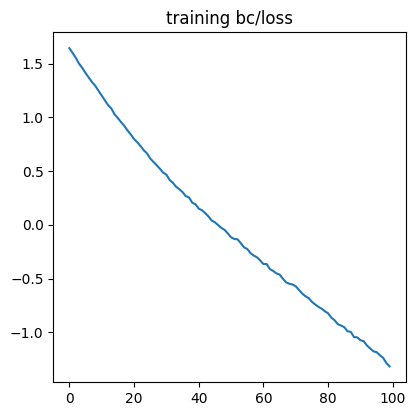

In [83]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
plt.subplot(2, 2, 1)
plt.plot(data[:, 9])
plt.title("training bc/loss")
plt.show()

['bc/neglogp', 'batch_size', 'bc/prob_true_act', 'bc/epoch', 'bc/l2_norm', 'bc/entropy', 'bc/batch', 'bc/ent_loss', 'bc/samples_so_far', 'bc/loss', 'bc/l2_loss']
(500, 11)


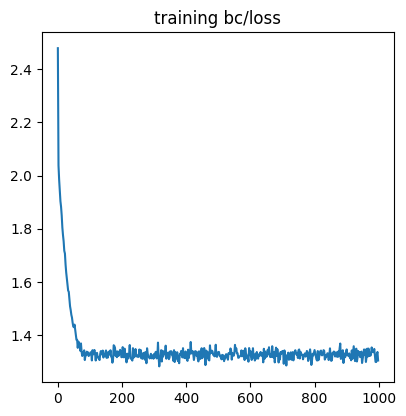

In [55]:
# read csv
with open('./log/progress.csv', 'r') as f:
    
    # read header
    header = f.readline().strip().split(',')
    print(header)
    
    # read data
    data = []
    for line in f:
        data.append(list(map(float, line.strip().split(','))))
    data = np.array(data)
    print(data.shape)

import matplotlib.pyplot as plt

y_data = data[:, 9]
x_data = range(0, len(y_data)*2, 2)
plt.figure(figsize=(10, 10))
plt.subplot(2, 2, 1)
# plt.plot(data[:, 9])
plt.plot(x_data, y_data)
plt.title("training bc/loss")
plt.show()

作成したログの名前を変更する

In [56]:
import os

# 新しいファイル名
new_csv_filename = './log/progress_24-01-26_e1000.csv'
new_txt_filename = './log/log_24-01-26_e1000.txt'

# 旧ファイル名から新ファイル名への変更
os.rename('./log/progress.csv', new_csv_filename)
os.rename('./log/log.txt', new_txt_filename)


In [206]:
import numpy as np

# 報酬（reward）の範囲を確認する
rewards = [entry['acts'] for entry in transitions]
print("Min Reward:", np.min(rewards))
print("Max Reward:", np.max(rewards))


Min Reward: 0.0
Max Reward: 1.0


In [207]:
print(rewards[2334])

[1. 1.]


In [99]:
import torch
import numpy as np
import time

# 連続値の観測空間の場合、ランダムなデータを生成
# your_observation = np.random.uniform(low=env1.observation_space.low, high=env1.observation_space.high, size=env1.observation_space.shape)
your_observation = reshaped_expert_data['images'][261]
print(env1.observation_space.shape)
print(your_observation.shape)
# モデルの出力を計算
with torch.no_grad():
    observation_tensor = torch.tensor(your_observation, dtype=torch.float32).unsqueeze(0).to("cuda")
    
    # 計測開始
    start = time.time()

    predicted_action1 = bc_trainer(observation_tensor)
    predicted_action2 = recon_bc(observation_tensor)
    
    # 計測終了
    end = time.time()

print("Predicted Action:", predicted_action1)
print("Predicted Action:", predicted_action2)

predicted_action1 = predicted_action1[0].cpu().numpy()
predicted_action2 = predicted_action2[0].cpu().numpy()

print("Predicted Action:", predicted_action1)
print("Predicted Action:", predicted_action2)

# 計測時間を表示 (hz: 1秒間に何回処理が実行されたか)
print(f"Time: {end - start}")
print(f"Hz: {1 / (end - start)}")

print(env1.action_space.shape)
print(predicted_action1.shape)

(3, 224, 224)
(3, 224, 224)


TypeError: 'BC' object is not callable

In [57]:
bc_trainer.policy.save('./model/bc_trainer_policy_24-01-26_e1000.zip')

In [59]:
from imitation.util import util
util.save_policy(bc_trainer.policy, './model/bc_trainer_policy_24-01-26_e1000')

In [60]:
recon_bc = bc.reconstruct_policy('./model/bc_trainer_policy_24-01-26_e1000', device='cuda')

In [98]:
print(bc_trainer.action_space)
print(env1.action_space)

Box([-1.  0.], 1.0, (2,), float32)
Box([-1.  0.], 1.0, (2,), float32)
